### plotting with seaborn
only use under analysis environment 

Basically everthing that needed to read/modify/write excel and plotting with sns

June update:
added section for generating excel files for averaged brains based on individual sample's excel

June 23 update:

    heatmaps:
    only include regions belonging to cerebrum, brain stem and cerebellum
    Include a threshold of 0.001 (0.1%) -> this threshold is not applied to isocortex only plot

July 03 update:
    
    bar graphs:
    depth 2 and depth 4
    isocortex only- item values normalized to total isocortex values
    MO regions only - item values normalized to total MO region values
    
October 2023 update:
    
    lots of MAJOR modifications
    Data now normalized to cell counts
    various plotting modifications
    # of regions innervated (under Axons in brain region)


In [1]:
import os
import numpy as np
import seaborn as sns

import pandas as pd
pd.options.mode.chained_assignment = None 
# disable the chained assignment warning

import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

# use seaborn for easier logrithmic color scale

import itertools
# use itertool to flatten list of list

In [2]:
def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]

def prep_df_old(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    searchfor = ['/567/', '/343/','/512/']
    cc_cb_bs= read_file.loc[read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]
    # select cerebrum 567, brain stem 343 and cerebellum  512 region only 
      
    new= cc_cb_bs.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def prep_df(df):
    ''' now only include regions belonging to and /343/ brainstem /567/ cerebrum  (but excluding /698/ olfactory areas and /1089/ hippocampal formation that belongs under /567/)'''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    
    read_file= pd.read_excel(df)
    
    searchfor = ['/567/', '/343/']
    cc_cb= read_file.loc[read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]
    # select cerebrum 567, brain stem 343 only
    
    search_exclude = ['/1089/', '/698/']
    cc_cb_clean= cc_cb.loc[~cc_cb['structure_id_path'].str.contains('|'.join(search_exclude), case=False)]
    # exclude regions under 698 olfactory areas and 1089 hippocampal formation
      
    new= cc_cb_clean.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_old(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df

def combine_df(folder,list_of_fname):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_df=[]
    
    for i in (list_of_fname):
        new_df=prep_df(os.path.join(folder, i))
        full_df.append(new_df)

    full_df=pd.concat(full_df,axis=1)
    return full_df


def prep_df_specific(df,region_id=''):
    '''Look for regions belong to one of the group by specifying region_id = : 
    343 brainstem
    567 cerebrum
    leave empty for everything else
    ie prep_df_specific(path_to_df) gives regions not belonging to brainstem or cerebrum
    prep_df_specific(path_to_df, region_id =343) gives regions belonging to brainstem only
    '''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    if region_id:
        specific_df=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    else:
        searchfor = ['/343/','/567/']
        specific_df= read_file.loc[~read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]            
    
    
    search_exclude = ['/1089/', '/698/']
    specific_df_clean= specific_df.loc[~specific_df['structure_id_path'].str.contains('|'.join(search_exclude), case=False)]
    # exclude regions under 698 olfactory areas and 1089 hippocampal formation
    
    new= specific_df_clean.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_specific(folder,list_of_fname,region_id=''):
    
    '''    # combine multiple data frames, keeping only mouse name, region id and amount of voxels
    by default, returns all of the regions that at least one brain that projects to it
    region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''

    #initialize a list for data frames to combine
    df_list = []
    for i in parent_axons:
        this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id).T
        df_list.append(this_df)
    full_df = pd.concat(df_list)

    return full_df

# def combine_df_specific_new(folder,list_of_fname,region_id='', inner=False):
    
#     ''' !! Use this one becase combine_df_specific does not work in some cases which I havn't figured out why... 
#     combine multiple data frames, keeping only mouse name, region id and amount of voxels
#     by default, returns all of the regions that at least one brain that projects to it
#     region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''
    
#     full_df=pd.DataFrame(columns=['acronym'])
#     for i in list_of_fname:
#         this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id)
#         full_df=pd.merge(full_df,this_df,on='acronym', how='outer')
#     return full_df.set_index('acronym')

### Generate excel files for averaged brains based on excel file of each sample
with standard deviations

Update september 2023! using files normalized to cell counts

In [4]:
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

In [33]:
def average_excel(name_list, side, output_name):
    parent_axons= [ i for i  in os.listdir(folder) if f'{side}_region' in i]
    #change side to right for the other hemisphere!
    
    file_list=[]
    for i in name_list:
        contained = [x for x in parent_axons if i in x]
        file_list.append(contained[0])
    # extract all the file containing thesample name
    
    print('now processing the following files:')
    print(f'{file_list}')
    
    out_name=os.path.join(outdir,output_name)
    
    axonal_df= combine_df(folder, file_list)
    #axonal_df=axonal_df.T
    
    y=axonal_df.index.to_list()
    test_order=[]

    for i in y:
        name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
        test_order.append(name)

    sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
    sort_acronym_df.sort_values('graph_order', inplace=True)
    # sort the aconnyms based on graph order

    final_df= axonal_df.reindex(sort_acronym_df.acronyms.to_list())
    #final_df
    
    final_df['average']=final_df.mean(axis=1)
    final_df['std']= final_df.std(axis=1)
    # compute average and std
    
    result = pd.merge(final_df.reset_index(), atlas_labels, on=['acronym'])
    # need to reset_index here because acronym was both an index and a column
    
    result.to_excel(f'{out_name}_avg_{side}.xlsx') 
    
    return 


#### Loop using dictionary, create average excel for each genotype and injection site

In [35]:
region='s2'
# change to s1 or s2 and repeat again

folder= f'D:\\viral_results\\{region}_result'
outdir = f'D:\\viral_results\\{region}_average'


In [36]:
if region == 's1':
    sample_dictionary= {'sim': ['AL207','AL209','AL273'],
                        'rbp': ['AL211','AL318'],
                        'tlx': ['AL213','AL313','AL314'],
                        'ras': ['AL254','AL255','AL257'],
                        'scn': ['AL290','AL291','AL292','AL293'],
                        'nts': ['AL274','AL285','AL311']
                       }
elif region == 's2':
    sample_dictionary= {'sim': ['AL281','AL286','AL321','AL322'],
                        'rbp': ['AL288','AL326','AL327'],
                        'tlx': ['AL278','AL280','AL319'],
                        'ras': ['AL303','AL332','AL333'],
                        'scn': ['AL290','AL292','AL323'],
                        'nts': ['AL274','AL310','AL330']
                       }

In [37]:
for key, value in sample_dictionary.items():
    mouse_line=key
    outputname= f'{region}_{mouse_line}'
    
    #out_name=os.path.join(outdir,outputname)
    
    for j in ['left','right']:

        average_excel(value, j, outputname)

print('Done')

now processing the following files:
['AL281_left_region_with_counts.xlsx', 'AL286_left_region_with_counts.xlsx', 'AL321_left_region_with_counts.xlsx', 'AL322_left_region_with_counts.xlsx']
now processing the following files:
['AL281_right_region_with_counts.xlsx', 'AL286_right_region_with_counts.xlsx', 'AL321_right_region_with_counts.xlsx', 'AL322_right_region_with_counts.xlsx']
now processing the following files:
['AL288_left_region_with_counts.xlsx', 'AL326_left_region_with_counts.xlsx', 'AL327_left_region_with_counts.xlsx']
now processing the following files:
['AL288_right_region_with_counts.xlsx', 'AL326_right_region_with_counts.xlsx', 'AL327_right_region_with_counts.xlsx']
now processing the following files:
['AL278_left_region_with_counts.xlsx', 'AL280_left_region_with_counts.xlsx', 'AL319_left_region_with_counts.xlsx']
now processing the following files:
['AL278_right_region_with_counts.xlsx', 'AL280_right_region_with_counts.xlsx', 'AL319_right_region_with_counts.xlsx']
now proc

#### example detailed code outside of loop using s1_sim as example 
for trouble shooting/ understanding only

In [29]:
# example code outside loop for detailed examination
region='s1'
mouse_line= 'sim'

folder= f'D:\\viral_results\\{region}_result'
outdir = f'D:\\viral_results\\{region}_result'

outputname= f'{region}_{mouse_line}'
name_list= ['AL207','AL209','AL273']

##### left side - detialed code

In [24]:
side='left'
parent_axons= [ i for i  in os.listdir(folder) if f'{side}_region' in i]
#change side to right for the other hemisphere!

#name_list= ['AL207','AL209','AL273']

file_list=[]
for i in name_list:
    contained = [x for x in parent_axons if i in x]
    file_list.append(contained[0])
# extract all the file containing thesample name

file_list

out_name=os.path.join(outdir,'s1_sim')

In [8]:
axonal_df= combine_df(folder, file_list)
axonal_df=axonal_df.T

axonal_df.head()

# combine values from relevant samples based on acronym

AL207     AL209     AL273
acronym                                   
fiber tracts  0.005841  0.001936   0.00355
RT            0.019293   0.00478  0.005749
VISal1        0.001994  0.000344  0.000134
ll            0.000155  0.000083  0.000156
MD            0.000292   0.00026  0.000875

In [9]:
y=axonal_df.index.to_list()
test_order=[]

for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
    test_order.append(name)
    
sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
sort_acronym_df.sort_values('graph_order', inplace=True)
# sort the aconnyms based on graph order

final_df= axonal_df.reindex(sort_acronym_df.acronyms.to_list())
#final_df

In [15]:
final_df['average']=final_df.mean(axis=1)
final_df['std']= final_df.std(axis=1)
# compute average and std

In [18]:
result = pd.merge(final_df.reset_index(), atlas_labels, on=['acronym'])
# need to reset_index here because acronym was both an index and a column
result.head()

# final result keeps all individual values but also computed average and std

acronym     AL207     AL209     AL273   average       std         id  \
0    root  0.000642  0.000836  0.003453  0.001644  0.001282        997   
1  FRP2/3       NaN       NaN  0.000004  0.000004  0.000000        667   
2    FRP5       NaN       NaN  0.000075  0.000075  0.000000  526157192   
3    MOp1  0.000872  0.000001  0.001212  0.000695  0.000510        320   
4  MOp2/3  0.002361  0.000201  0.002009  0.001524  0.000946        943   

   atlas_id                           name  st_level  ...  graph_order  \
0      -1.0                           root         0  ...            0   
1    1073.0        Frontal pole, layer 2/3        11  ...            8   
2       NaN          Frontal pole, layer 5        11  ...            9   
3     888.0    Primary motor area, Layer 1        11  ...           19   
4     966.0  Primary motor area, Layer 2/3        11  ...           20   

                       structure_id_path  color_hex_triplet  \
0                                  /997/             FFFFFF   
1        /997/8/567/688/695/315/184/667/             268F45   
2  /997/8/567/688/695/315/184/526157192/             268F45   
3    /997/8/567/688/695/315/500/985/320/             1F9D5A   
4    /997/8/567/688/695/315/500/985/943/             1F9D5A   

   neuro_name_structure_id  neuro_name_structure_id_path  failed  sphinx_id  \
0                      NaN                           NaN       f          1   
1                      NaN                           NaN       f          9   
2                      NaN                           NaN       f         10   
3                      NaN                           NaN       f         20   
4                      NaN                           NaN       f         21   

  structure_name_facet failed_facet                     safe_name  
0            385153371    734881840                          root  
1           4268100038    734881840        Frontal pole layer 2/3  
2           1413248090    734881840          Frontal pole layer 5  
3            571569106    734881840    Primary motor area Layer 1  
4           2488357079    734881840  Primary motor area Layer 2/3  

[5 rows x 26 columns]

In [19]:
result.to_excel(f'{out_name}_avg_{side}.xlsx') 
# save

In [35]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL274_axon_left_region_with_counts.xlsx', 'AL310_axon_left_region_with_counts.xlsx', 'AL330_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL274_axon_right_region_with_counts.xlsx', 'AL310_axon_right_region_with_counts.xlsx', 'AL330_axon_right_region_with_counts.xlsx']


### Section for plotting cell counts vs axon voxels
Added september 2023


In [82]:
outdir =r'D:\viral_results'

s1_data=pd.read_excel (r'D:\viral_results\s1\sample_info.xlsx')
s2_data=pd.read_excel (r'D:\viral_results\s2\sample_info.xlsx')

In [86]:
s1_data['axon_per_cell']= s1_data['total_axons']/ s1_data['cell_counts']

s2_data['axon_per_cell']= s2_data['total_axons']/ s2_data['cell_counts']

s1_data.head()

Unnamed: 0.1  Unnamed: 0 sample  cell_counts  total_axons     Genotype  \
0             0           0  AL207          488      3320321      Sim1Cre   
1             1           1  AL209          554      3591770      Sim1Cre   
2             2           2  AL211          517     12402544      Rbp4Cre   
3             3           3  AL213          928     20116749      Tlx3Cre   
4             4           4  AL254          628      1552465  Rasgrf2dCre   

   axon_per_cell inj_site  
0    6803.936475       s1  
1    6483.339350       s1  
2   23989.446809       s1  
3   21677.531250       s1  
4    2472.078025       s1

In [87]:
s1_data['inj_site']= 's1'

s2_data['inj_site']= 's2'

all_data= pd.concat([s1_data, s2_data])

all_data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
# some how got two useless columns

Text(0.5, 1.0, 'All_Samples')

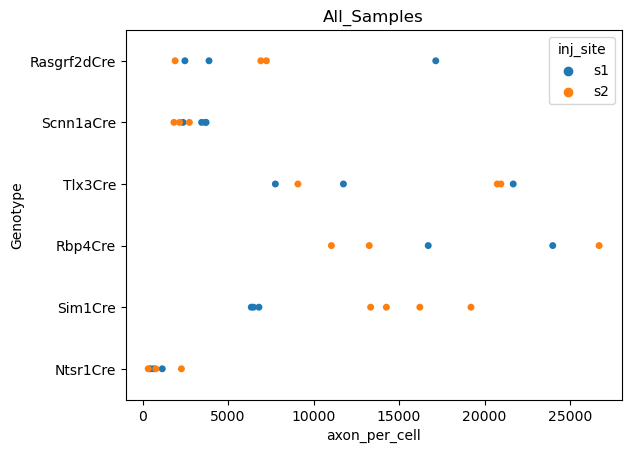

In [88]:
ax = sns.stripplot(data=all_data, x="axon_per_cell", y="Genotype", hue='inj_site',
                   order=['Rasgrf2dCre', 'Scnn1aCre', 'Tlx3Cre', 'Rbp4Cre', 'Sim1Cre', 'Ntsr1Cre'],jitter=False)
ax.set_title('All_Samples')

Text(0.5, 1.0, 'All_Samples')

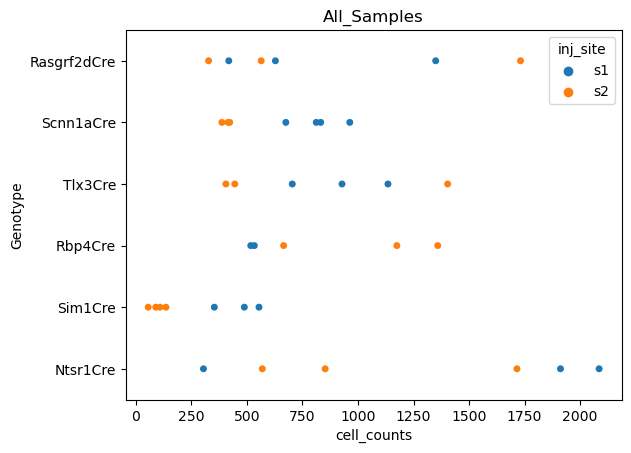

In [91]:
ax = sns.stripplot(data=all_data, x="cell_counts", y="Genotype", hue='inj_site',
                   order=['Rasgrf2dCre', 'Scnn1aCre', 'Tlx3Cre', 'Rbp4Cre', 'Sim1Cre', 'Ntsr1Cre'],jitter=False)
ax.set_title('All_Samples')

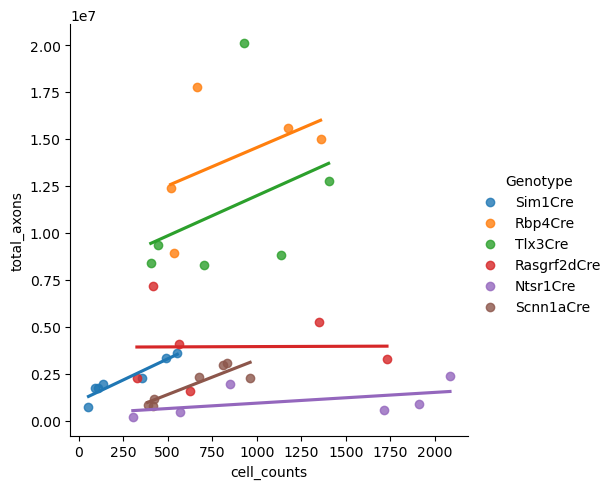

In [89]:
sns.lmplot(data=all_data, x='cell_counts', y='total_axons', hue='Genotype', order=1, ci=None)

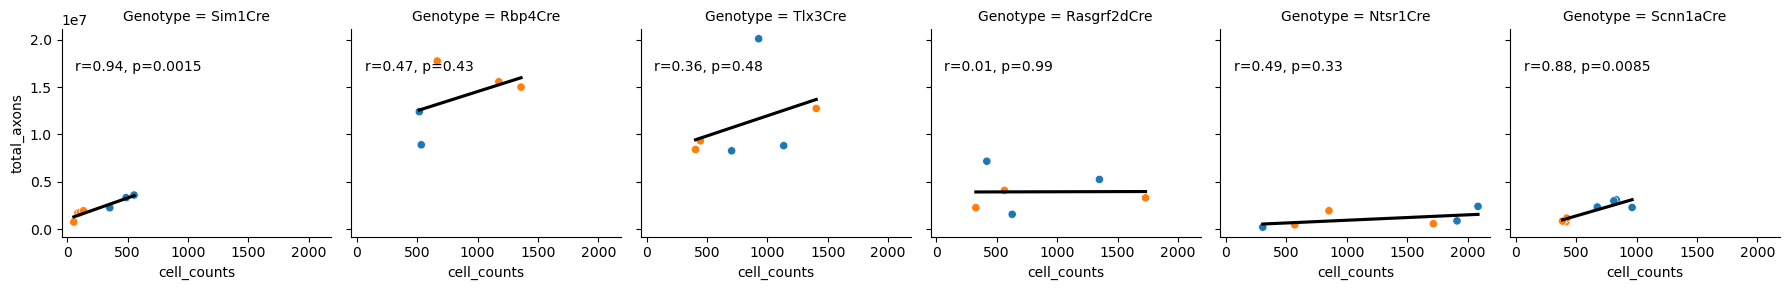

In [90]:
import scipy 

def annotate(data, **kws):
    r, p = scipy.stats.pearsonr(data['cell_counts'], data['total_axons'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)


    
g = sns.FacetGrid(all_data, col="Genotype")
# create a facet grid

g.map_dataframe(sns.regplot, x='cell_counts', y='total_axons', data=all_data,ci=None, scatter=False, color='k')
#map regression line to facet grid but hide scatter, because we calculate it based on all data from the same cre line 
# but still want to indicate s1 vs s2 injection some how and regplot doesnt take color argument (it will plot two separate regression lines!)

g.map_dataframe(annotate)
# write r value and p values for the regression line

g.map_dataframe(sns.scatterplot, x='cell_counts', y='total_axons', hue='inj_site',  data=all_data)
# map scatter plots onto facet grid to use color to indicate injection site information

plt.show()


###  heatmap for axons in brain region

LOG scale or linear scale

In [3]:
#find all relevant files
folder= r'D:\viral_results\s1_result'
outdir = r'D:\viral_results\s1_result'
# change folder to s1 or s2

files= [ i for i  in os.listdir(folder) if 'with_counts' in i]

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')


In [4]:
column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314','AL211','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of September .2023

#column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327','AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of June.2023

In [5]:
# load in left side

side='left'
parent_axons= [ i for i  in os.listdir(folder) if 'Lparent' in i]
#change side to right and Rparent for the other hemisphere!

#axonal_df= combine_df_old(folder, parent_axons)
#axonal_df=axonal_df.T

axonal_df= combine_df(folder, parent_axons)
#a cleaner way to concatenate dataframe

final=axonal_df[column_order]

df=final.fillna(0.0)
# fill Nan with 0 because sns heatmap does not accept nan


In [7]:
# load in right side

side='right'
parent_axons= [ i for i  in os.listdir(folder) if 'Rparent' in i]

axonal_df_r= combine_df(folder, parent_axons)
#a cleaner way to concatenate dataframe

final_r=axonal_df_r[column_order]

df_r=final_r.fillna(0.0)
# fill Nan with 0 because sns heatmap does not accept nan


In [8]:
both=pd.concat([df,df_r],axis=1)
both.fillna(value=0, inplace=True)

In [9]:
both= both[(both > 1).any(1)]# only take regions that have value above 1 for any one of the sample


In [10]:
leftindex= int(len(both.columns)/2)
#split the length of both data frame in half , since the first half is always left hemisphere and later half always right hemisphere

leftside= both.T.iloc[0:leftindex]
rightside=both.T.iloc[leftindex:]
# tranpose so we can use iloc to split back to left and right

In [11]:
leftside=leftside.T
rightside=rightside.T
#transpose back

In [12]:
y=leftside.index.to_list()
test_order=[]

for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
    test_order.append(name)

# get all the acronyms involved and their graphorder

In [13]:
sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
sort_acronym_df.sort_values('graph_order', inplace=True)
# sort the aconnyms based on parent structure id

final_left= leftside.reindex(sort_acronym_df.acronyms.to_list())
final_right= rightside.reindex(sort_acronym_df.acronyms.to_list())
#final_df

#### Plot full heatmaps

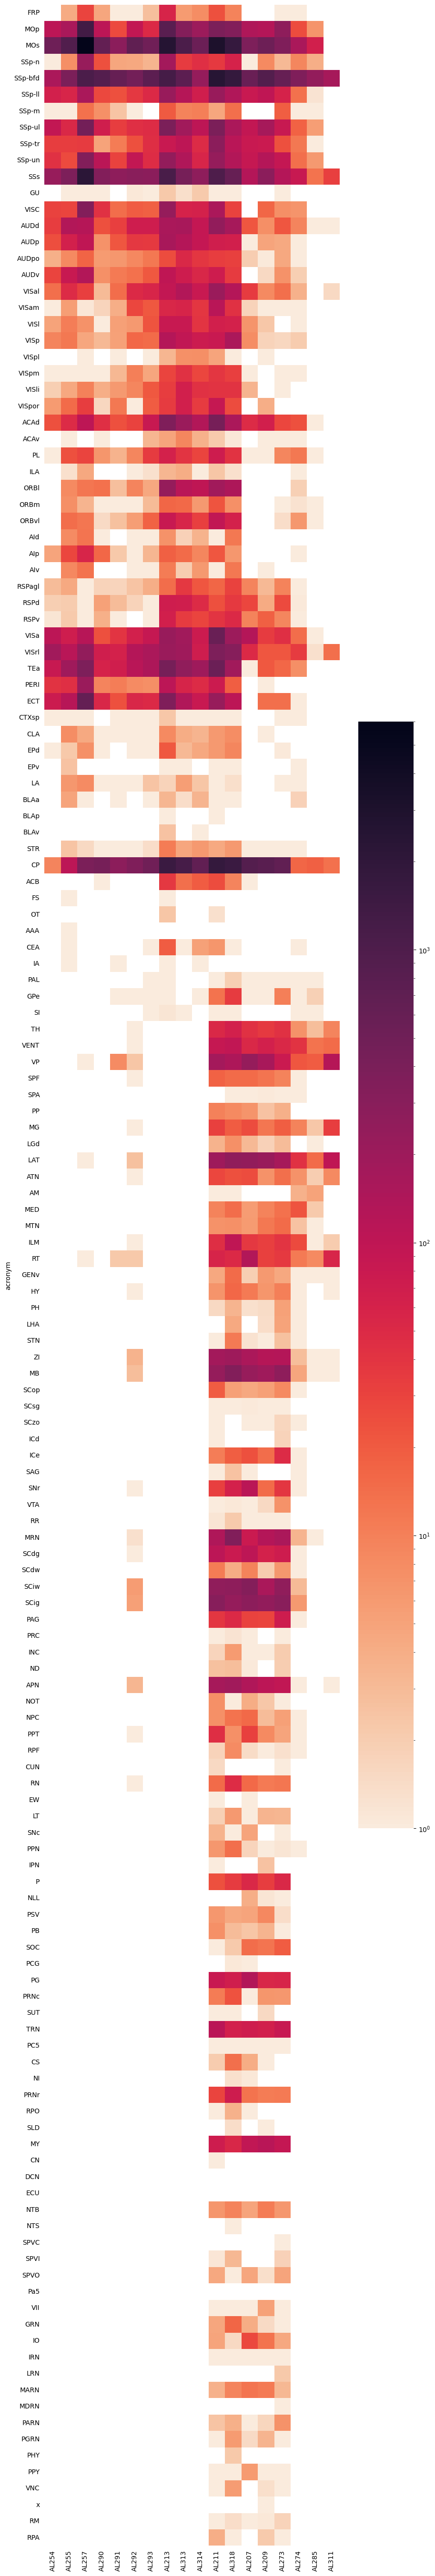

In [15]:
# log color scale, do not change vmin and vmax! 1 and 6000

fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_left, 
                norm=LogNorm(vmin=1, vmax= 6000),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\left_heatmap_logscale.svg')

plt.show()

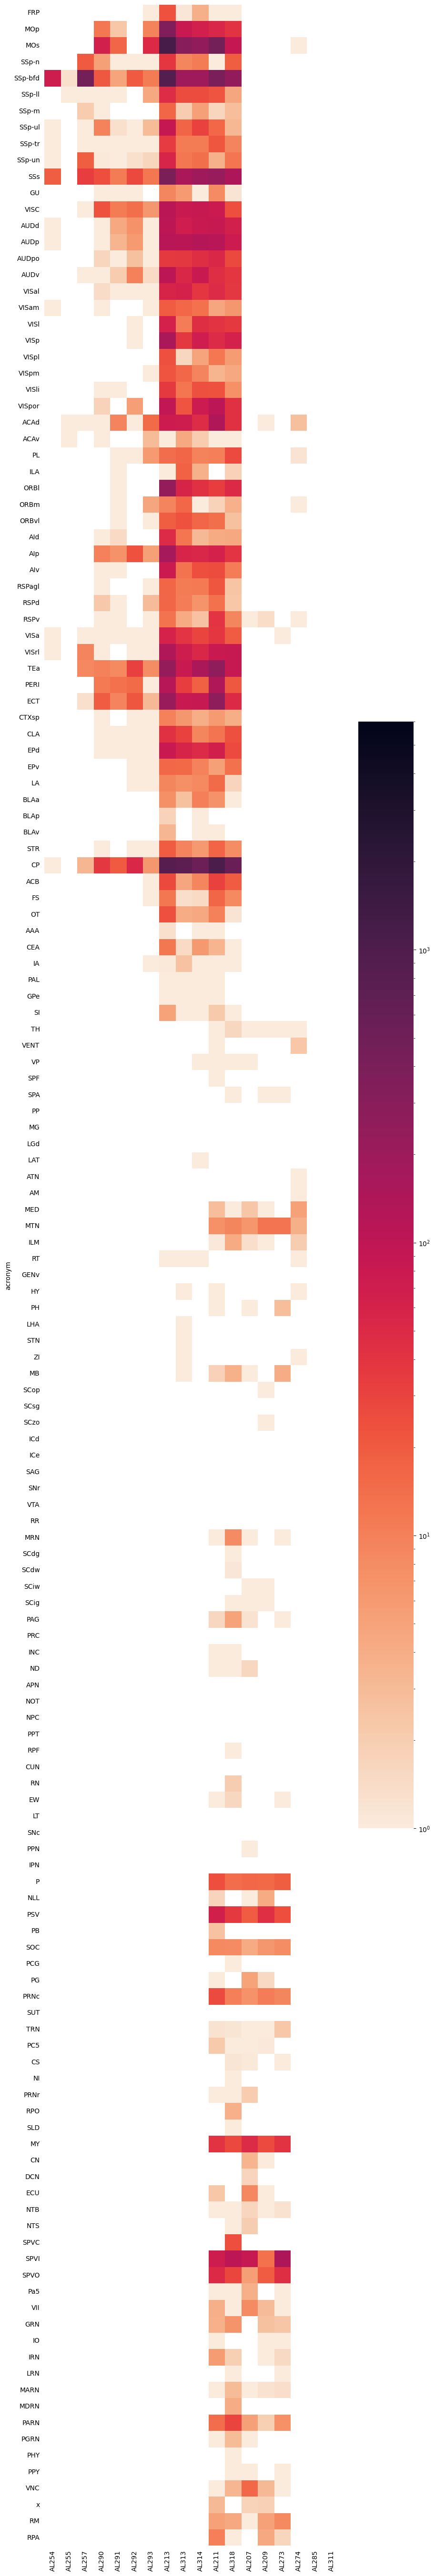

In [16]:
# repeat for right side
fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_right, 
                norm=LogNorm(vmin=1, vmax= 6000),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_logscale.svg')

plt.show()

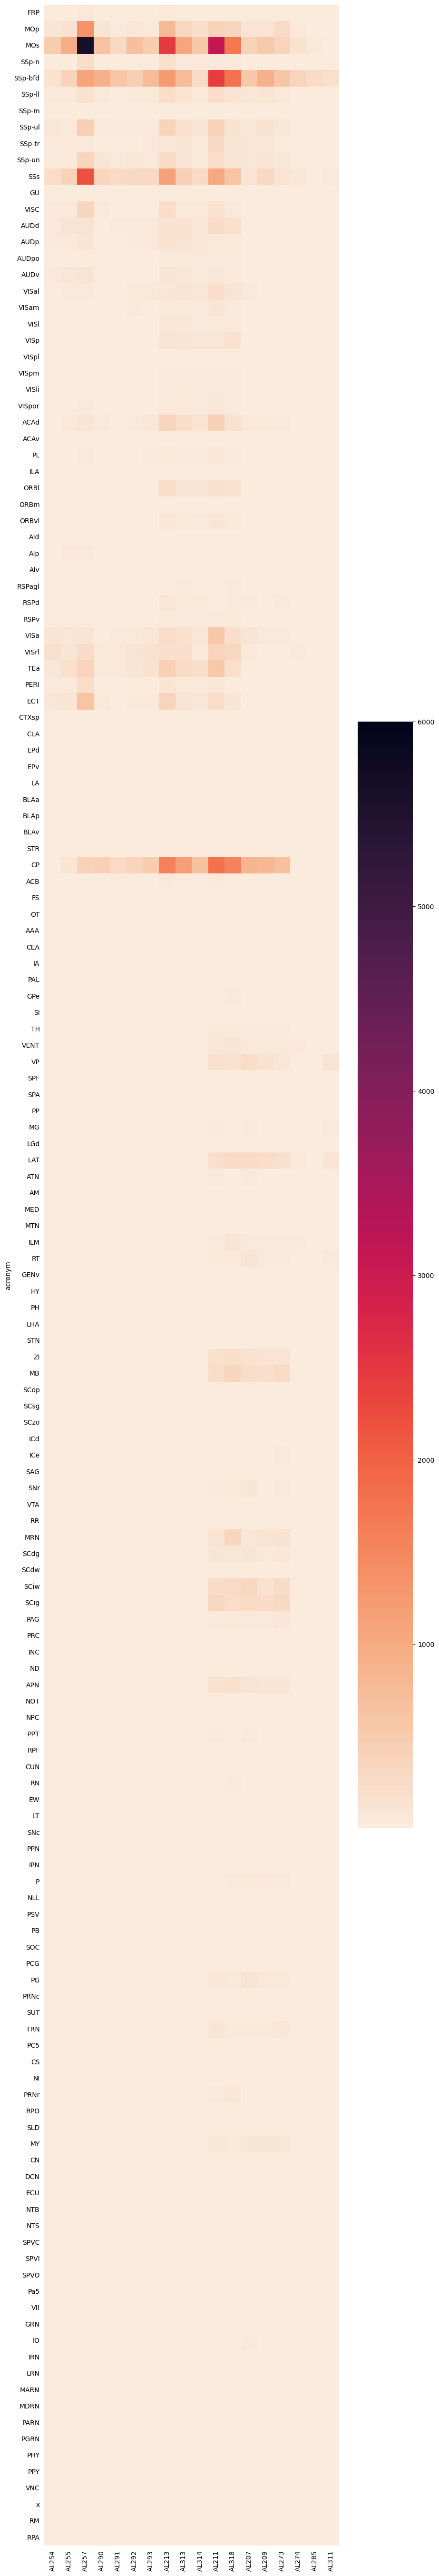

In [17]:
# linear scale, do not change vmin and vmax!! 1 and 6000
fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_left, 
                cmap="rocket_r",
                square=True,
                vmin= 1,
                vmax=6000, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\left_heatmap_linearscale.svg')

plt.show()

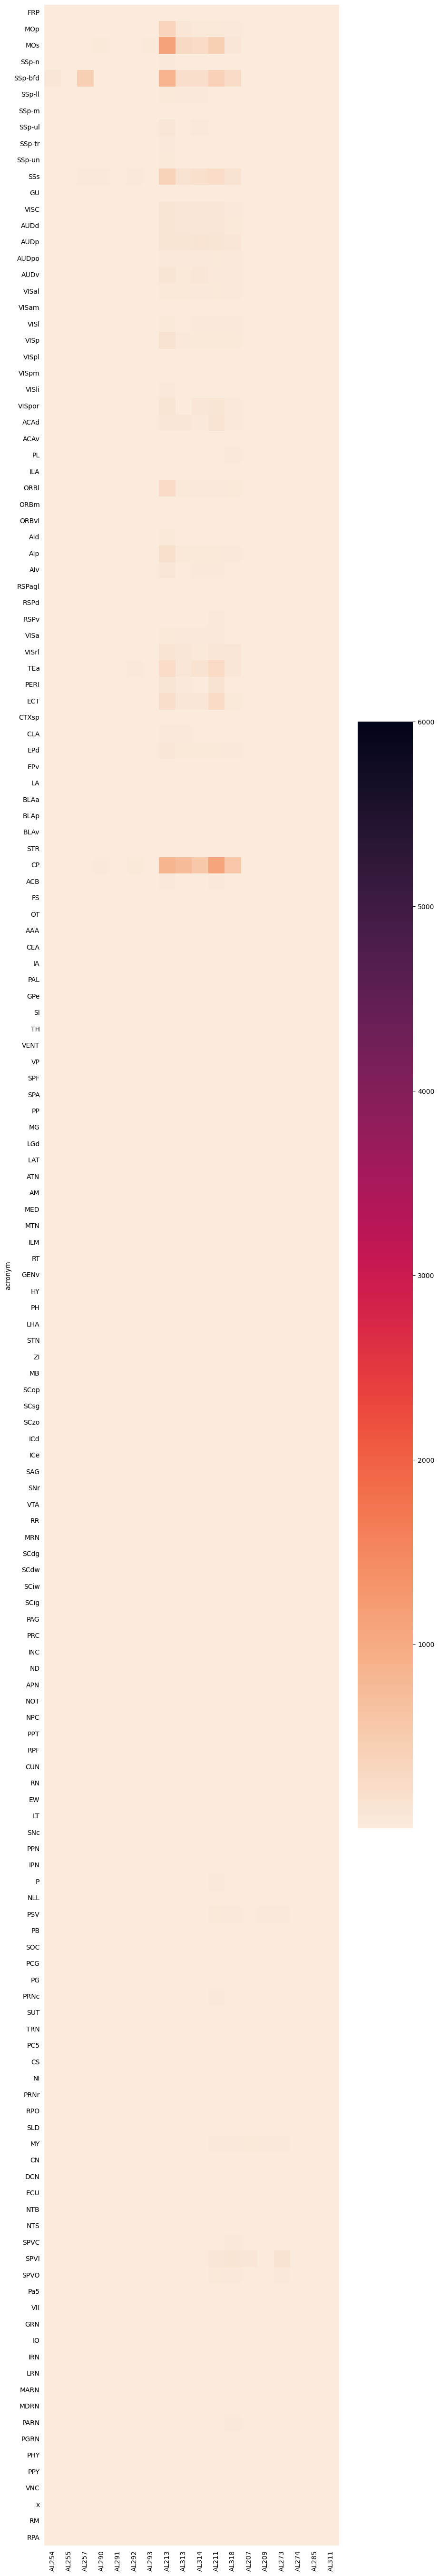

In [18]:
# linear scale, do not change vmin and vmax!! 1 and 6000
# repeat for right side
fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_right, 
                cmap="rocket_r",
                square=True,
                vmin= 1,
                vmax=6000, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_linearscale.svg')

plt.show()

#### Heatmap- plot first 50 regions by rank

work in progress



In [14]:
final_left['Average']= final_left.mean(axis=1)
final_left.sort_values(by= 'Average', ascending=False, inplace=True)

# calculate average amount of axons per cell for all columns (ie. all samples)

left_50= final_left.iloc[0:50]
# take the top 50 by rank and plot

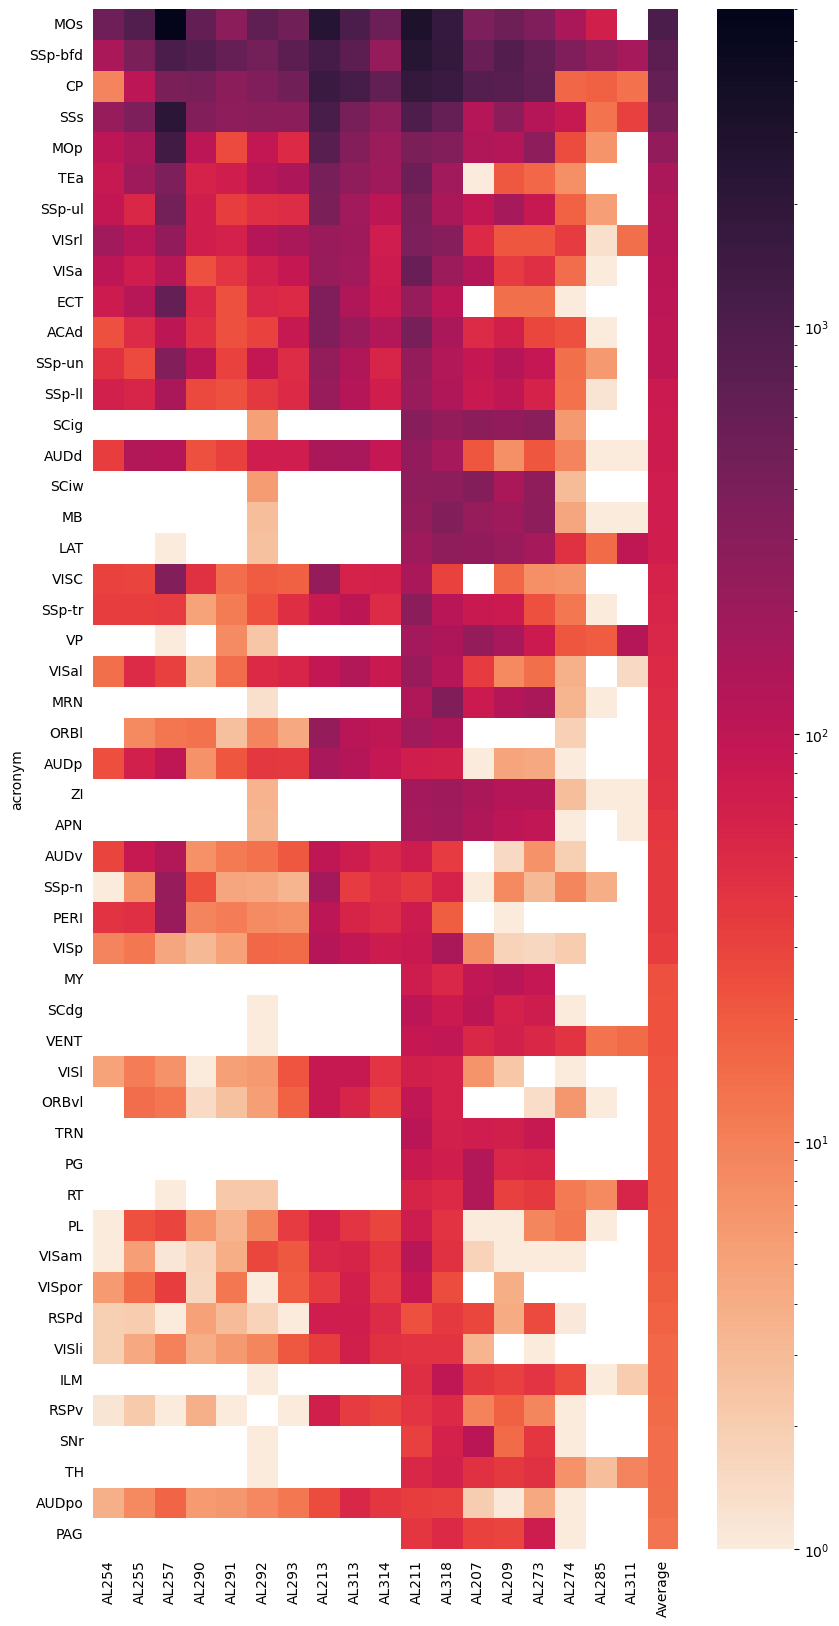

In [15]:
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(left_50, 
                norm=LogNorm(vmin=1, vmax= 6000),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\left_heatmap_top50_logscale.svg')

plt.show()

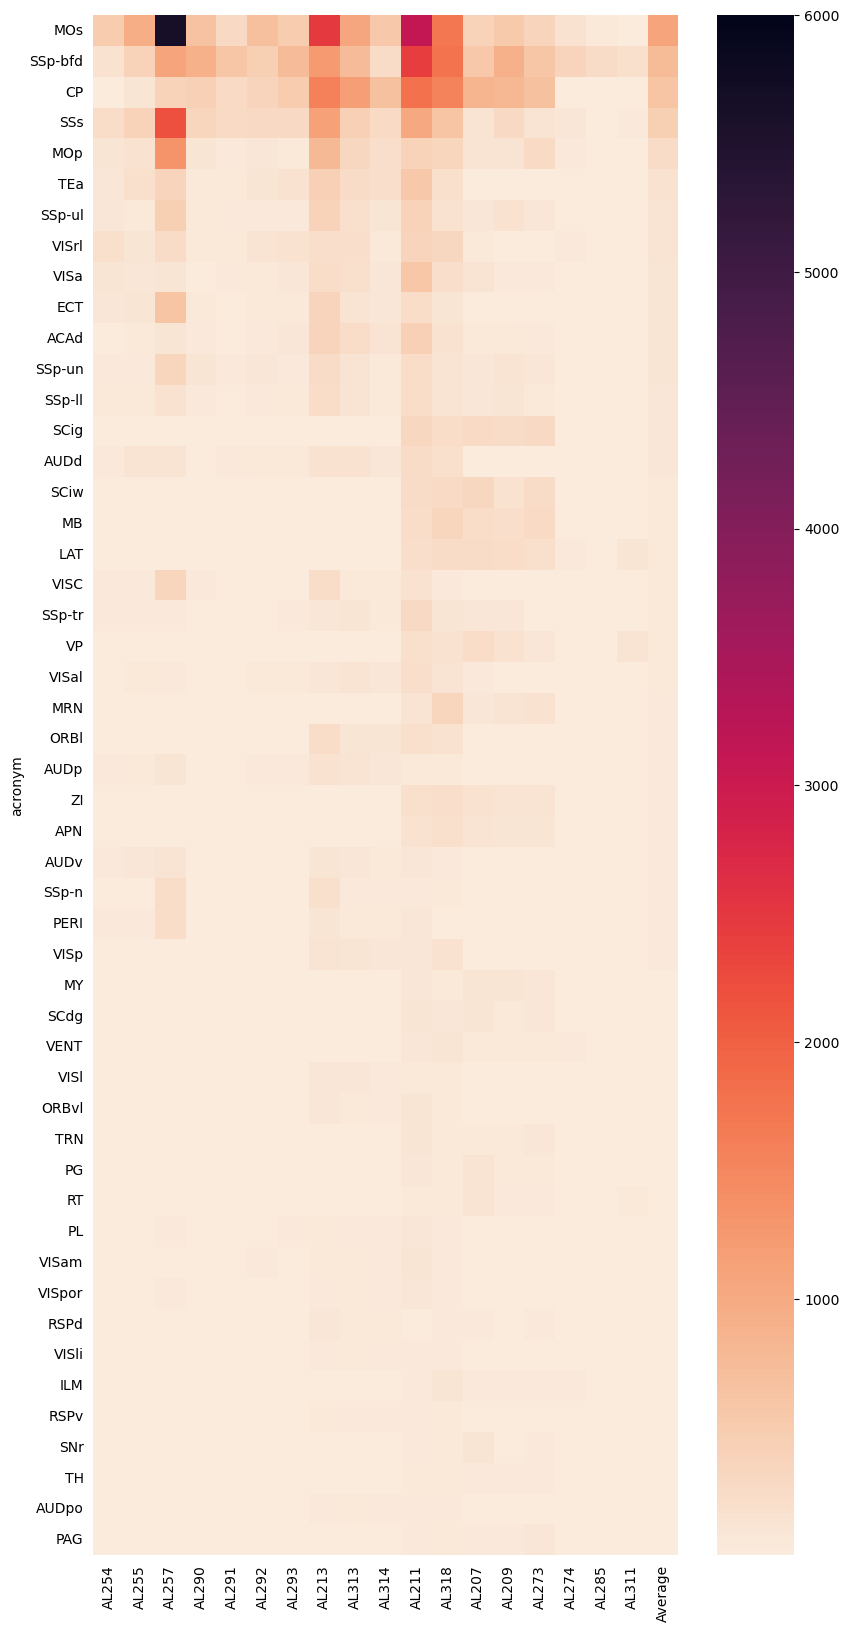

In [16]:
# linear scale, do not change vmin and vmax!! 1 and 6000
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(left_50, 
                cmap="rocket_r",
                square=True,
                vmin= 1,
                vmax=6000, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\left_heatmap_top50_linearscale.svg')

plt.show()

In [17]:
# repeat for right side

final_right['Average']= final_right.mean(axis=1)
final_right.sort_values(by= 'Average', ascending=False, inplace=True)

# calculate average amount of axons per cell for all columns (ie. all samples)

right_50= final_right.iloc[0:50]
# take the top 50 by rank and plot

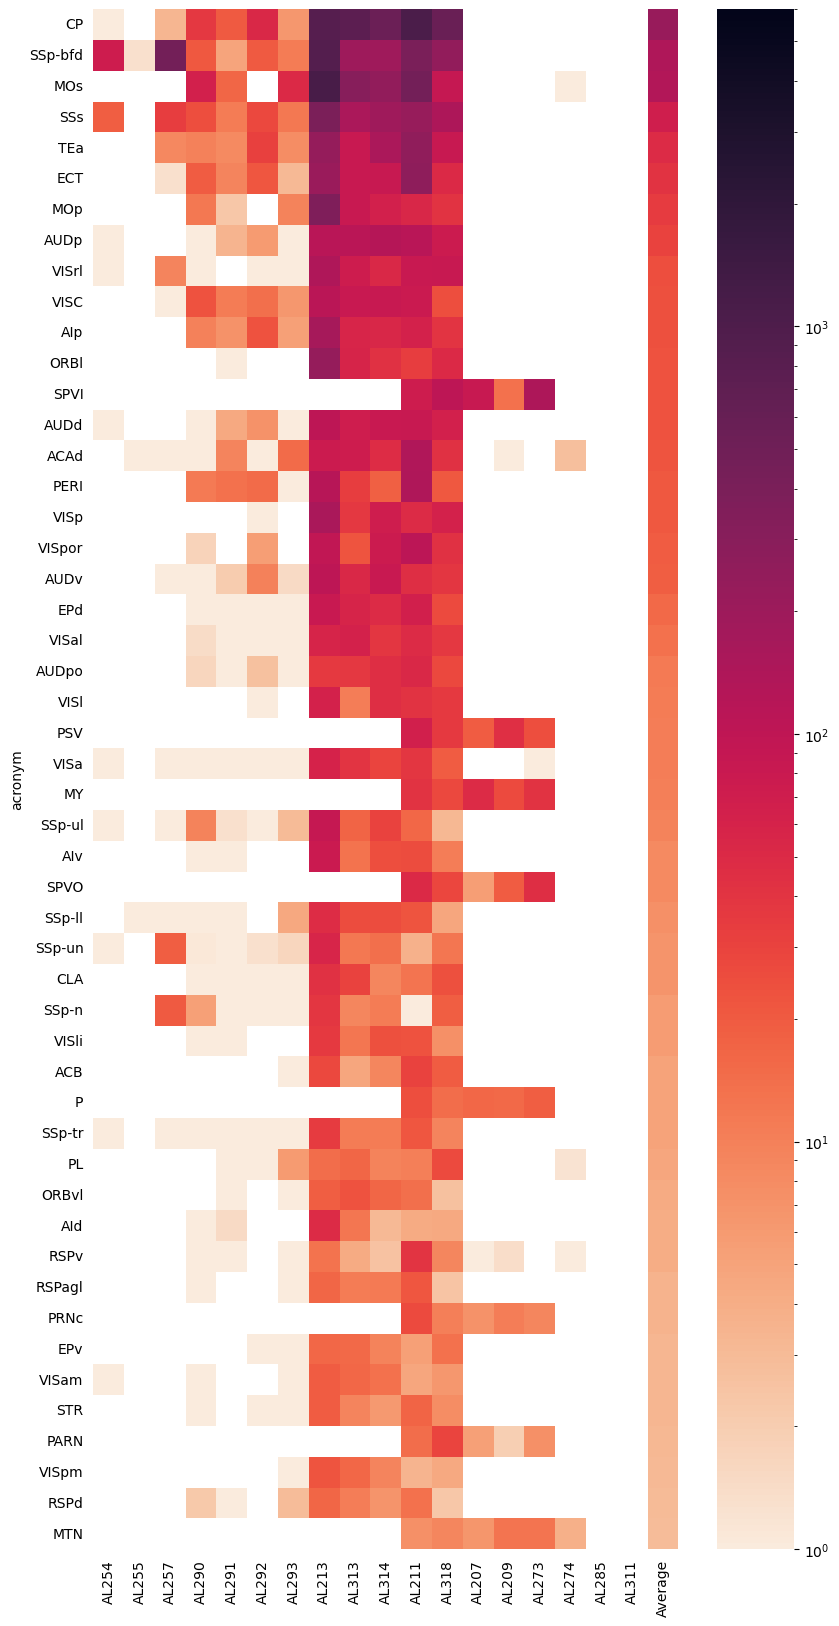

In [18]:
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(right_50, 
                norm=LogNorm(vmin=1, vmax= 6000),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_top50_logscale.svg')

plt.show()

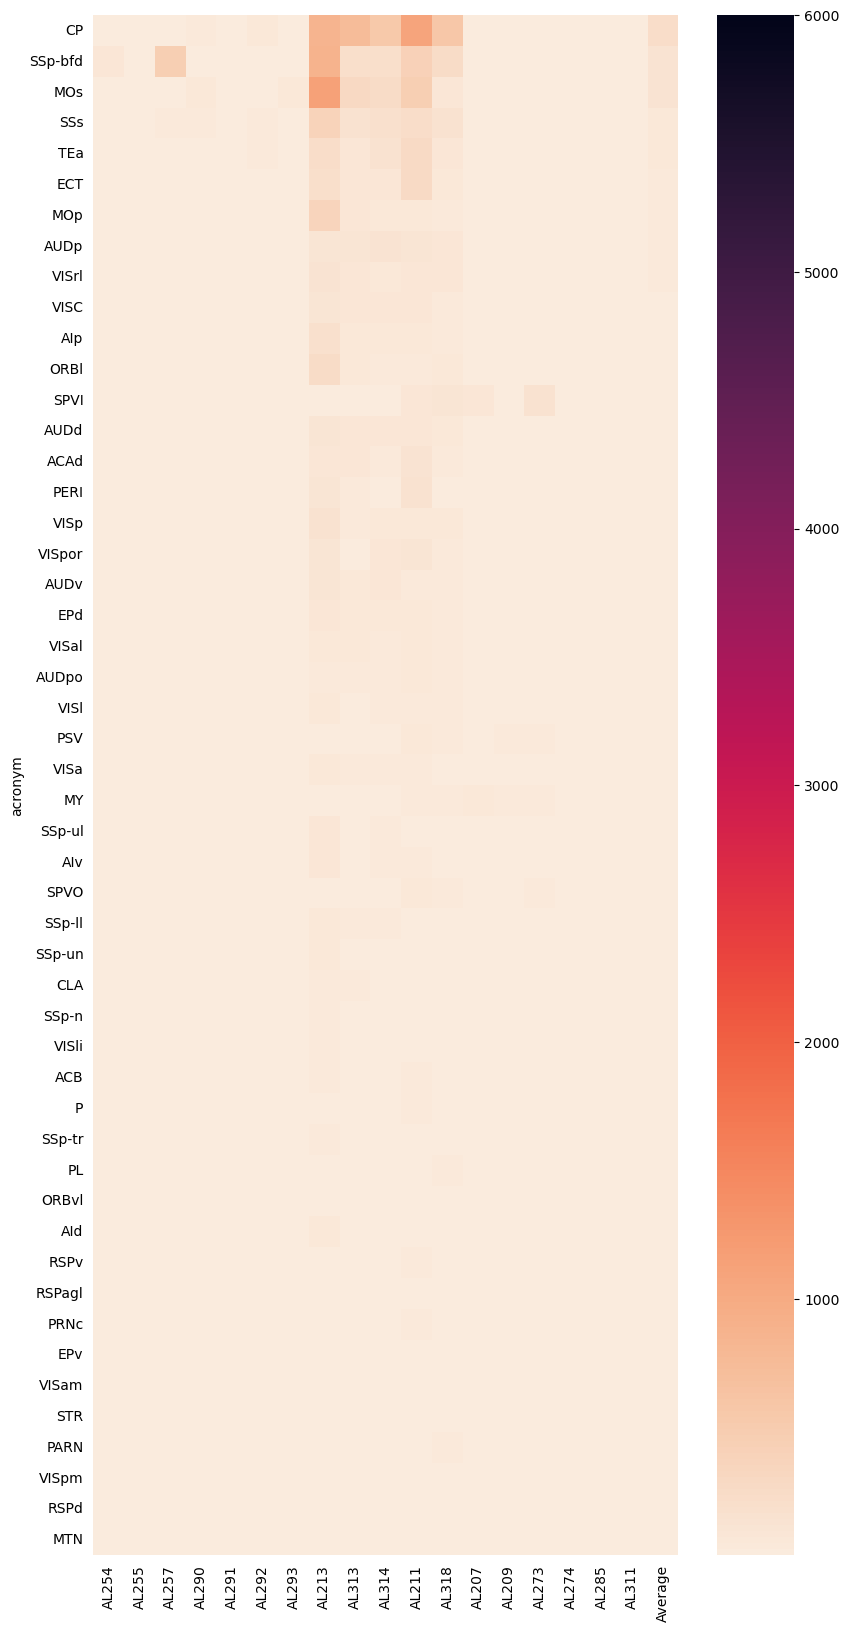

In [19]:
# linear scale, do not change vmin and vmax!! 1 and 6000
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(right_50, 
                cmap="rocket_r",
                square=True,
                vmin= 1,
                vmax=6000, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_top50_linearscale.svg')

plt.show()

### generate a list of abbreviations
Load data from the above seciton first heatmap-for all brain regions in the cerebrum, brainstem and cerebellum

In [14]:
y=df.index.to_list()

full_name=[]
for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").name.values[0]
    full_name.append(name)
# get full name

In [17]:
parent_acronyms= {'Acronyms': y, 'Full name': full_name}
acronym_df= pd.DataFrame(data=parent_acronyms)
acronym_df.to_excel('thesis_acronyms.xlsx')

### Axons in specific brain region 

ie. id= 315 isocortex, 688 cerebral cortex, 343 brainstem...etc

This section includes:
- plot heatmap
- count # of inenrvated region within the selection

In [20]:
def norm_region(df, df_r):
    
    ''' 
    Not useful for newer normalized data (already normalized to cell count and no need to further normalze by whatever else)
    
    Normalize values by the sum of the column. Usefuly if all the rows in the data frame belongs to the parent region that wants to be normalized to
    
    No need to specify column list here since it has been extracted already from combine_df_specific'''
    
    region_sum= df.sum()
     # calculate sum across all rows for a given column since everything isocortex related is already extracted
    # find total isocortex values in left hemisphere

    region_sum_r= df_r.sum()
    # find total isocortex values in right hemisphere

    all_isocortex=region_sum+region_sum_r
    # add these up

    norm_values= df/all_isocortex
    # divide left side to normalize

    norm_values_r= df_r/all_isocortex
    # divide right side to normalize

    return norm_values,norm_values_r

def plot_log(df,side):

    # log color scale, do not change vmin and vmax! 1 and 6000

    fig, ax = plt.subplots(figsize=(10,20))
    g1= sns.heatmap(df, 
                    norm=LogNorm(vmin= 1, vmax= 6000),
                    cmap="rocket_r",
                    square=True,
                    linewidths=0.0,
                    rasterized=True)

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!
    g1.set( ylabel=None)

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!

    plt.savefig(f'{outdir}\{side}_{region_id}_heatmap_logscale.svg')
    plt.show()
    
    return

def plot_lin(df,side):
# linear scale, do not change vmin and vmax, 1 and 6000

    fig, ax = plt.subplots(figsize=(10,20))
    g1= sns.heatmap(df,
                    cmap="rocket_r",
                    vmin= 1,
                    vmax= 6000, 
                    square=True,
                    linewidths=0.0,
                    rasterized=True)
    g1.set( ylabel=None)

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!

    plt.savefig(f'{outdir}\{side}_{region_id}_heatmap_linearscale.svg')

    plt.show()
    
    return

In [3]:
#find all relevant files

region='s1'

folder= f'D:\\viral_results\\{region}_result'
outdir = f'D:\\viral_results\\{region}_result'
# change s1 to s2

region_id='688'
# 315 isocortex, 688 cerebral cortex, 343 brainstem


files= [ i for i  in os.listdir(folder) if 'with_counts' in i]

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

In [4]:
if region== 's1':

    column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314','AL211','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
    # for verified s1 injections as of september .2023

else :
    column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327','AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
    #for s2 injections as of June.2023

In [5]:
side='left'
parent_axons= [ i for i  in os.listdir(folder) if 'Lparent' in i]

axonal_df= combine_df_specific(folder, parent_axons,region_id)
axonal_df=axonal_df.T

In [6]:
# plot isocortex only 
side='right'
parent_axons= [ i for i  in os.listdir(folder) if 'Rparent' in i]

axonal_df_r= combine_df_specific(folder, parent_axons,region_id)
axonal_df_r=axonal_df_r.T

In [8]:
#leftside,rightside= norm_region(axonal_df, axonal_df_r)

#no longer needed for values normalized by cell counts.
#normalize by total isocortex axons from both hemispheres

#### plot heatmap

In [72]:
#both=pd.concat([leftside,rightside], join='outer', axis=1)

both=pd.concat([axonal_df, axonal_df_r], join='outer', axis=1)
both.fillna(value=0, inplace=True)
# concat so that the same region show up in left and right side
# concat on axis=1 since columns are sample and rows are regions

In [73]:
test=atlas_labels.merge(pd.DataFrame(both.index), on='acronym', how='inner')
order=test.sort_values(by='graph_order')['acronym']

# confirm region ordering by taking the involved acronym, inner merge with atlas labels then order by graph order

final= both.reindex(order)

In [74]:
leftindex= int(len(both.columns)/2)
#split the length of both data frame in half , since the first half is always left hemisphere and later half always right hemisphere

leftside= final.iloc[:, 0:leftindex]
leftside=leftside[column_order]
# extract first half of the columns , then set column order

rightside=final.iloc[:, leftindex:]
rightside=rightside[column_order]
# repeart for right side

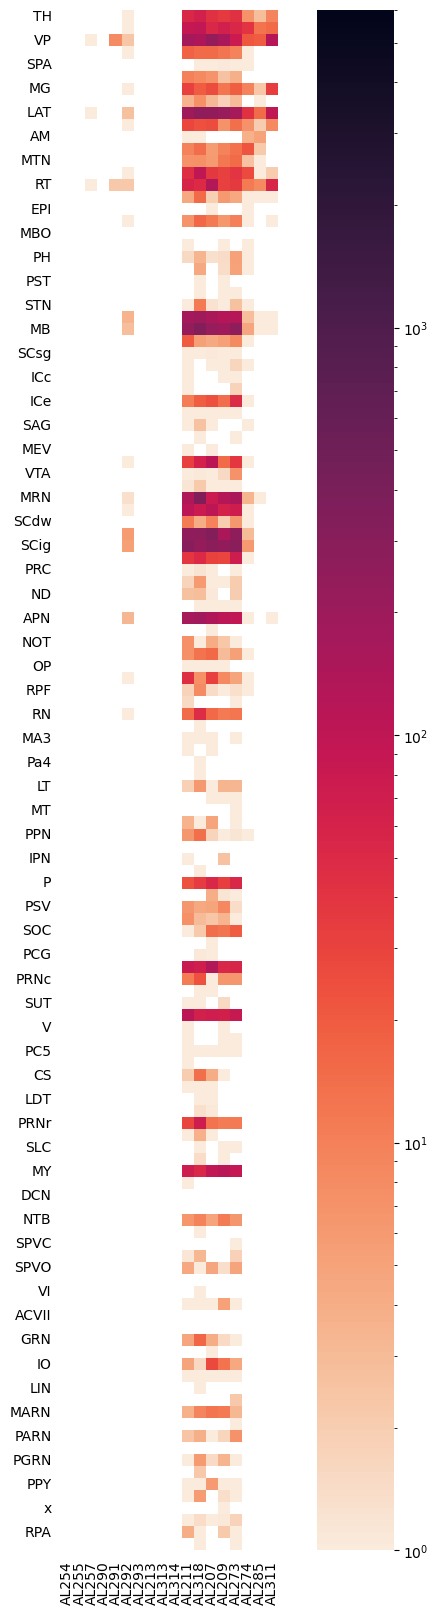

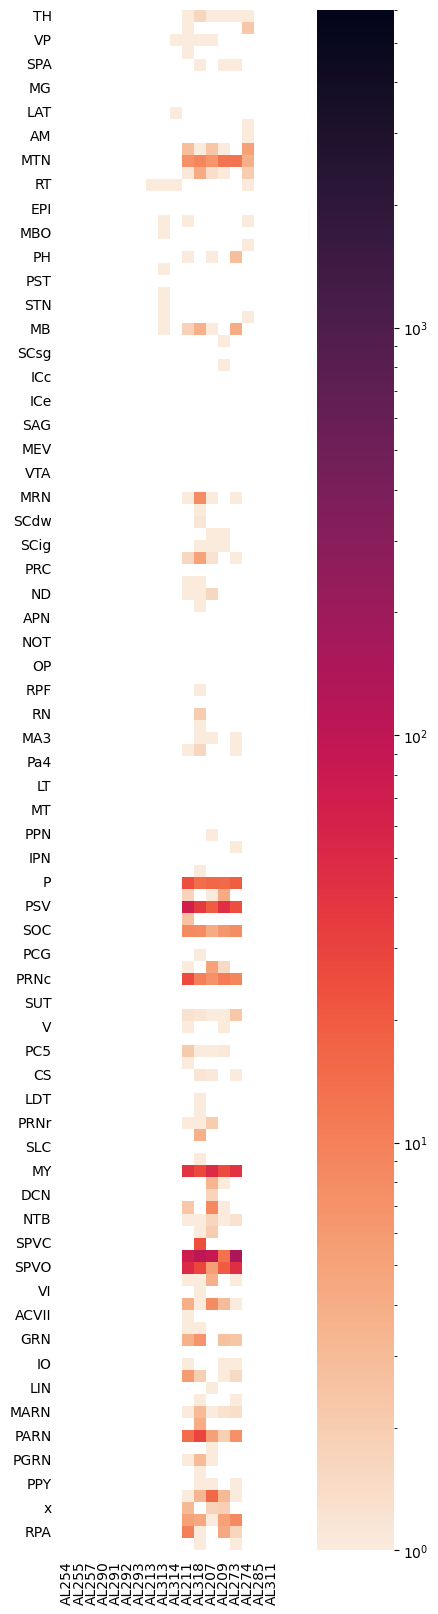

In [75]:
plot_log(leftside,'left')
plot_log(rightside,'right')

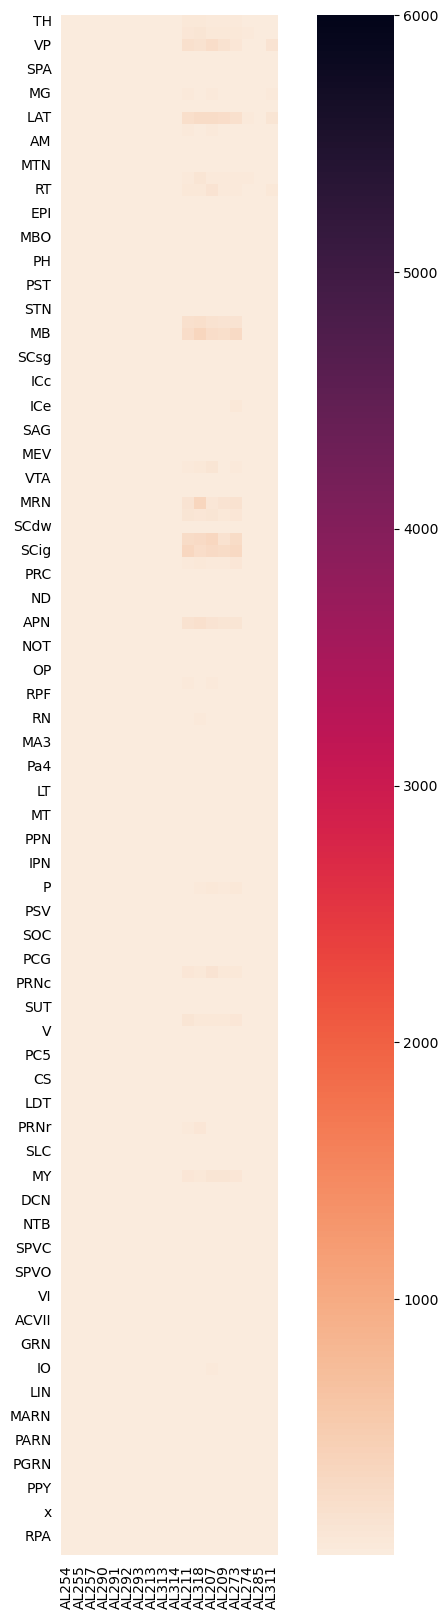

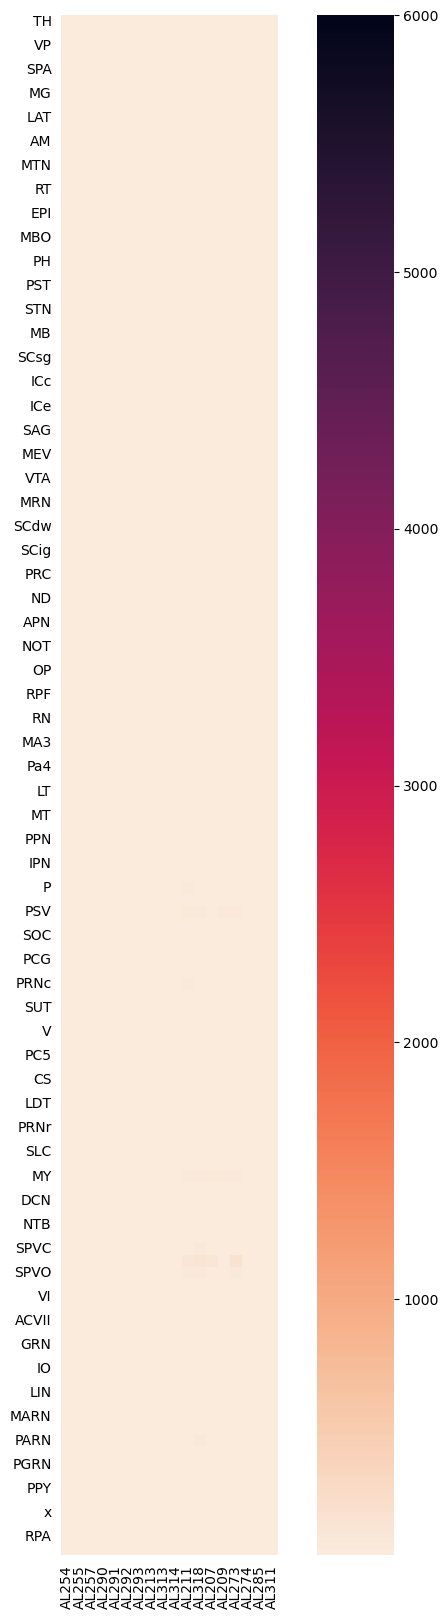

In [76]:
plot_lin(leftside,'left')
plot_lin(rightside,'right')

#### count number of innervated regions within the selection (ie. cerebral cortex 688)

In [7]:
if region== 's1':
    genotype_list= ['Rasgrf2dCre','Rasgrf2dCre','Rasgrf2dCre','Scnn1aCre','Scnn1aCre','Scnn1aCre','Scnn1aCre', 'Tlx3Cre','Tlx3Cre','Tlx3Cre',
                    'Rbp4Cre','Rbp4Cre', 'Sim1Cre','Sim1Cre','Sim1Cre', 'Ntsr1Cre','Ntsr1Cre','Ntsr1Cre']
else:
    genotype_list= ['Rasgrf2dCre','Rasgrf2dCre','Rasgrf2dCre','Scnn1aCre','Scnn1aCre', 'Scnn1aCre', 'Tlx3Cre','Tlx3Cre','Tlx3Cre',
                'Rbp4Cre','Rbp4Cre', 'Rbp4Cre', 'Sim1Cre','Sim1Cre','Sim1Cre', 'Sim1Cre', 'Ntsr1Cre','Ntsr1Cre','Ntsr1Cre']


In [8]:
left_regions_filtered= (axonal_df >= 1)

# filter values, only keep those with a value of 1 and above

left_region_count=left_regions_filtered[column_order].sum(axis=0)

In [9]:
right_regions_filtered= (axonal_df_r >= 1)

# filter values, only keep those with a value of 1 and above

right_region_count=right_regions_filtered[column_order].sum(axis=0)

In [10]:
data=pd.concat([left_region_count, right_region_count], axis=1)
# concatenate the left and righ side for plotting

data.reset_index(inplace= True)
data.rename(columns={'index':'sample_id', 0:'left', 1: 'right'}, inplace=True)

data['genotype'] = genotype_list


C:\Users\liu\AppData\Local\Temp\ipykernel_11752\3990327007.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax= sns.stripplot(data=data, x="left", y="genotype", palette="deep")


Text(0.5, 0, '# of regions_left')

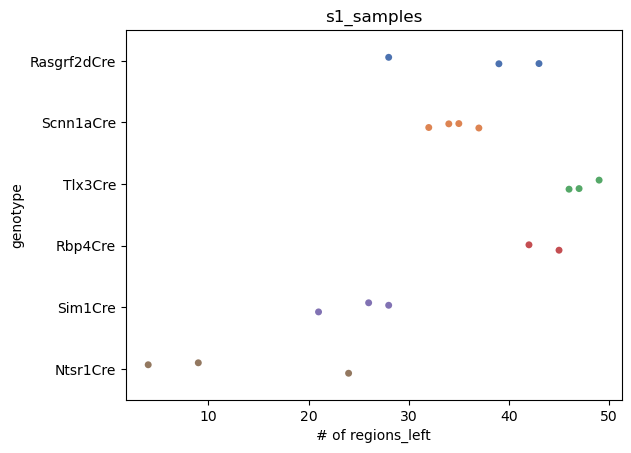

In [11]:
ax= sns.stripplot(data=data, x="left", y="genotype", palette="deep")
ax.set_title(f'{region}_samples')
ax.set_xlabel('# of regions_left')

C:\Users\liu\AppData\Local\Temp\ipykernel_11752\2570807693.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=data, x="right", y="genotype", palette="deep")


Text(0.5, 0, '# of regions_right')

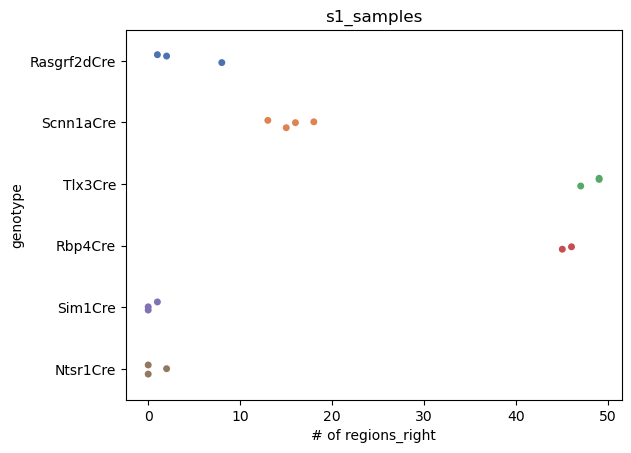

In [12]:
ax = sns.stripplot(data=data, x="right", y="genotype", palette="deep")
ax.set_title(f'{region}_samples')

ax.set_xlabel('# of regions_right')

Text(0.5, 1.0, 's1_samples')

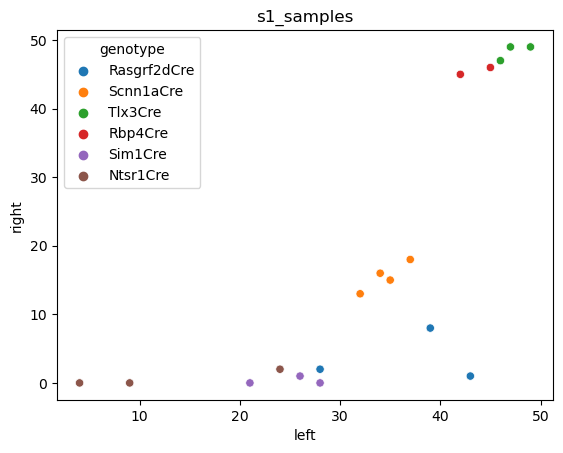

In [13]:
# alternatively, plot left vs right
ax=sns.scatterplot(x='left', y='right', hue='genotype',  data=data)
ax.set_title(f'{region}_samples')


### plotting correlation matrix with sns
for s1 or s2 samples

In [3]:
indir= r'D:\viral_results\s1_result'
outdir = r'D:\viral_results\s1_result'

In [4]:
column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314', 'AL211', 'AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of april .2023

#column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327', 'AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of june.2023

In [5]:
axons_L= [ i for i  in os.listdir(indir) if 'left_region' in i]
axonal_df_L= combine_df(indir, axons_L)
axonal_df_L.fillna(0, inplace=True)

#axonal_df_L=axonal_df_L.T

axonal_df_L_ordered=axonal_df_L[column_order]
#order



In [6]:
axons_R= [ i for i  in os.listdir(indir) if 'right_region' in i]
axonal_df_R= combine_df(indir, axons_R)
axonal_df_R.fillna(0, inplace=True)

#axonal_df_R=axonal_df_R.T

axonal_df_R_ordered=axonal_df_R[column_order]
#order

#axonal_df_R_ordered['AL310'][0]=0.00000
# No need to do this if plotting the full correlation (both hemispheres), only do this for plotting right hemisphere correlaiton
# because some brains(such as AL285) have nothing at all in the right hemisphere, correlation will show up as NAN and hence a blank row/column in heatmap
# just assign 1 to a random item so this does not happen

In [7]:
right_acronym= [i+'_right' for i in axonal_df_R.index]
axonal_df_R['acronym']=right_acronym

axonal_df_R.set_index('acronym', inplace=True)
#Rename everything on the right side to preserve some spatial info

In [8]:
full_df=pd.concat([axonal_df_L,axonal_df_R])
full_df=full_df[column_order]
#full_df

In [9]:
full_corr=full_df.corr()


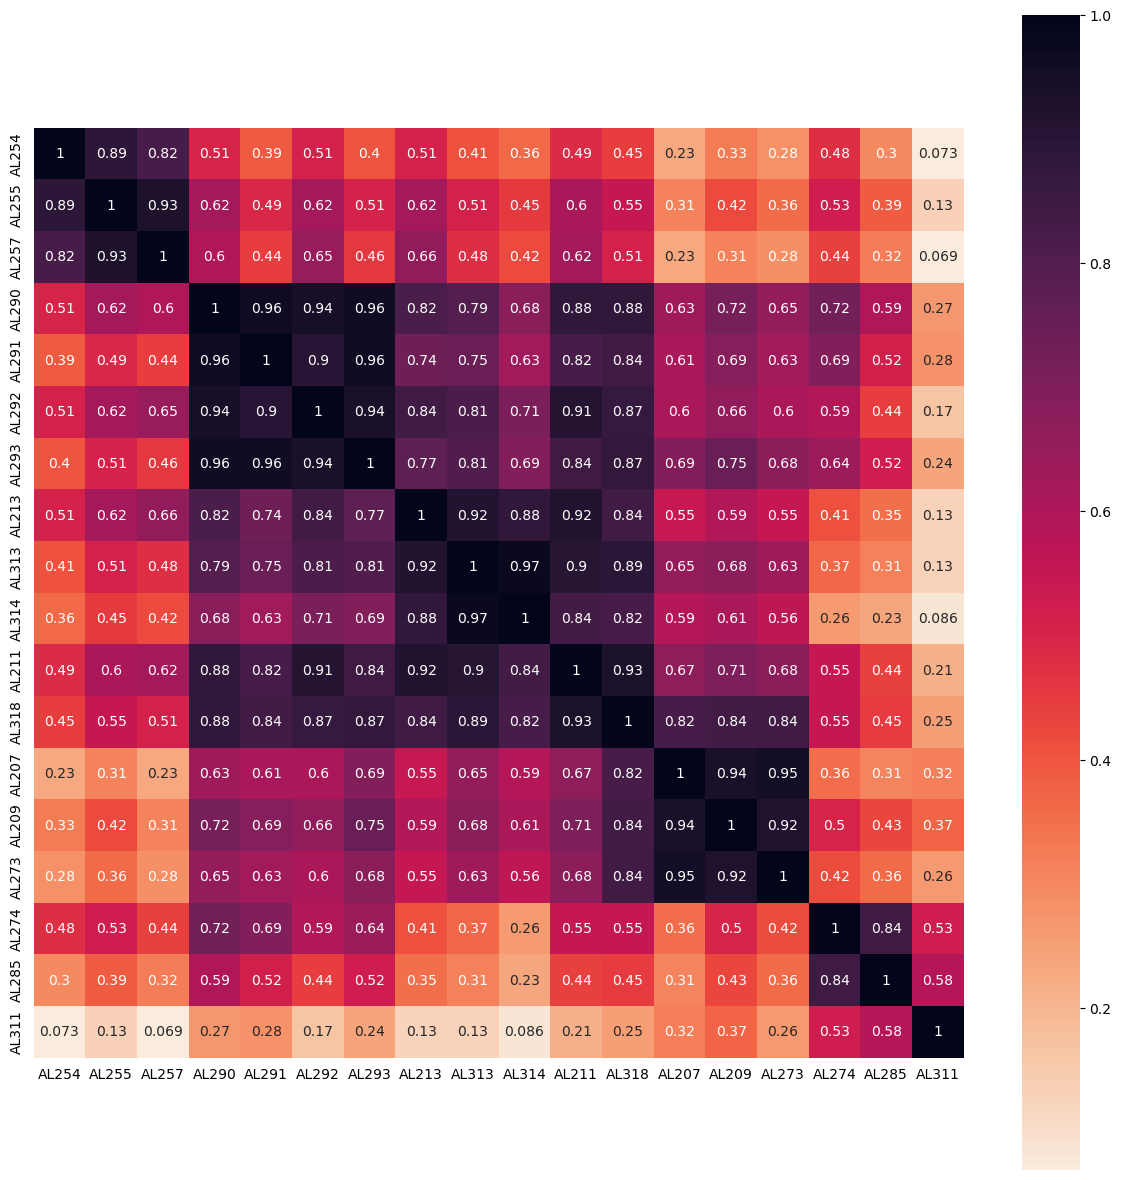

In [10]:

fig, ax = plt.subplots(figsize=(15,15))
g1=sns.heatmap(full_corr,  cmap="rocket_r", annot=True, square=True,linewidths=0.0, rasterized=True)
# set line width=0 and rasterized= true because when importing svg in illustrator, random whitelines are showing!

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\full_correlation.svg')
plt.show()

### plot correlation for all samples!
all s1 and all s2 samples together

In [3]:
indir= r'D:\viral_results\s1_result'
outdir = r'D:\viral_results\s1_result'

In [4]:
column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314','AL211','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of september .2023


In [5]:
axons_L= [ i for i  in os.listdir(indir) if 'left_region' in i]
axonal_df_L= combine_df(indir, axons_L)
axonal_df_L.fillna(0, inplace=True)

#axonal_df_L=axonal_df_L.T

#axonal_df_L_ordered=axonal_df_L[column_order]
#order


In [6]:

axons_R= [ i for i  in os.listdir(indir) if 'right_region' in i]
axonal_df_R= combine_df(indir, axons_R)
axonal_df_R.fillna(0, inplace=True)

#axonal_df_R=axonal_df_R.T

#axonal_df_R_ordered=axonal_df_R[column_order]
#order

right_acronym= [i+'_right' for i in axonal_df_R.index]
axonal_df_R['acronym']=right_acronym

axonal_df_R.set_index('acronym', inplace=True)
#Rename everything on the right side to preserve some spatial info

In [7]:
s1_df=pd.concat([axonal_df_L,axonal_df_R])
s1_df=s1_df[column_order]
#s1_df

In [8]:
indir= r'D:\viral_results\s2_result'
outdir = r'D:\viral_results\s2_result'

column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327', 'AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of june.2023

In [9]:
axons_L= [ i for i  in os.listdir(indir) if 'left_region' in i]
axonal_df_L= combine_df(indir, axons_L)
axonal_df_L.fillna(0, inplace=True)


In [10]:
axons_R= [ i for i  in os.listdir(indir) if 'right_region' in i]
axonal_df_R= combine_df(indir, axons_R)
axonal_df_R.fillna(0, inplace=True)

right_acronym= [i+'_right' for i in axonal_df_R.index]
axonal_df_R['acronym']=right_acronym

axonal_df_R.set_index('acronym', inplace=True)
#Rename everything on the right side to preserve some spatial info

In [11]:
s2_df=pd.concat([axonal_df_L,axonal_df_R])
s2_df=s2_df[column_order]

s2_df.rename(lambda x: x+'_s2', axis='columns', inplace=True)
# rename sample names with a _s2 indicator since some samples have 2 channels (ie. AL274)

In [12]:
all_df=pd.concat([s1_df,s2_df])

final_df=all_df.groupby(level=0).sum()
# since after concat, each index will show up twice if it exist in both s1 and s2 dataframes where the first row have actual s1 value but have 0 for s2, and second row ahve actual s2 values but s1 have zeros.
# Sum up values of rows with identical name (anatomical region) by using group by sum

In [13]:
final_df.columns

Index(['AL254', 'AL255', 'AL257', 'AL290', 'AL291', 'AL292', 'AL293', 'AL213',
       'AL313', 'AL314', 'AL211', 'AL318', 'AL207', 'AL209', 'AL273', 'AL274',
       'AL285', 'AL311', 'AL303_s2', 'AL332_s2', 'AL333_s2', 'AL290_s2',
       'AL292_s2', 'AL323_s2', 'AL278_s2', 'AL280_s2', 'AL319_s2', 'AL288_s2',
       'AL326_s2', 'AL327_s2', 'AL281_s2', 'AL286_s2', 'AL321_s2', 'AL322_s2',
       'AL274_s2', 'AL310_s2', 'AL330_s2'],
      dtype='object')

In [14]:
final_column_order= ['AL254', 'AL255', 'AL257','AL303_s2', 'AL332_s2', 'AL333_s2','AL290', 'AL291', 'AL292', 'AL293','AL290_s2', 'AL292_s2', 'AL323_s2',
                    'AL213','AL313', 'AL314','AL278_s2', 'AL280_s2', 'AL319_s2','AL211', 'AL318','AL288_s2', 'AL326_s2', 'AL327_s2',
                    'AL207', 'AL209', 'AL273','AL281_s2', 'AL286_s2', 'AL321_s2','AL322_s2','AL274', 'AL285', 'AL311','AL274_s2', 'AL310_s2', 'AL330_s2' ]
# reorder column so that samples from the same transgenic lines are close to each other
final_df=final_df[final_column_order]


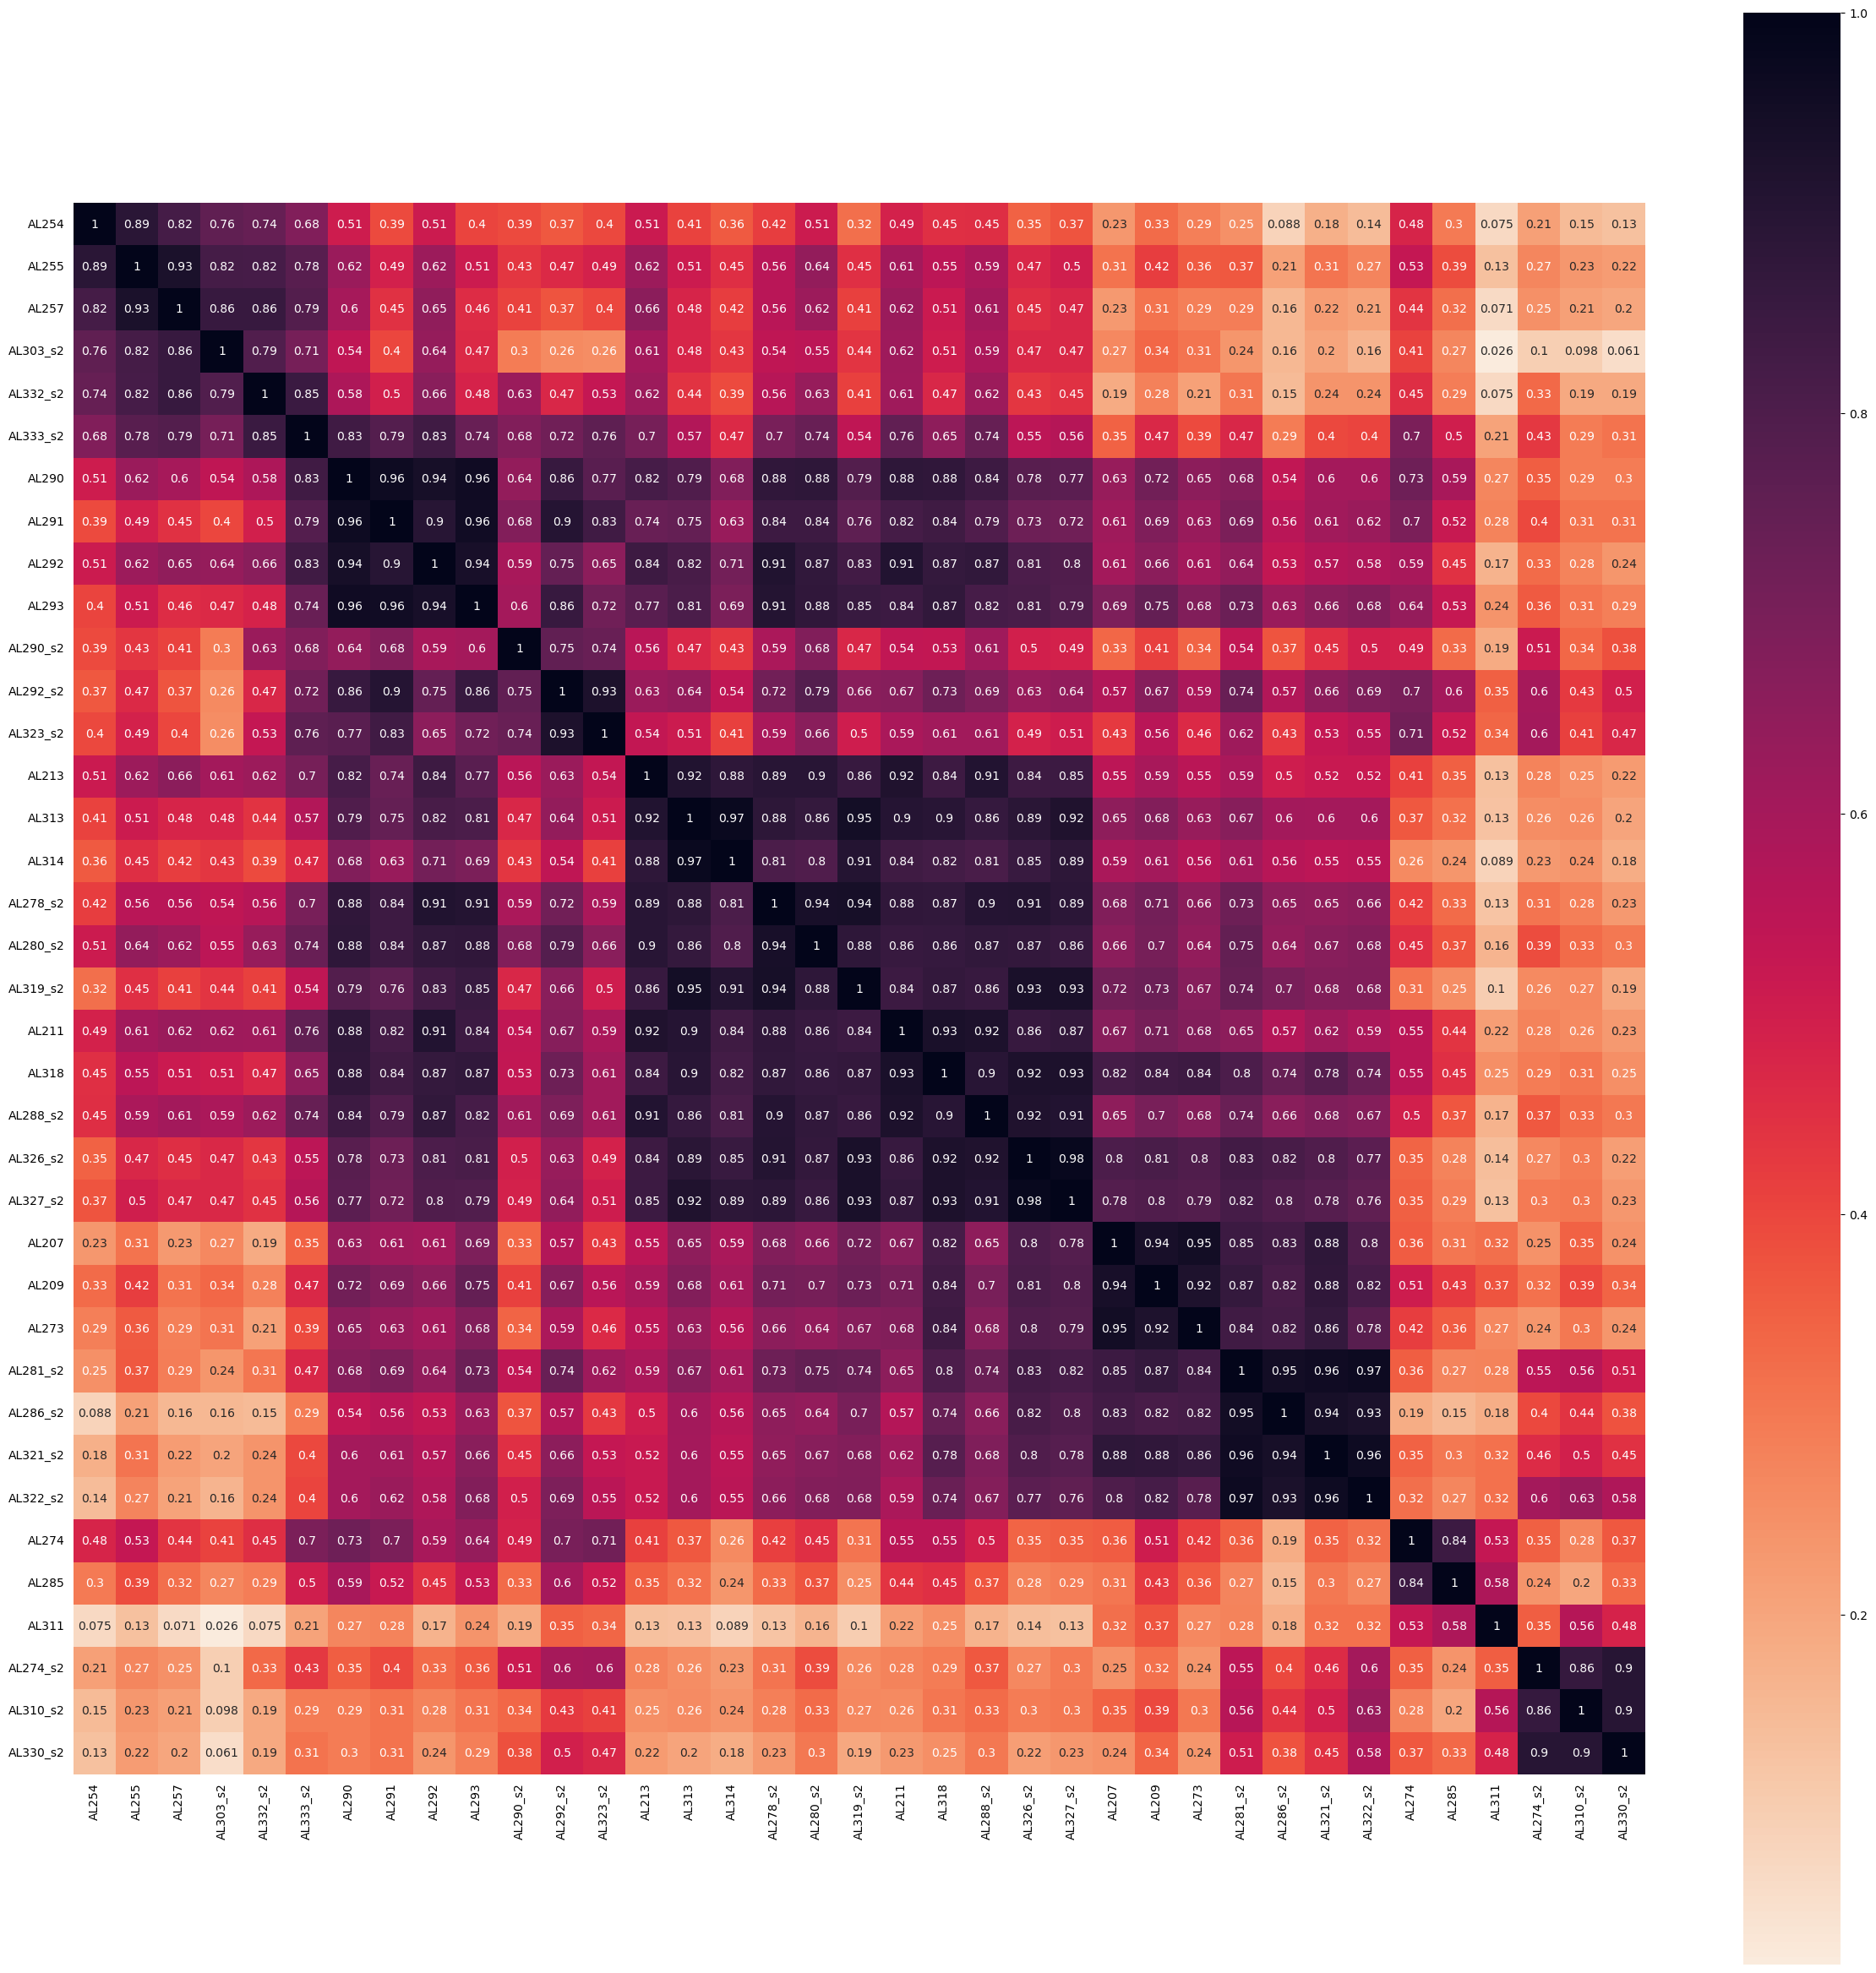

In [23]:
final_corr=final_df.corr()
fig, ax = plt.subplots(figsize=(30,30))
g1=sns.heatmap(final_corr,  cmap="rocket_r", annot=True, square=True,linewidths=0.0, rasterized=True)
# set line width=0 and rasterized= true because when importing svg in illustrator, random whitelines are showing!

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(r'D:\viral_results\s1_s2\all_correlation.svg')
plt.show()

### Section for big regions- depth 2 and 4 
Plot axons in broad groups as overview first

involved regions:


depth 2: 

    '/567/', cerebrum
    '/343/', brainstem
    '/512/', cerebellum


depth 4: 

    '/695/', cortical plate
    '/703/', cortical subplate
    '/477/', striatum
    '/803/', pallidum
    '/549/', thalamus
    '/1097/', hypothalamus
    '/339/', midrbain sensory related
    '/323/', midbrain motor related
    '/348/, midbrain behavioral state related
    '/771/', pons
    '/354/', medulla


not usefule now, depth 3: 

    '/528/', cerebellar cortex
    '/519/', cerebellar nuclei


In [21]:
def find_sample_list(df):
    '''Find list of sample's name from datafame column, ie: AL254, AL255, AL256'''
    sample_list= []

    for i in df.columns:
        m=re.search('\D{2}[0-9]{3}', i)
        if m: 
            sample_list.append(m[0])
    
    return sample_list

def sum_broad_group (df,sample_list, broad_group):
    '''from data frame, group structures by bigger regions, ie. cortical plate, cortical subplate, etc '''
        
    all_region=pd.DataFrame()

    for i in broad_group: 
        region_id= i
        choosen_regions= df.loc[df['structure_id_path'].str.contains(f'/{region_id}/', case=False)]

        this_region= atlas_labels[atlas_labels['id']==i]

        region_sum= []
        for j in sample_list:
            region_sum.append (choosen_regions[j].sum())

        this_region[sample_list]= region_sum
        this_region['sum']= sum(region_sum)

        all_region= pd.concat([all_region, this_region])
    
    return all_region


def extract_df(name_list,choosen_df, site):
    '''from data frame, extract only relevant information-> region acronyms and values from individual samples 
    then, insert injection site information (site = 's1' , or 's2')'''
    name_list.insert(0,'acronym')
    # insert acronym to the list to be used as extracting columns from df
    testdf=choosen_df[name_list]
    new=testdf.T
    #new

    new.columns =new.iloc[0]
    new=new.drop(new.index[0])
    # make the acronym row as column names, then drop the first row

    new['site']=site
    # add respective injection site info to each sample
    return new

def combine_expanddf (df1,df2):
    ''' combine two df , and prepare to sns barplot compatible format by pd.melt '''
    
    both_df= pd.concat([df1, df2])
    both_df=both_df.reset_index()

    site_column= both_df.pop('site')
    both_df.insert(1, "site", site_column, allow_duplicates=False)
    # some times the site column will not always be in the last position of column order after pd.concat, because some regions are not present in both averaged excel files
    # relocate the site column as the second in the column order(position 1) so in the next melt step we do not include it

    side_column= both_df.pop('side')
    both_df.insert(2, "side", side_column, allow_duplicates=False)

    expand1=pd.melt(both_df, id_vars=['index'], value_vars=both_df.columns[3:])
    # melt into sns preferred format
    to_repeat=len(both_df.columns)-3
    # need to repeat injection site list for x times, minus the index column, the site column, and the side column

    repeated_list=[]
    x=0
    while x<to_repeat:
        repeated_list.append(both_df['site'].to_list())
        x+=1

    new_list = itertools.chain(*repeated_list)
    new_list=list(new_list)
    len(new_list)
    # use itertool to flatten list of list, final length = number of sample * number of brain region


    repeated_list_side=[]
    y=0
    while y<to_repeat:
        repeated_list_side.append(both_df['side'].to_list())
        y+=1

    new_list_side = itertools.chain(*repeated_list_side)
    new_list_side=list(new_list_side)
    # use itertool to flatten list of list, final length = number of sample * number of brain region

    expand1['site']= new_list
    expand1['side']= new_list_side
# finally add the injection site information as a column
    
    return expand1

def grouped_bar(expanded_df,order):
    
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''

    sns.set(font_scale=2)

    fig, ax = plt.subplots(figsize=(20,10))

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        order=order,
        hue='site',
        palette="hls",
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        order=order,
        hue='site',
        palette="hls",
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.5),
    )

    ax.set(xlim=(0, 1))
    # use the same x range for all plots
    
    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!

    #plt.savefig(f'{outdir}\\{mouseline}_avg_big.svg')

    plt.show()

    
def bar_plot (expanded_df, order, side, depth, mouseline):
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''

    sns.set(font_scale=2)

    fig, ax = plt.subplots(figsize=(15,5))
    
    # keep x at 15, y at whatever depending on amount of acronym (ie, 5 for depth 4, 3 for depth 2)

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        order=order,
        hue='site',
        palette="hls",
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!
    
    g1.set(xlabel=None,ylabel=None)

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        order=order,
        hue='site',
        palette="hls",
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.5),
    )
    
    g2.set(xlabel=None, ylabel=None)

    
    #ax.set(xlim=(0, 1))
    # use the same x range for all plots. Used for previous version when normalized to total axon counts
    
    #ax.set_xscale('log')
    # use log or linear scale..
    ax.set(xlim=(0.001, 15500))
    # use the same x range for all plots. for current version where values are normalized to cell counts

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!

    plt.savefig(f'{outdir}\\{mouseline}_{depth}_{side}.svg')
    
    plt.show()

#### Section for big regions- non-mirrored bars depth 3 and 4 
DEPRECATED

previous section to plot left and right on the same bar

In [9]:
broad_group= [695, 703, 477, 803, 549, 1097, 339, 323, 348, 771, 354, 528, 519]
# plot data in broader groups

#broad_group= [315, 698, 1089]
# these are the regions within coprtical plate 695
# isocortex 315, olfactory areas 698, and hippocampal formation 1089


In [10]:
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

outdir= r'D:\\viral_results\\s1_s2'

mouseline='ras'
# could be ras, scn, tlx, sim, rbp, or nts
# change manually and run the following cells in the region

In [26]:
side='left'
# could be left or right

region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2

name_list1=find_sample_list(read_file)
#find the list of involved sample

big_df1= sum_broad_group (read_file,name_list1, broad_group)
# sum up regions that belong to the same broad group

df1= extract_df(name_list1,big_df1, region)
# extract only the useful informations

name_list2=find_sample_list(read_file2)
big_df2= sum_broad_group (read_file2,name_list2, broad_group)
df2= extract_df(name_list2,big_df2, region2)
# do the same for s2

df2['side']= side
df1['side']= side

expanded_left= combine_expanddf(df1,df2)
# combine the two dfs

In [12]:
side='right'
# read in the two data frames. these xlsx files are output of the section above 'Generate excel files for averaged brains based on excel file of each sample'
region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2

name_list1=find_sample_list(read_file)
#find the list of involved sample

big_df1= sum_broad_group (read_file,name_list1, broad_group)
# sum up regions that belong to the same broad group

dfr1= extract_df(name_list1,big_df1, region)
# extract only the useful informations

name_list2=find_sample_list(read_file2)
big_df2= sum_broad_group (read_file2,name_list2, broad_group)
dfr2= extract_df(name_list2,big_df2, region2)
# do the same for s2

dfr2['side']=side
dfr1['side']=side

expanded_right= combine_expanddf(dfr1,dfr2)

right_acronym= [i+'_r' for i in expanded_right['acronym']]
expanded_right['acronym']=right_acronym
# add identifier for the right hemisphere

expanded_both= pd.concat([expanded_left,expanded_right])
expanded_both=expanded_both.sort_values(by=['acronym'])
# sort by acronym so a given region from left and right are ordered together

In [13]:
expanded_both= pd.concat([expanded_left,expanded_right], ignore_index=True)
expanded_both=expanded_both.sort_values(by=['site'], ascending=False)
# sort by site first so that s1 is red and s2 is blue..consistent with other bar plots

In [14]:
order= ['CTXpl','CTXpl_r',
       'CTXsp','CTXsp_r',
       'STR','STR_r',
       'PAL','PAL_r',
       'TH','TH_r',
       'HY','HY_r',
       'MBsen','MBsen_r',
       'MBmot','MBmot_r',
        'MBsta','MBsta_r',
        'P','P_r',
        'MY','MY_r',
        'CBX','CBX_r',
        'CBN','CBN_r'
       ]
    
# order the bar graph so it make sense and left and right stay together

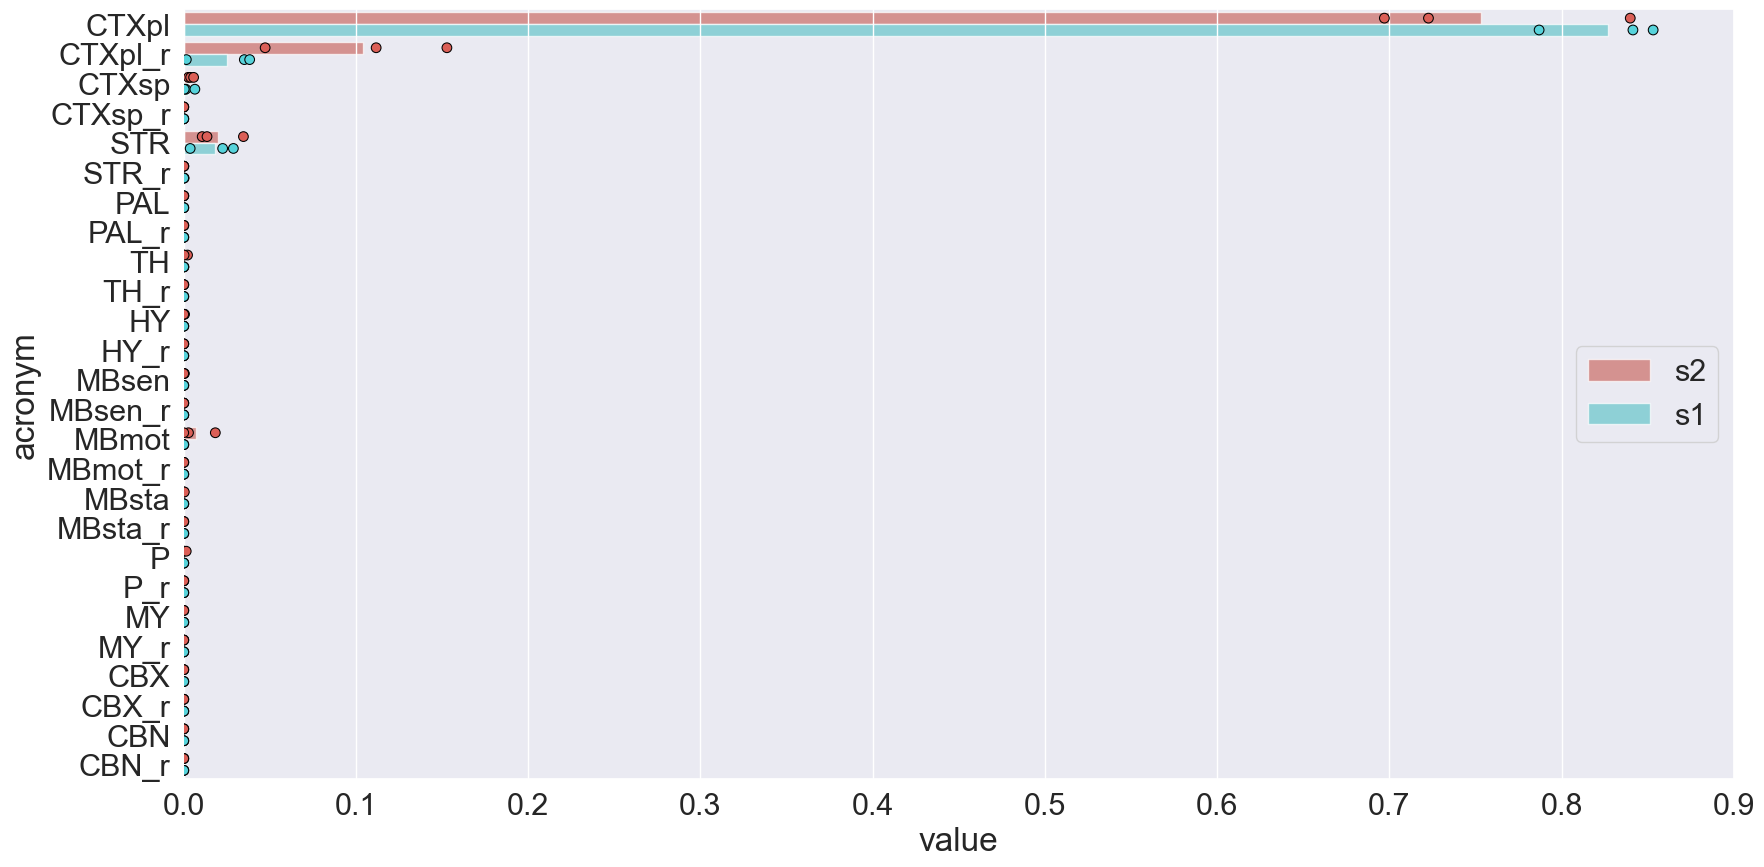

In [15]:
grouped_bar(expanded_both, order)

#### section to plot depth 2 and 4 mirrored bars for left and right

new update as of june 29 2023

In [10]:
def prepare_series(df, site, side, genotype):
    ''' extract values such as mean and sem, format in to list and append relevatne information
    useful for making excel sheets of group average and sem on different anatomical leveldepths'''
    
    list_mean= df.mean().values.tolist()
    list_mean.append(site)
    list_mean.append(side)
    list_mean.append(genotype)
    list_mean.append('mean')
    # extract values and add info sections

    list_sem= df.sem().values.tolist()
    list_sem.append(site)
    list_sem.append(side)
    list_sem.append(genotype)
    list_sem.append('sem')
    # extract values and add info sections
    
    return list_mean,list_sem
    

In [11]:
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')
outdir= r'D:\\viral_results\\s1_s2'


##### EXAMPLE section for detailed code  outside loop

In [4]:
depth = 4

mouseline='ras'
# could be ras, scn, tlx, sim, rbp, or nts

side= 'left'
# change manually and run the following cells in the region

In [124]:
if depth== 4:
    
    broad_group= [695, 703, 477, 803, 549, 1097, 339, 323, 348, 771, 354]
    # depth 4 plot order
    order= ['CTXpl','CTXsp','STR','PAL','TH','HY','MBsen','MBmot','MBsta','P','MY']
    
elif depth== 2: 
    # depth 2 order
    order= ['CH','BS', 'CB']
    broad_group= [567,343,512]

# identify which level of grouping is involved
# order the bar graph so it make sense and left and right stay together

In [125]:

region='s1'
file_path= f'D:\\viral_results\\{region}_average\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_average\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2

name_list1=find_sample_list(read_file)
#find the list of involved sample

big_df1= sum_broad_group (read_file,name_list1, broad_group)
# sum up regions that belong to the same broad group

df1= extract_df(name_list1,big_df1, region)
# extract only the useful informations

name_list2=find_sample_list(read_file2)
big_df2= sum_broad_group (read_file2,name_list2, broad_group)
df2= extract_df(name_list2,big_df2, region2)
# do the same for s2

df2['side']= side
df1['side']= side

expanded= combine_expanddf(df1,df2)
# combine the two dfs
expanded= expanded.sort_values(by=['site'], ascending=False)

#bar_plot (expanded, order, side, depth,mouseline)
#grouped_bar(expanded,order)

##### LOOP

In [5]:
### loooop!
depth = 2

mouseline=['ras', 'scn', 'tlx', 'sim', 'rbp', 'nts']
# could be ras, scn, tlx, sim, rbp, or nts

side= ['left', 'right']


In [6]:
if depth== 4:
    
    broad_group= [695, 703, 477, 803, 549, 1097, 339, 323, 348, 771, 354]
    # depth 4 plot order
    order= ['CTXpl','CTXsp','STR','PAL','TH','HY','MBsen','MBmot','MBsta','P','MY']
    
elif depth== 2: 
    # depth 2 order
    order= ['CH','BS', 'CB']
    broad_group= [567,343,512]

# identify which level of grouping is involved
# order the bar graph so it make sense and left and right stay together

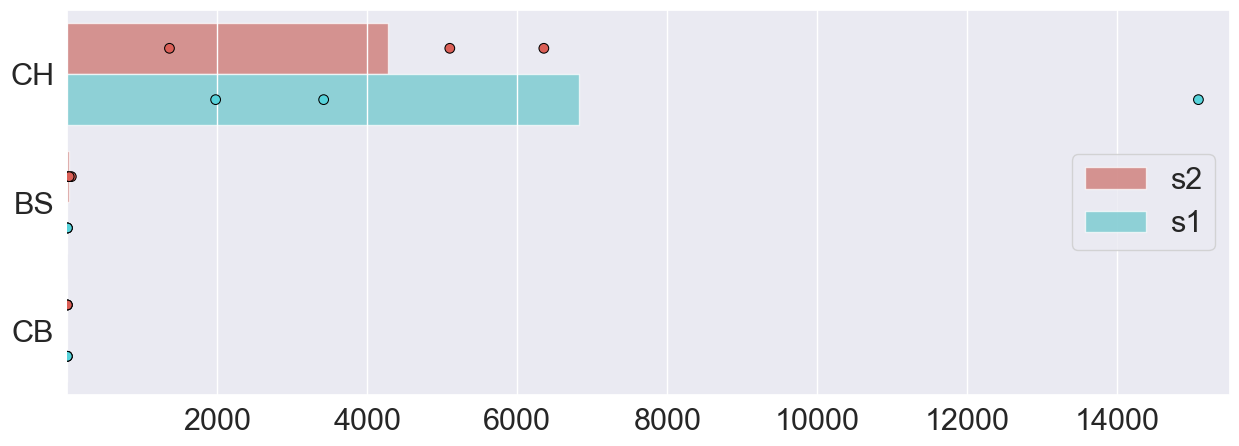

this is ras, left side
acronym            CH      BS   CB site  side
AL254     1977.506369     0.0  0.0   s1  left
AL255     3417.762963     0.0  0.0   s1  left
AL257    15081.411483  1.4689  0.0   s1  left


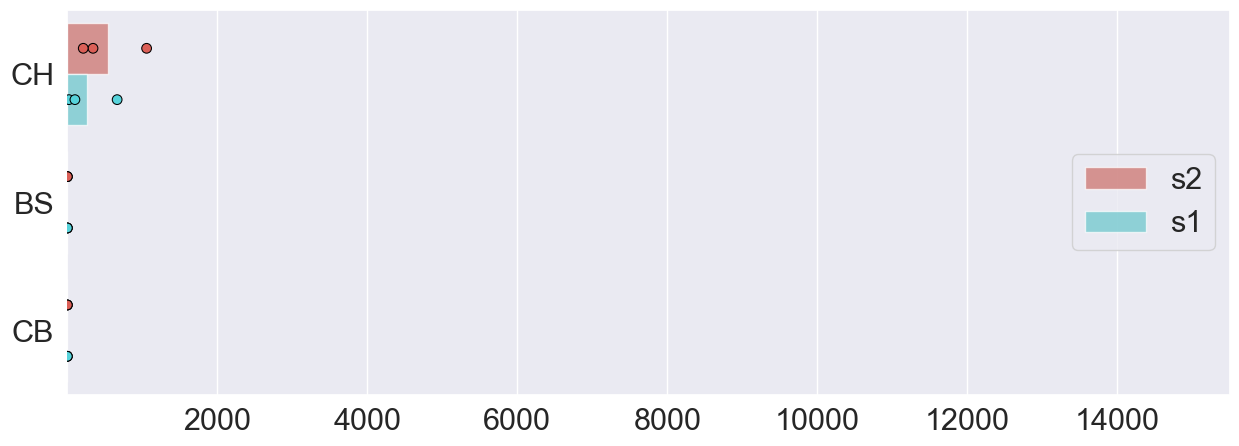

this is ras, right side
acronym          CH   BS   CB site   side
AL254    101.340764  0.0  0.0   s1  right
AL255     20.999259  0.0  0.0   s1  right
AL257    664.385167  0.0  0.0   s1  right


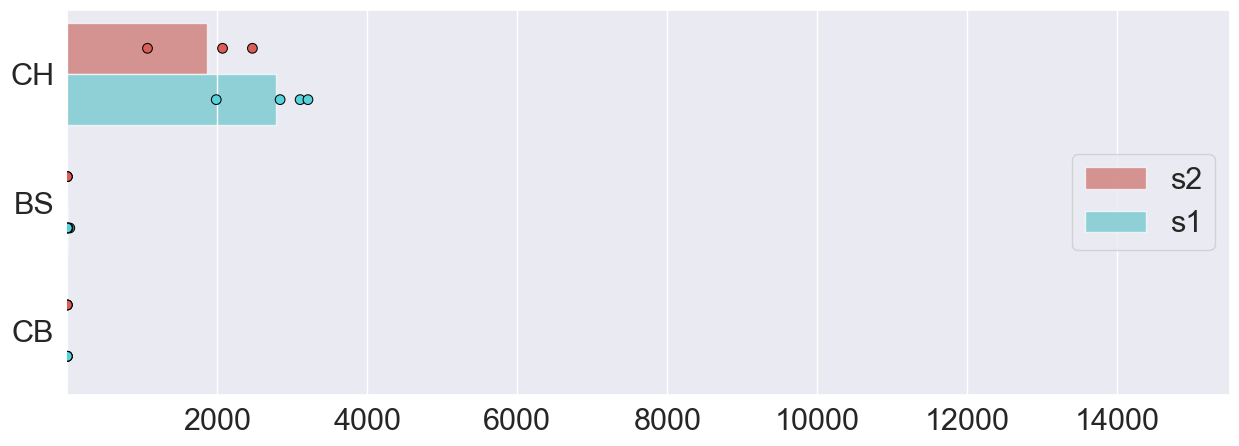

this is scn, left side
acronym           CH         BS   CB site  side
AL290    3104.108173        0.0  0.0   s1  left
AL291    1985.616822  10.222222  0.0   s1  left
AL292    2837.238519  32.979259  0.0   s1  left
AL293    3208.365764        0.0  0.0   s1  left


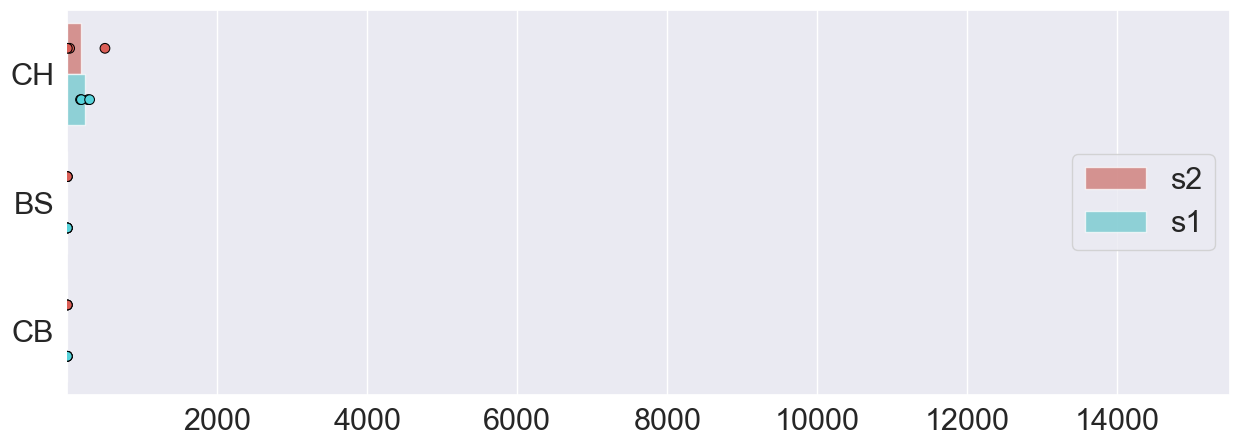

this is scn, right side
acronym          CH   BS   CB site   side
AL290    275.805288  0.0  0.0   s1  right
AL291    176.141225  0.0  0.0   s1  right
AL292        297.12  0.0  0.0   s1  right
AL293    187.520936  0.0  0.0   s1  right


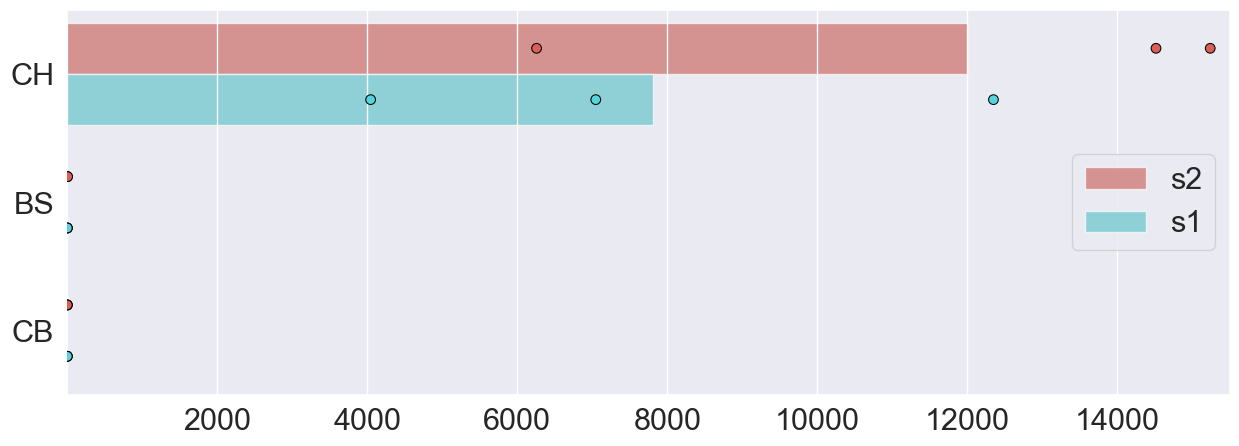

this is tlx, left side
acronym            CH   BS   CB site  side
AL213    12348.572198  0.0  0.0   s1  left
AL313     7046.149148  0.0  0.0   s1  left
AL314     4044.177093  0.0  0.0   s1  left


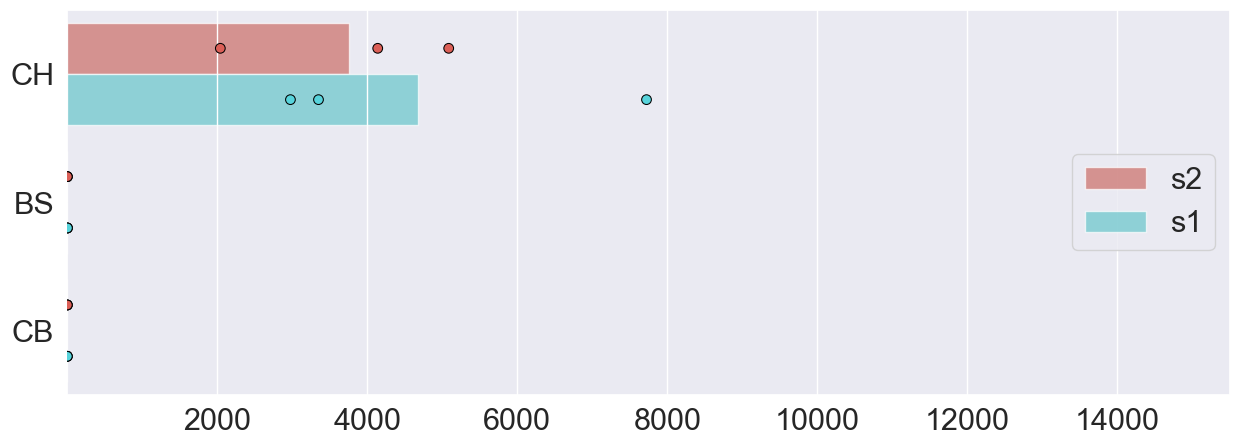

this is tlx, right side
acronym           CH        BS   CB site   side
AL213    7722.587284  0.001078  0.0   s1  right
AL313    3348.948864  2.272727  0.0   s1  right
AL314    2974.927753  1.607048  0.0   s1  right


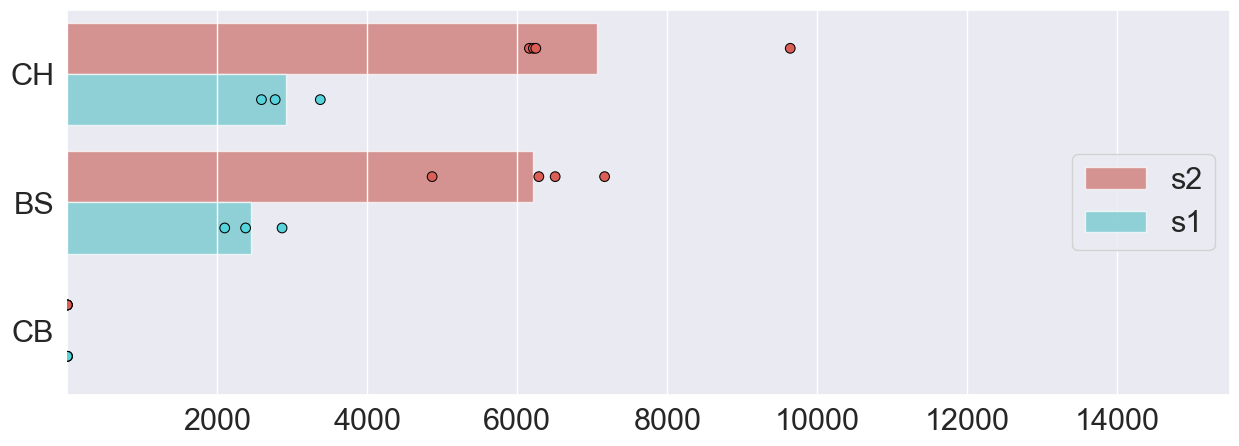

this is sim, left side
acronym           CH           BS        CB site  side
AL207    2771.358607  2863.418033  4.288934   s1  left
AL209    3373.093863  2098.429603       0.0   s1  left
AL273    2588.354108  2376.957507  0.002833   s1  left


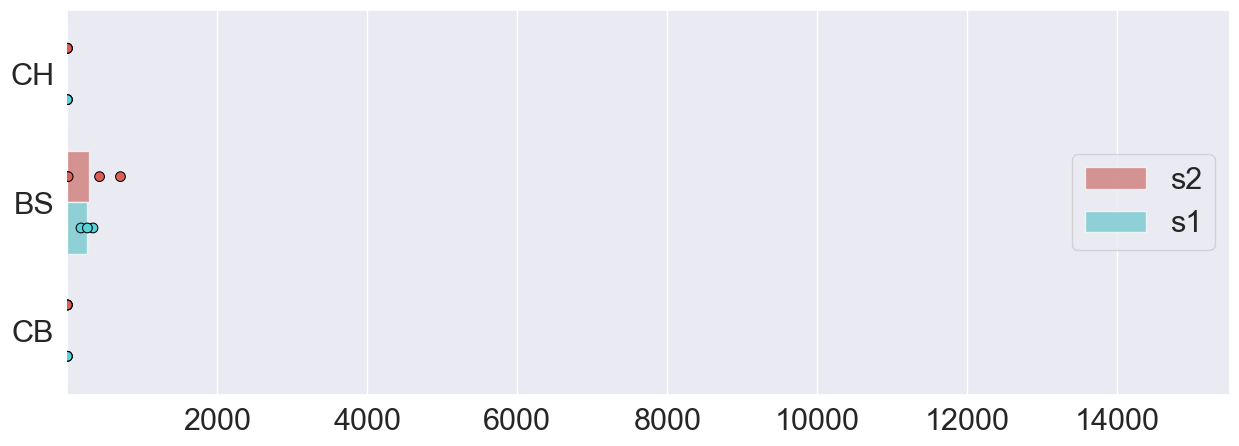

this is sim, right side
acronym        CH          BS        CB site   side
AL207    0.026639  267.717213  0.956967   s1  right
AL209    1.404332  182.198556  0.725632   s1  right
AL273    0.141643   342.11898       0.0   s1  right


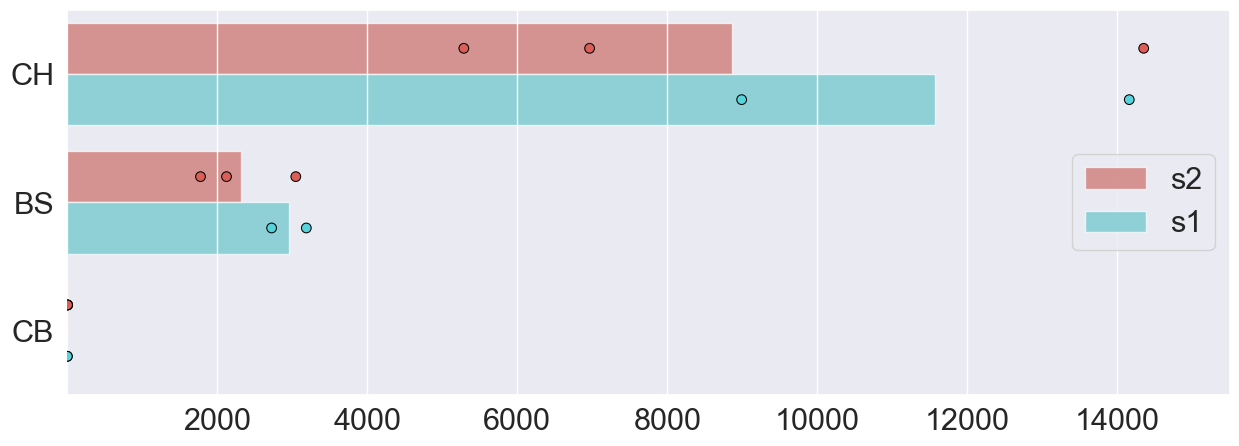

this is rbp, left side
acronym            CH           BS        CB site  side
AL211    14159.535783  2723.897485  1.119923   s1  left
AL318     8991.196998  3186.626642  0.011257   s1  left


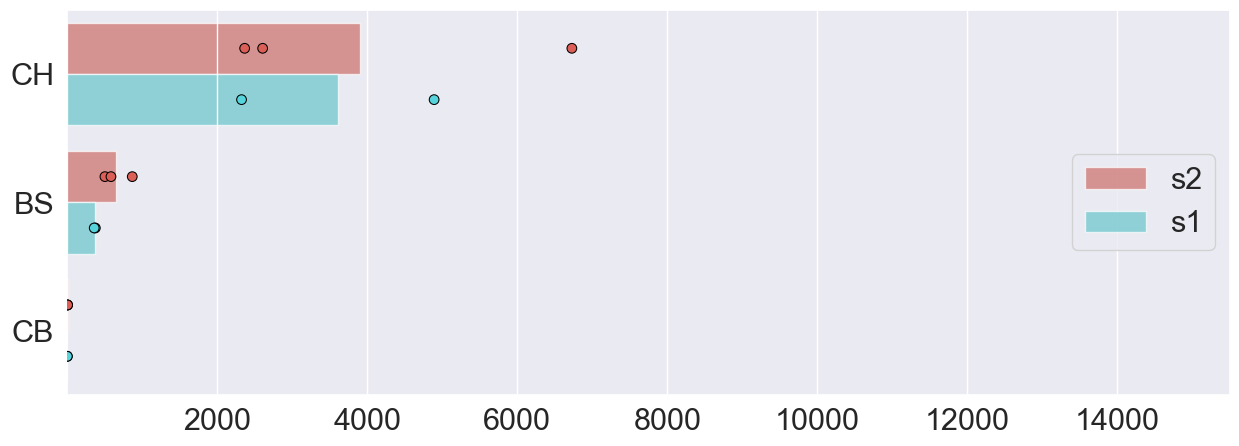

this is rbp, right side
acronym           CH          BS        CB site   side
AL211    4890.609284  373.481625  0.208897   s1  right
AL318    2322.949343  358.679174  0.187617   s1  right


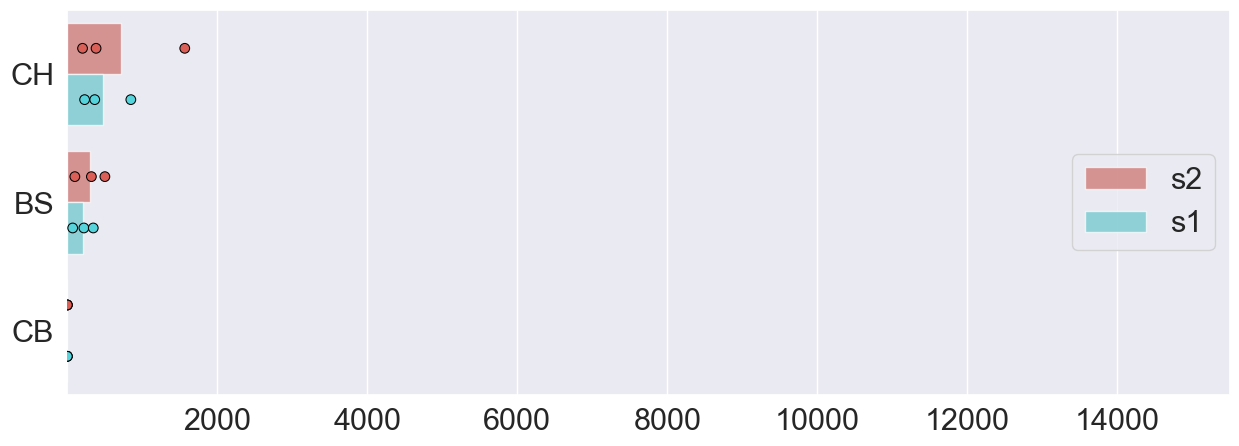

this is nts, left side
acronym          CH          BS   CB site  side
AL274    846.863854  220.921381  0.0   s1  left
AL285    365.537657   71.691946  0.0   s1  left
AL311    230.736842  345.871711  0.0   s1  left


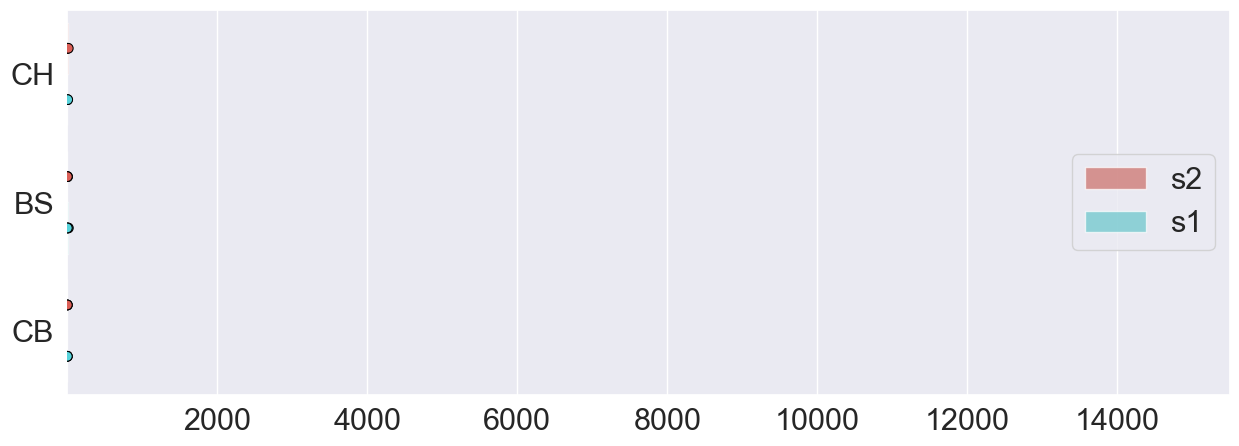

this is nts, right side
acronym       CH         BS   CB site   side
AL274    4.87488  13.871045  0.0   s1  right
AL285        0.0        0.0  0.0   s1  right
AL311        0.0        0.0  0.0   s1  right


In [22]:
## looping for bar plots!

for i in mouseline:
    
    for j in side:

        region='s1'
        file_path= f'D:\\viral_results\\{region}_average\\{region}_{i}_avg_{j}.xlsx'
        read_file= pd.read_excel(file_path)
        #read_file['injection']=region

        region2='s2'
        file_path2= f'D:\\viral_results\\{region2}_average\\{region2}_{i}_avg_{j}.xlsx'
        read_file2= pd.read_excel(file_path2)
        #read_file2['injection']=region2

        name_list1=find_sample_list(read_file)
        #find the list of involved sample

        big_df1= sum_broad_group (read_file,name_list1, broad_group)
        # sum up regions that belong to the same broad group

        df1= extract_df(name_list1,big_df1, region)
        # extract only the useful informations

        name_list2=find_sample_list(read_file2)
        big_df2= sum_broad_group (read_file2,name_list2, broad_group)
        df2= extract_df(name_list2,big_df2, region2)
        # do the same for s2

        df2['side']= j
        df1['side']= j

        expanded= combine_expanddf(df1,df2)
        # combine the two dfs
        expanded= expanded.sort_values(by=['site'], ascending=False)

        bar_plot (expanded, order, j, depth,i)
        
        print(f'this is {i}, {j} side')
        print(df1)


In [9]:
# this is for depth 4 because there are too many acronyms, so we need to write each genotype as one excel file 
# instead of all genotype and all side as big excel

d=[]
for i in mouseline:
    
    for j in side:

        region='s1'
        file_path= f'D:\\viral_results\\{region}_results\\{region}_{i}_avg_{j}.xlsx'
        read_file= pd.read_excel(file_path)
        #read_file['injection']=region

        region2='s2'
        file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{i}_avg_{j}.xlsx'
        read_file2= pd.read_excel(file_path2)
        #read_file2['injection']=region2

        name_list1=find_sample_list(read_file)
        #find the list of involved sample

        big_df1= sum_broad_group (read_file,name_list1, broad_group)
        # sum up regions that belong to the same broad group

        df1= extract_df(name_list1,big_df1, region)
        # extract only the useful informations

        name_list2=find_sample_list(read_file2)
        big_df2= sum_broad_group (read_file2,name_list2, broad_group)
        df2= extract_df(name_list2,big_df2, region2)
        # do the same for s2

        df2['side']= j
        df1['side']= j
        
        s1_mean,s1_sem=prepare_series(df1,'s1',j,i)
        s2_mean,s2_sem=prepare_series(df2,'s2',j,i)
        # put into series format
        
        d.append(s1_mean)
        d.append(s1_sem)
        d.append(s2_mean)
        d.append(s2_sem)
        
        # put into series format



C:\Users\liu\AppData\Local\Temp\ipykernel_9992\1181514939.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  list_mean= df.mean().values.tolist()
C:\Users\liu\AppData\Local\Temp\ipykernel_9992\1181514939.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  list_sem= df.sem().values.tolist()
C:\Users\liu\AppData\Local\Temp\ipykernel_9992\1181514939.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  list_mean= df.mean().values.tolist()
C:\Users\liu\AppData\Local\Temp\ipykernel_9992\118

In [10]:
mylist= df1.columns.tolist()
mylist.append('genotype')
mylist.append('what')
# create labels on genotype and what the data is (mean or sem)

In [11]:
df = pd.DataFrame(data=d)
df.columns=mylist
df

CH        BS        CB site   side genotype  what
0   0.848229  0.000029  0.000000   s1   left      ras  mean
1   0.028620  0.000029  0.000000   s1   left      ras   sem
2   0.777039  0.010532  0.000000   s2   left      ras  mean
3   0.050500  0.008856  0.000000   s2   left      ras   sem
4   0.025046  0.000000  0.000000   s1  right      ras  mean
5   0.011805  0.000000  0.000000   s1  right      ras   sem
6   0.103946  0.000000  0.000000   s2  right      ras  mean
7   0.030701  0.000000  0.000000   s2  right      ras   sem
8   0.843248  0.003471  0.000000   s1   left      scn  mean
9   0.011179  0.002271  0.000000   s1   left      scn   sem
10  0.814166  0.000000  0.000000   s2   left      scn  mean
11  0.116294  0.000000  0.000000   s2   left      scn   sem
12  0.069471  0.000000  0.000000   s1  right      scn  mean
13  0.007184  0.000000  0.000000   s1  right      scn   sem
14  0.094826  0.000000  0.000000   s2  right      scn  mean
15  0.089485  0.000000  0.000000   s2  right      scn   sem
16  0.562627  0.000000  0.000000   s1   left      tlx  mean
17  0.022919  0.000000  0.000000   s1   left      tlx   sem
18  0.704488  0.000155  0.000000   s2   left      tlx  mean
19  0.014728  0.000152  0.000000   s2   left      tlx   sem
20  0.333981  0.000134  0.000000   s1  right      tlx  mean
21  0.033386  0.000067  0.000000   s1  right      tlx   sem
22  0.222074  0.000014  0.000000   s2  right      tlx  mean
23  0.012465  0.000014  0.000000   s2  right      tlx   sem
24  0.444811  0.372843  0.000210   s1   left      sim  mean
25  0.037581  0.028060  0.000210   s1   left      sim   sem
26  0.446153  0.396519  0.000006   s2   left      sim  mean
27  0.024409  0.026424  0.000006   s2   left      sim   sem
28  0.000081  0.040428  0.000084   s1  right      sim  mean
29  0.000068  0.007447  0.000043   s1  right      sim   sem
30  0.000014  0.016047  0.000000   s2  right      sim  mean
31  0.000014  0.009287  0.000000   s2  right      sim   sem
32  0.555622  0.134895  0.000019   s1   left      rbp  mean
33  0.016422  0.028184  0.000014   s1   left      rbp   sem
34  0.513467  0.145015  0.000253   s2   left      rbp  mean
35  0.017672  0.015464  0.000043   s2   left      rbp   sem
36  0.197916  0.018681  0.000008   s1  right      rbp  mean
37  0.034810  0.001711  0.000002   s1  right      rbp   sem
38  0.219138  0.040590  0.000187   s2  right      rbp  mean
39  0.024844  0.004103  0.000081   s2  right      rbp   sem
40  0.636451  0.296825  0.000000   s1   left      nts  mean
41  0.140226  0.121341  0.000000   s1   left      nts   sem
42  0.602930  0.314568  0.000000   s2   left      nts  mean
43  0.057239  0.056062  0.000000   s2   left      nts   sem
44  0.001414  0.004025  0.000000   s1  right      nts  mean
45  0.001414  0.004025  0.000000   s1  right      nts   sem
46  0.001873  0.000466  0.000000   s2  right      nts  mean
47  0.001873  0.000466  0.000000   s2  right      nts   sem

In [12]:
df.to_excel(f'depth{depth}.xlsx')

#### test section for mannwhitneyu test



In [198]:
from scipy.stats import mannwhitneyu
# left side
side= 'left'

if side=='left':
    both_df= pd.concat([df1, df2])
elif side=='right':
    both_df= pd.concat([dfr1, dfr2])

both_df=both_df.reset_index()
# combine the two df from s1 and s2 first

site_column= both_df.pop('site')
both_df.insert(1, "site", site_column, allow_duplicates=False)
# always make sure that the first column is index and secon column is injection site

In [199]:
both_df

acronym  index site     CTXpl     CTXsp       STR       PAL        TH  \
0        AL211   s1  0.511199  0.000618  0.076011  0.000617  0.030343   
1        AL215   s1  0.482588  0.000626  0.056762   0.00024   0.02286   
2        AL318   s1  0.440368  0.001182  0.094433  0.002222  0.049533   
3        AL288   s2  0.469306  0.002701  0.063284  0.001423   0.01663   
4        AL326   s2  0.363326  0.006077  0.104773  0.004612  0.033848   
5        AL327   s2  0.413814  0.006576  0.100851  0.003658  0.026553   

acronym        HY     MBsen     MBmot     MBsta         P        MY       CBX  \
0        0.007712   0.00137   0.04795  0.000445  0.011423  0.004528       0.0   
1        0.006525  0.001887  0.041353  0.000279  0.010274  0.006221       0.0   
2        0.013987  0.001635  0.079628  0.000867   0.01781  0.006899       0.0   
3        0.007182  0.005513  0.040358  0.001561   0.01284  0.014514  0.000007   
4        0.011613  0.004603  0.057172  0.002409  0.016745  0.014102       0.0   
5         0.00951  0.007063  0.059012  0.003546    0.0259  0.011639  0.000011   

acronym       CBN  side  
0        0.000025  left  
1        0.000009  left  
2             0.0  left  
3        0.000078  left  
4        0.000189  left  
5        0.000134  left

In [207]:
s1 = both_df[both_df['site']=='s1']
s2 = both_df[both_df['site']=='s2']

class1=pd.to_numeric(s1['CTXpl'])
class2=pd.to_numeric(s2['CTXpl'])

#stats,pvalue= mannwhitneyu(class1, class2, alternative='two-sided',method='auto')
print(np.mean(class1))
print(np.std(class1))

0.47805172844693206
0.029093987368601876


In [203]:
f=open(f'{outdir}\\{mouseline}_avg_{side}_big.txt','w+')

for i in both_df.columns[2:-1]:
    # extract all acronyms, skips the first column which is the index(sample name) and second column which is the injection site
    # also remove the side column
    
    class1=pd.to_numeric(s1[i])
    class2=pd.to_numeric(s2[i])

    stats,pvalue= mannwhitneyu(class1, class2, alternative='two-sided',method='auto')

    print(f'{i}, p value = {pvalue}, stats= {stats} \n ')
    f.write(f'{i}, p value = {pvalue}, stats= {stats}\n ')

f.close()
    

CTXpl, p value = 0.2, stats= 8.0 
 
CTXsp, p value = 0.1, stats= 0.0 
 
STR, p value = 0.4, stats= 2.0 
 
PAL, p value = 0.2, stats= 1.0 
 
TH, p value = 0.7, stats= 6.0 
 
HY, p value = 1.0, stats= 4.0 
 
MBsen, p value = 0.1, stats= 0.0 
 
MBmot, p value = 1.0, stats= 5.0 
 
MBsta, p value = 0.1, stats= 0.0 
 
P, p value = 0.4, stats= 2.0 
 
MY, p value = 0.1, stats= 0.0 
 
CBX, p value = 0.19670560245894686, stats= 1.5 
 
CBN, p value = 0.1, stats= 0.0 
 


In [205]:
## try just t test??
from scipy.stats import ttest_ind

for i in both_df.columns[2:-1]:
    # extract all acronyms, skips the first column which is the index(sample name) and second column which is the injection site
    # also remove the side column
    
    class1=pd.to_numeric(s1[i])
    class2=pd.to_numeric(s2[i])

    stats,pvalue= ttest_ind(class1, class2, equal_var=False)

    print(f'{i}, p value = {pvalue}, stats= {stats} \n ')

CTXpl, p value = 0.17509021010566983, stats= 1.696718192219486 
 
CTXsp, p value = 0.0681336599078588, stats= -3.500319154913961 
 
STR, p value = 0.4640045214867387, stats= -0.811864564996618 
 
PAL, p value = 0.13333018919982126, stats= -1.9624290220668983 
 
TH, p value = 0.42165201515303385, stats= 0.9134239929584765 
 
HY, p value = 0.9924303506166708, stats= -0.010266661719530975 
 
MBsen, p value = 0.025350712006681722, stats= -5.584845462100573 
 
MBmot, p value = 0.7755422127667884, stats= 0.31236603309387806 
 
MBsta, p value = 0.06467877900598434, stats= -3.285922988391271 
 
P, p value = 0.31716975441891676, stats= -1.1771056733998344 
 
MY, p value = 0.0032994767406353247, stats= -6.602188878384259 
 
CBX, p value = 0.20108309172274022, stats= -1.8785522610403718 
 
CBN, p value = 0.055112468161783244, stats= -3.739396437881803 
 


### section to plot bar graphs- a given region for s1 vs s2 comparison

layers combined!

isocortex 315

in grouped bar, have color specification -> useful for other bar plots

updated July 03 2023:
    
    matching acronym for left and right hemisphere even if its 0 for many, for direct mirroring comparison


In [3]:
def find_sample_list(df):
    '''Find list of sample's name from datafame column, ie: AL254, AL255, AL256'''
    sample_list= []

    for i in df.columns:
        m=re.search('\D{2}[0-9]{3}', i)
        if m: 
            sample_list.append(m[0])
    
    return sample_list

def norm_region(df, df_r, sample_list):
    
    ''' Normalize values by the sum of the column. Usefuly if all the rows in the data frame belongs to the parent region that wants to be normalized to'''
    
    region_sum= df.sum()[sample_list]
     # calculate sum across all rows for a given column since everything isocortex related is already extracted
    # find total isocortex values in left hemisphere

    region_sum_r= df_r.sum()[sample_list]
    # find total isocortex values in right hemisphere

    all_isocortex=region_sum+region_sum_r
    # add these up

    norm_values= df[sample_list]/all_isocortex
    # divide left side to normalize
    df[sample_list]= norm_values

    norm_values_r= df_r[sample_list]/all_isocortex
    # divide right side to normalize
    df_r[sample_list]= norm_values_r

    return df, df_r


def prepare_parent(df, sample_list):
    test=df.groupby(['parent_structure_id'],as_index=False)[sample_list].sum()
    # group each region based on parent structure id so that layers are combined and values summed
    # here the [sample_list] is stated explicitly because pandas will drop nuisance columns when doing groupby

    parent_structureid= test.pop('parent_structure_id')
    # store the parent structure id and remove it from the df
    #test['id']=parent_structureid
    # now the id of each acronym is its parent id

    extract_sample=test[sample_list]
    # extract only the sample names and assign to new data frame
    extract_sample['id']=parent_structureid
    # add the id to this new data frame so next we can merge with atlas label

    result = pd.merge(extract_sample, atlas_labels, on=["id"])
    # merge with atlas label on id, now all information is true such that we can do further grouping, ordering, etc based on this data frame
    
    return result
    
def extract_df(name_list,choosen_df, site):
    '''from data frame, extract only relevant information-> region acronyms and values from individual samples 
    then, insert injection site information (site = 's1' , or 's2')'''
    name_list.insert(0,'acronym')
    # insert acronym to the list to be used as extracting columns from df
    testdf=choosen_df[name_list]
    new=testdf.T
    #new

    new.columns =new.iloc[0]
    new=new.drop(new.index[0])
    # make the acronym row as column names, then drop the first row

    new['site']=site
    # add respective injection site info to each sample
    return new

def combine_expanddf (df1,df2):
    ''' combine two df , and prepare to sns barplot compatible format by pd.melt '''
    
    both_df= pd.concat([df1, df2])
    both_df=both_df.reset_index()
    
    site_column= both_df.pop('site')
    both_df.insert(1, "site", site_column, allow_duplicates=False)
    # some times the site column will not always be in the last position of column order after pd.concat, because some regions are not present in both averaged excel files
    # relocate the site column as the second in the column order(position 1) so in the next melt step we do not include it
    
    expand1=pd.melt(both_df, id_vars=['index'], value_vars=both_df.columns[2:])
    # melt into sns preferred format
    to_repeat=len(both_df.columns)-2
    # need to repeat injection site list for x times, minus the index column and the site column

    repeated_list=[]
    x=0
    while x<to_repeat:
        repeated_list.append(both_df['site'].to_list())
        x+=1
    
    new_list = itertools.chain(*repeated_list)
    new_list=list(new_list)
    len(new_list)
    # use itertool to flatten list of list, final length = number of sample * number of brain region

    expand1['site']= new_list
    # finally add the injection site information as a column
    
    return expand1


def grouped_bar(expanded_df,order, side):
    
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''
    
    color= [sns.hls_palette()[0],sns.hls_palette()[3]] 
    # specify the color template so that  s1 is always hls palette 3 (a cyan like color) and s2 is always hls palette 0 (a reddish color)
    # here we indicate s2 first because usually the bar graphs show s2 first (data frame sort_values by site, ascending=False)

    sns.set(font_scale=2)

    fig, ax = plt.subplots(figsize=(20,15))
    # (width, height)

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        hue='site',
        palette=color,
        order=order,
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )
    
    g1.set(xlabel=None, ylabel=None)

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        hue='site',
        palette=color,
        order=order,
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.9),
    )
    
    g2.set(xlabel=None, ylabel=None)
    
    ax.set(xlim=(0, 0.8))
    # do not change this xlim for this plot

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!
    
    plt.savefig(f'{outdir}\\{mouseline}_avg_{side}_{region_id}_parent.svg')

    plt.show()

In [4]:
outdir= r'D:\\viral_results\\s1_s2'
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

mouseline='ras'
# could be ras, scn, tlx, rbp, sim, or nts
# dont forget to change the xlim range accordingly for each line- ras 0.4  sim 0.6, scn0.4 rbp 0.3, tlx 0.2, nts 0.8

region_id='315'
# isocortex

In [16]:
side='left'

# read in the two data frames. these xlsx files are output of the section above 'Generate excel files for averaged brains based on excel file of each sample'
region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2

choosen_regions= read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]

choosen_regions= choosen_regions.sort_values('graph_order', ascending=True)
# sort based on the graph order so more related regions are together

# repeat the same for s2
choosen_regions2= read_file2.loc[read_file2['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions2= choosen_regions2.sort_values('graph_order', ascending=True)


In [17]:
# now load and prepare data from right side
side='right'

# read in the two data frames. these xlsx files are output of the section above 'Generate excel files for averaged brains based on excel file of each sample'
region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)

choosen_regions_r= read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions_r= choosen_regions_r.sort_values('graph_order', ascending=True)
# sort based on the graph order so more related regions are together

# repeat the same for s2
choosen_regions2_r= read_file2.loc[read_file2['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions2_r= choosen_regions2_r.sort_values('graph_order', ascending=True)

In [7]:
s1_list=find_sample_list(choosen_regions)
s2_list=find_sample_list(choosen_regions2)
# find relevant samples list 

In [20]:
s1_norm, s1_norm_r=norm_region(choosen_regions,choosen_regions_r, s1_list)
# normalize values to the total axons in both isocortexes, return left and right data frames
s2_norm, s2_norm_r=norm_region(choosen_regions2, choosen_regions2_r, s2_list)
# repeat for s2 injections

# summ up layer info for s1, left and right kept in separate data frames
s1_parent= prepare_parent(s1_norm, s1_list)
s1_parent_r= prepare_parent(s1_norm_r, s1_list)
s1_parent.sort_values(by='graph_order', inplace=True)
#sort by graph order so regions that make sense are together

# summ up layer info for s2, left and right
s2_parent= prepare_parent(s2_norm, s2_list)
s2_parent_r= prepare_parent(s2_norm_r, s2_list)
s2_parent.sort_values(by='graph_order', inplace=True)


In [26]:
s1_parent

AL254     AL255         AL257         id  atlas_id  \
6   0.000000  0.001363  2.025766e-03        184     871.0   
32  0.052369  0.049751  8.944011e-02        985     830.0   
33  0.251746  0.298548  3.842818e-01        993     831.0   
10  0.000271  0.002358  1.522450e-02        353     751.0   
7   0.076024  0.123579  7.398457e-02        329     748.0   
8   0.031702  0.017604  1.073809e-02        337     749.0   
9   0.000027  0.000047  9.207286e-04        345     750.0   
12  0.046958  0.016822  3.125804e-02        369     753.0   
11  0.016930  0.010590  2.407083e-03        361     752.0   
39  0.020932  0.008514  2.302603e-02  182305689       NaN   
13  0.112684  0.119794  1.498007e-01        378     754.0   
38  0.000000  0.000221  2.328279e-05       1057     131.0   
22  0.015019  0.009452  2.333913e-02        677     367.0   
35  0.016836  0.041803  8.271904e-03       1011     833.0   
34  0.012275  0.020361  6.783271e-03       1002     832.0   
37  0.001929  0.002683  1.167070e-03       1027     835.0   
36  0.014489  0.026288  9.077521e-03       1018     834.0   
16  0.006858  0.015671  2.195584e-03        402     757.0   
15  0.000304  0.001772  7.684950e-05        394     756.0   
17  0.002541  0.003384  4.781927e-04        409     758.0   
14  0.004572  0.003732  3.194464e-04        385     755.0   
19  0.000000  0.000000  4.347207e-05        425     760.0   
20  0.000054  0.000205  6.512669e-07        533     915.0   
41  0.000959  0.001431  6.846443e-04  312782574       NaN   
42  0.002998  0.004692  2.265758e-03  312782628       NaN   
0   0.012024  0.015540  6.930945e-03         39       4.0   
2   0.000000  0.000305  0.000000e+00         48       5.0   
31  0.000405  0.007653  1.973339e-03        972     262.0   
1   0.000000  0.000404  3.072352e-04         44     146.0   
23  0.000000  0.002630  8.394831e-04        723     231.0   
24  0.000000  0.002360  2.313626e-04        731     232.0   
25  0.000000  0.004521  8.267834e-04        746     234.0   
3   0.000000  0.002547  8.643940e-04        104      12.0   
4   0.002399  0.008897  3.780279e-03        111      13.0   
5   0.000000  0.002745  8.982599e-04        119      14.0   
28  0.001453  0.001390  4.070418e-05        894     394.0   
26  0.000962  0.000651  2.914419e-05        879     392.0   
27  0.000580  0.000675  4.363488e-05        886     393.0   
40  0.053644  0.022722  7.966948e-03  312782546       NaN   
18  0.091976  0.035772  1.713744e-02        417     759.0   
21  0.042102  0.059310  2.526330e-02        541     350.0   
30  0.020346  0.013917  1.460906e-02        922     256.0   
29  0.038537  0.036877  4.233056e-02        895     111.0   

                                          name  acronym  st_level  \
6                Frontal pole, cerebral cortex      FRP         8   
32                          Primary motor area      MOp         8   
33                        Secondary motor area      MOs         8   
10            Primary somatosensory area, nose    SSp-n         9   
7     Primary somatosensory area, barrel field  SSp-bfd         9   
8       Primary somatosensory area, lower limb   SSp-ll         9   
9            Primary somatosensory area, mouth    SSp-m         9   
12      Primary somatosensory area, upper limb   SSp-ul         9   
11           Primary somatosensory area, trunk   SSp-tr         9   
39      Primary somatosensory area, unassigned   SSp-un         9   
13             Supplemental somatosensory area      SSs         8   
38                             Gustatory areas       GU         6   
22                               Visceral area     VISC         8   
35                        Dorsal auditory area     AUDd         8   
34                       Primary auditory area     AUDp         8   
37                     Posterior auditory area    AUDpo         8   
36                       Ventral auditory area     AUDv         8   
16                   Anterolateral visual area    VISal         8   
15         

In [9]:
s1_df= extract_df(s1_list, s1_parent,'s1')
s2_df= extract_df(s2_list, s2_parent,'s2')
# extract only sample name, values and acronym, fill in injection site info

s1_df_r= extract_df(s1_list, s1_parent_r,'s1')
s2_df_r= extract_df(s2_list, s2_parent_r,'s2')
# repeat for right side

In [10]:
# prepare to combine the two sides
leftside=pd.concat([s1_df,s2_df])
rightside= pd.concat([s1_df_r, s2_df_r])

both=pd.concat([leftside,rightside])
both.fillna(value=0, inplace=True)
# concatinate two side so all region show up in both side, that is filled with zero

side_column= both.pop('site')
both.insert(0, "site", side_column, allow_duplicates=False)
# such that site info is always at index 0

#order=both.columns[1:]# extract appropriate column order excluding the first column (site, index 0) for plotting

In [11]:
test=atlas_labels.merge(pd.DataFrame(both.columns[1:]), on='acronym', how='inner')
order=test.sort_values(by='graph_order')['acronym']

#order=order.to_list()

# confirm region ordering by taking the involved acronym, inner merge with atlas labels then order by graph order


In [14]:
leftside

acronym site       FRP       MOp       MOs     SSp-n   SSp-bfd    SSp-ll  \
AL274     s1  0.000319  0.031344  0.188341  0.010752  0.438673  0.015930   
AL285     s1  0.000000  0.019736  0.192185  0.011332  0.690660  0.003545   
AL311     s1  0.000000  0.000000  0.000000  0.000000  0.778023  0.000000   
AL274     s2  0.000000  0.008724  0.002621  0.000511  0.132188  0.018415   
AL310     s2  0.000000  0.021429  0.042212  0.000000  0.115196  0.002079   
AL330     s2  0.000000  0.000000  0.000000  0.005423  0.275418  0.000000   

acronym     SSp-m    SSp-ul    SSp-tr  ...    RSPagl      RSPd      RSPv  \
AL274    0.000085  0.021161  0.013953  ...  0.000290  0.001261  0.000644   
AL285    0.001396  0.015921  0.001641  ...  0.000000  0.000000  0.000000   
AL311    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
AL274    0.000063  0.034578  0.060011  ...  0.001252  0.000000  0.000000   
AL310    0.000000  0.008228  0.000201  ...  0.000000  0.000000  0.000000   
AL330    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

acronym      VISa     VISrl       TEa       ECT        GU       AId       AIv  
AL274    0.017526  0.042505  0.008981  0.000015  0.000000  0.000000  0.000000  
AL285    0.001376  0.003729  0.000000  0.000000  0.000000  0.000000  0.000000  
AL311    0.000000  0.064789  0.000000  0.000000  0.000000  0.000000  0.000000  
AL274    0.017837  0.006914  0.007641  0.000152  0.000493  0.000224  0.000065  
AL310    0.000291  0.000127  0.000000  0.000000  0.000000  0.000000  0.000000  
AL330    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[6 rows x 40 columns]

In [13]:
leftindex= int(len(both)/2)
#split the length of both data frame in half , since the first half is always left hemisphere and later half always right hemisphere

leftside= both.iloc[0:leftindex]
rightside=both.iloc[leftindex:]

expanded= combine_expanddf(leftside[leftside.site=='s1'],leftside[leftside.site=='s2'])
expanded_r= combine_expanddf(rightside[rightside.site=='s1'],rightside[rightside.site=='s2'])
# expand in to bar+ strip plot format using melt

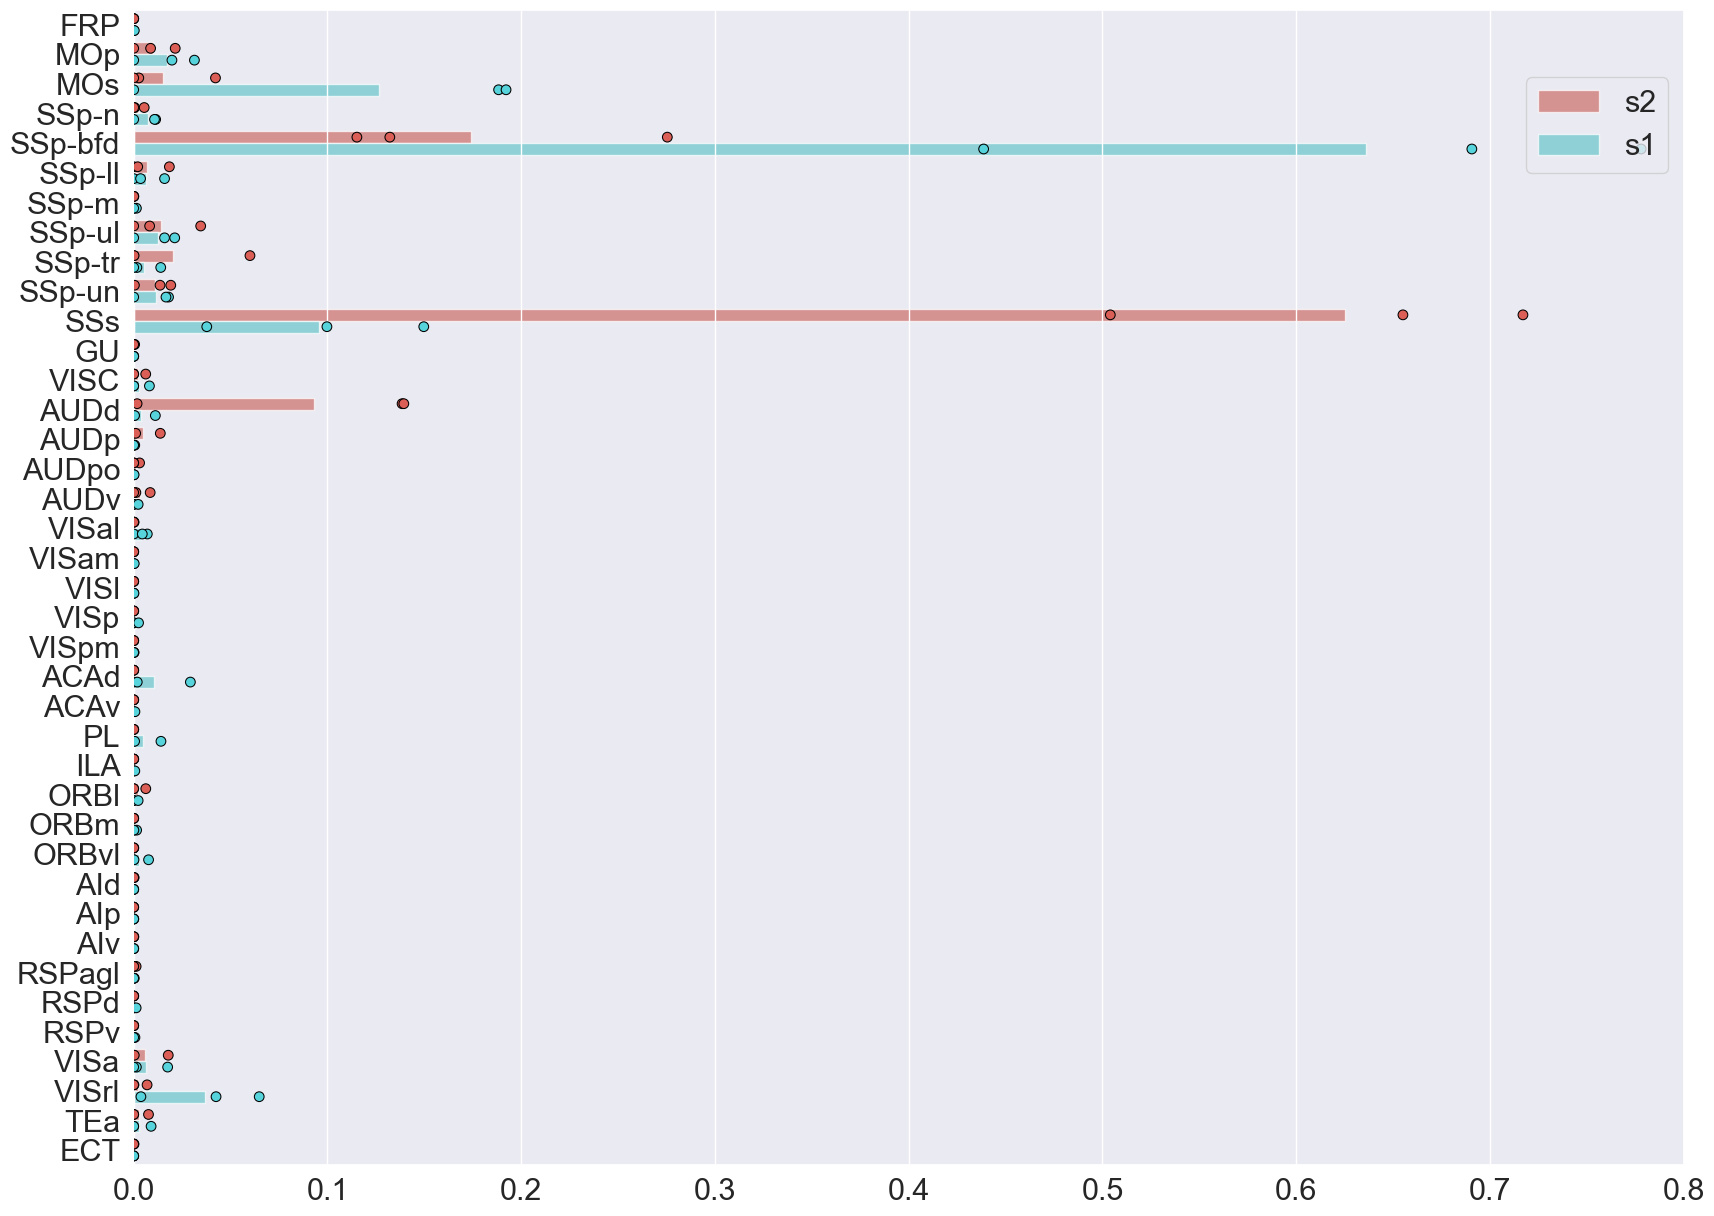

In [179]:
grouped_bar(expanded.sort_values(by='site',ascending=False),order,'left')

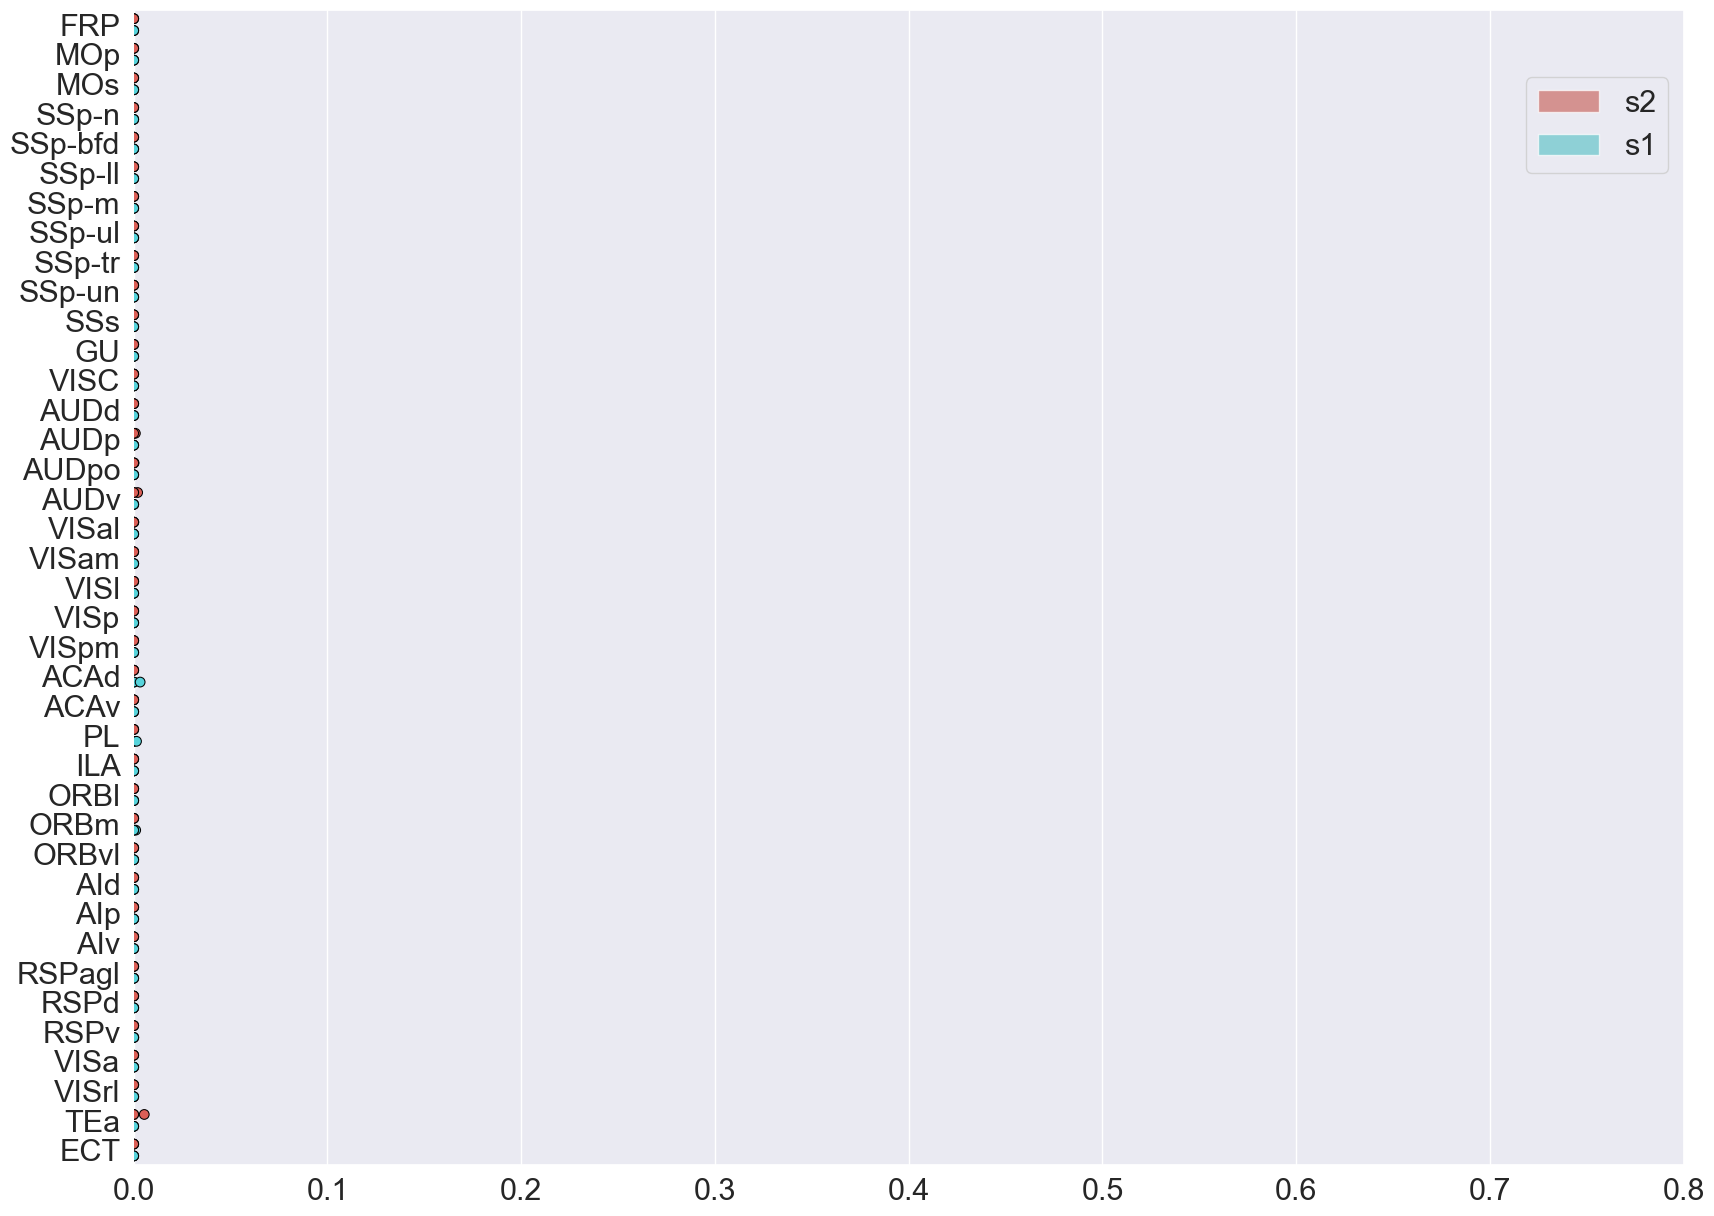

In [180]:
grouped_bar(expanded_r.sort_values(by='site',ascending=False),order,'right')

In [168]:
### test section for t test

both_df= pd.concat([s1_df, s2_df])
both_df=both_df.reset_index()
# combine the two df from s1 and s2 first

site_column= both_df.pop('site')
both_df.insert(1, "site", site_column, allow_duplicates=False)
# always make sure that the first column is index and secon column is injection site


In [169]:
from scipy.stats import ttest_ind

s1 = both_df[both_df['site']=='s1']
s2 = both_df[both_df['site']=='s2']

class1=pd.to_numeric(s1['MOs'])
class2=pd.to_numeric(s2['MOs'])

ttest_ind(class1, class2, equal_var=False)

Ttest_indResult(statistic=nan, pvalue=nan)

In [170]:
f=open(f'{outdir}\\{mouseline}_avg_{side}_{region_id}_parent.txt','w+')


for i in both_df.columns[2:]:
    # extract all acronyms, skips the first column which is the index(sample name) and second column which is the injection site
    
    class1=pd.to_numeric(s1[i])
    class2=pd.to_numeric(s2[i])

    stats,pvalue= ttest_ind(class1, class2, equal_var=False)
        
    if pvalue< 0.05:
        print(f'{i}, p value = {pvalue}')
        f.write(f'{i}, p value = {pvalue} \n')
    else:
        pass

f.close()
    

### section to plot bar graphs- a givne region for one injection site for all lines

Cannot just simply plot their value as fraction of total axons in the brain, need normalization

Combine two parent region (ie. MOs and MOp into MO id= 500): 

    ie. All layer in MO should add up to one
    
   

WORK IN PROGRESS

Alternatively, normalize each layer to total amount of axon within the region ( ie, layers 1 to 6 within SSp-bfd adds up to 1)

strategy- loop through every name with a number would indicate a region 's layer, go to one depth up, find the atlas id

then unique this list to get all the region that have layer loop through this list to sum up its sublayers, divide all the layer within with this um

July 2023 update: 
    
    read six excel files less stupidly (using loop now) and everything is much more cleaner!

not updated for september 2023 yet



In [22]:
def find_sample_list(df):
    '''Find list of sample's name from datafame column, ie: AL254, AL255, AL256'''
    sample_list= []

    for i in df.columns:
        m=re.search('\D{2}[0-9]{3}', i)
        if m: 
            sample_list.append(m[0])
    
    return sample_list

def normalize_layers (df, samples_list):
    ''' useful for later maybe 
    not in the case of combing two motor regions though'''
    sum_parent=df.groupby(['parent_structure_id'],as_index=False).sum()
    # compute sum of the parent regions
    
    parent_df= sum_parent[samples_list]
    parent_df['id']= sum_parent['parent_structure_id']
    # store the sums for each corresponding sample and their parent id
    
    normalized_df=[]

    for i in parent_df.id:
        this_parent= parent_df[parent_df['id']==i]
        # find the corresponding denominator

        this_child= df[df['parent_structure_id']== i]
        #find the corresponding numerators

        fraction_df= this_child/ this_parent.iloc[0]
        # this_parent.iloc[0] for format conversion to series so we could devide
        this_fraction= fraction_df[samples_list]
        this_fraction['id']=this_child['id']

        normalized_df.append(this_fraction)

    # append separate df into list
    normalized_df=pd.concat(normalized_df)
    # concatenate the separate dfs, actually a briliiant way
    
    normalized_df_fullinfo= pd.merge(normalized_df,atlas_labels, on='id')
    #merge back with atlas labels to get full info
    
    return normalized_df_fullinfo

def norm_region(df, df_r, sample_list):
    
    ''' Normalize values by the sum of the column. Usefuly if all the rows in the data frame belongs to the parent region that wants to be normalized to'''
    
    region_sum= df.sum()[sample_list]
     # calculate sum across all rows for a given column since everything isocortex related is already extracted
    # find total isocortex values in left hemisphere

    region_sum_r= df_r.sum()[sample_list]
    # find total isocortex values in right hemisphere

    all_isocortex=region_sum+region_sum_r
    # add these up

    norm_values= df[sample_list]/all_isocortex
    # divide left side to normalize
    df[sample_list]= norm_values

    norm_values_r= df_r[sample_list]/all_isocortex
    # divide right side to normalize
    df_r[sample_list]= norm_values_r

    return df, df_r

def sum_same_layer (df, layers_dict,sample_list):
    
    ''' Combine values from the same layer together, ie. MOs 2/3 and MOp 2/3
    need to give a dictionary! such as, {'MO1':'1','MO2/3':'2/3'}, note that the key must be EXACTLY matching atlas label acronym for later merge
    and the value is used to string.contain inside th acronym
    '''
    layers=[]

    for key, value in layers_dict.items():
        this_layer= df[df['acronym'].str.contains(f'{value}', case=False)].sum()
        # sum up this specific layer for MOs and MOp

        this_df= this_layer[sample_list]
        this_df['acronym'] = key
        # keep only acronym and sample values, to be merged to atlas labels later

        layers.append(this_df)
    
    return pd.DataFrame(layers)

def extract_df(name_list,choosen_df, site):
    '''from data frame, extract only relevant information-> region acronyms and values from individual samples 
    then, insert injection site information (site = 's1' , or 's2')'''
    name_list.insert(0,'acronym')
    # insert acronym to the list to be used as extracting columns from df
    testdf=choosen_df[name_list]
    new=testdf.T
    #new

    new.columns =new.iloc[0]
    new=new.drop(new.index[0])
    # make the acronym row as column names, then drop the first row

    new['site']=site
    # add respective injection site info to each sample
    return new

def combine_expanddf (bigdf):
    ''' combine two df , and prepare to sns barplot compatible format by pd.melt '''
    
    both_df= pd.concat(bigdf)
    both_df=both_df.reset_index()
    
    site_column= both_df.pop('site')
    both_df.insert(1, "site", site_column, allow_duplicates=False)
    # some times the site column will not always be in the last position of column order after pd.concat, because some regions are not present in both averaged excel files
    # relocate the site column as the second in the column order(position 1) so in the next melt step we do not include it
    
    expand1=pd.melt(both_df, id_vars=['index'], value_vars=both_df.columns[2:])
    # melt into sns preferred format
    to_repeat=len(both_df.columns)-2
    # need to repeat injection site list for x times, minus the index column and the site column

    repeated_list=[]
    x=0
    while x<to_repeat:
        repeated_list.append(both_df['site'].to_list())
        x+=1
    
    new_list = itertools.chain(*repeated_list)
    new_list=list(new_list)
    len(new_list)
    # use itertool to flatten list of list, final length = number of sample * number of brain region

    expand1['site']= new_list
    # finally add the injection site information as a column
    
    return expand1

def grouped_bar(expanded_df,order,region_id,injection,side):
    
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''

    sns.set(font_scale=2)
    
    color= [sns.hls_palette()[0],sns.hls_palette()[3]] 
    # specify the color template so that  s1 is always hls palette 3 (a cyan like color) and s2 is always hls palette 0 (a reddish color)
    # here we indicate s2 first because usually the bar graphs show s2 first (data frame sort_values by site, ascending=False)

    fig, ax = plt.subplots(figsize=(10,10))

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        order=order,
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        order=order,
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.9),
    )

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!
    
    ax.set(xlim=(0, 1))
    # do not change this xlim for this plot

    plt.savefig(f'{outdir}\\{injection}_{side}_normalized_{region_id}.svg')

    plt.show()
    

In [24]:

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

outdir= r'D:\\viral_results\\s1_s2'

# change the following section(s) if required 
region='s1'

region_id='500'
layers_dict= {'MO1':'1','MO2/3':'2/3', 'MO5': '5', 'MO6a': '6a', 'MO6b': '6b'}
# note that the key must be EXACTLY matching atlas label acronym for later merge and the value is used to string.contain inside th acronym


MO_regions= atlas_labels.loc[atlas_labels['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
# find all the MO regions from the atlas labels
MO_regions= MO_regions[MO_regions.depth==MO_regions.depth.max()]
# exclude  useless one such as somatomotor areas itself (id=500) and other crap by taking only the max depth, usually these are the actual regions present in the atlas

all_MO_regions= atlas_labels.loc[atlas_labels['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
# ie. all regions containing this region id



In [25]:
cre_list=['ras', 'scn', 'tlx', 'rbp', 'sim', 'nts'] 

side='left'
huge_df= []
for i in cre_list:   

    file_path= f'D:\\viral_results\\{region}_results\\{region}_{i}_avg_{side}.xlsx'
    read_file= pd.read_excel(file_path)
    read_file=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    read_file['cre']=i
    
    huge_df.append(read_file)

In [26]:
side='right'
huge_df_r= []
for i in cre_list:   

    file_path= f'D:\\viral_results\\{region}_results\\{region}_{i}_avg_{side}.xlsx'
    read_file= pd.read_excel(file_path)
    read_file=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    read_file['cre']=i

    huge_df_r.append(read_file)


In [27]:
final_df=[]
final_df_r=[]

for i,value in enumerate(cre_list):
    # loop through individual dfs inside huge_df and hugd_df_r
    
    sample_list=find_sample_list(huge_df[i])
    # find sample list
    
    this_norm, this_norm_r= norm_region(huge_df[i], huge_df_r[i], sample_list)
    
    sample_list_temp=sample_list
    sample_list_temp.insert(0, 'acronym')

    # use this as a list of columns to extract from normalized regions so that we can merge to  the MO_regions from atlas labels
    # we do this because not all samples have all the motor layers, especially the right hemisphere!
    
    this_norm_full=MO_regions.merge(this_norm[sample_list_temp], on='acronym', how='outer')
    this_norm_full_r=MO_regions.merge(this_norm_r[sample_list_temp], on='acronym', how='outer')
    # merging is outer because some samples does not have all or any of the MO layers, but we sitll need to keep the region and assign zero
    
    this_sumlayer= sum_same_layer(this_norm_full,layers_dict, sample_list)
    this_sumlayer_r= sum_same_layer(this_norm_full_r,layers_dict, sample_list)
    # calculate the summing of same layer for left and right side
    
    this_summed= all_MO_regions.merge(this_sumlayer, on='acronym', how='inner')
    this_summed_r= all_MO_regions.merge(this_sumlayer_r, on='acronym', how='inner')
    #merge with atlas labels, we are doing this becauswe we need to later sort with graph order!!
    # merging is inner now because by definition they all acronym contained in summlayer df must be inside atlas label
    
    keep_df= extract_df(sample_list, this_summed,value)
    keep_df_r= extract_df(sample_list, this_summed_r,value)
    
    final_df.append(keep_df)
    final_df_r.append(keep_df_r)


In [28]:
expanded= combine_expanddf(final_df)
expanded_r= combine_expanddf(final_df_r)

In [29]:
order=final_df[0].columns.sort_values()[:-1]
# define order of bar graphs from 1 to 6b

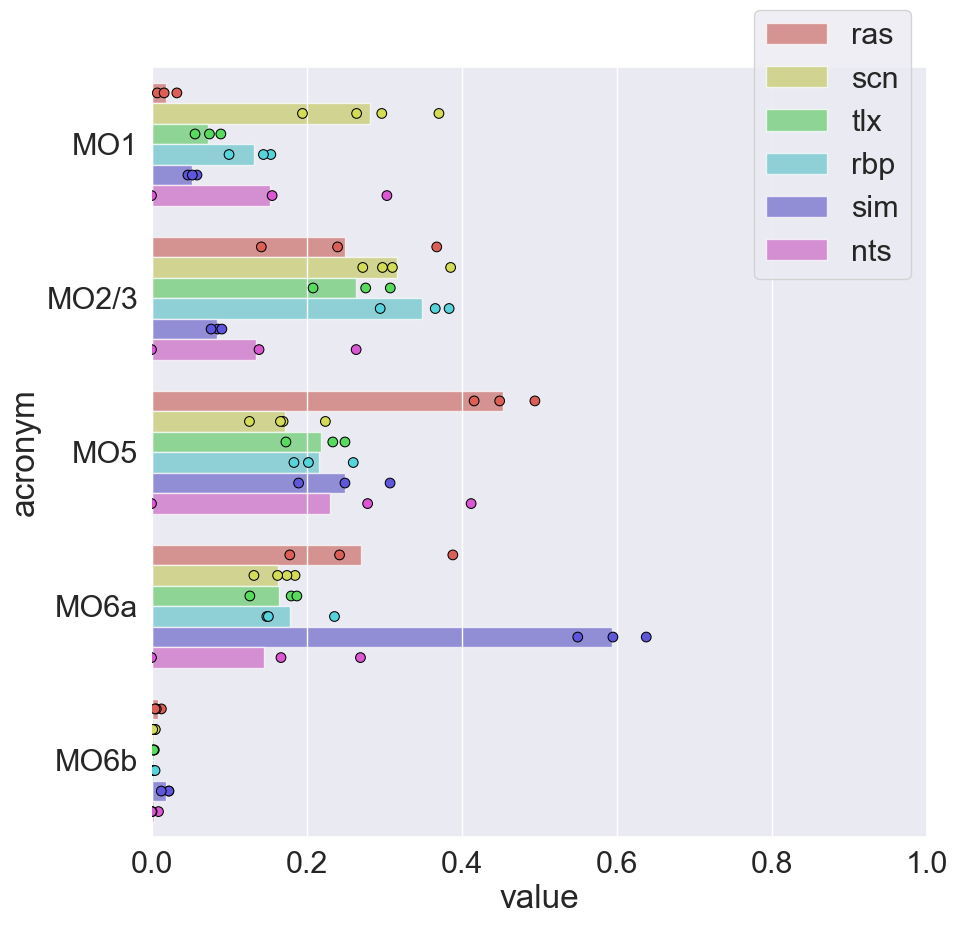

In [32]:
grouped_bar(expanded, order, region_id,region,'left')

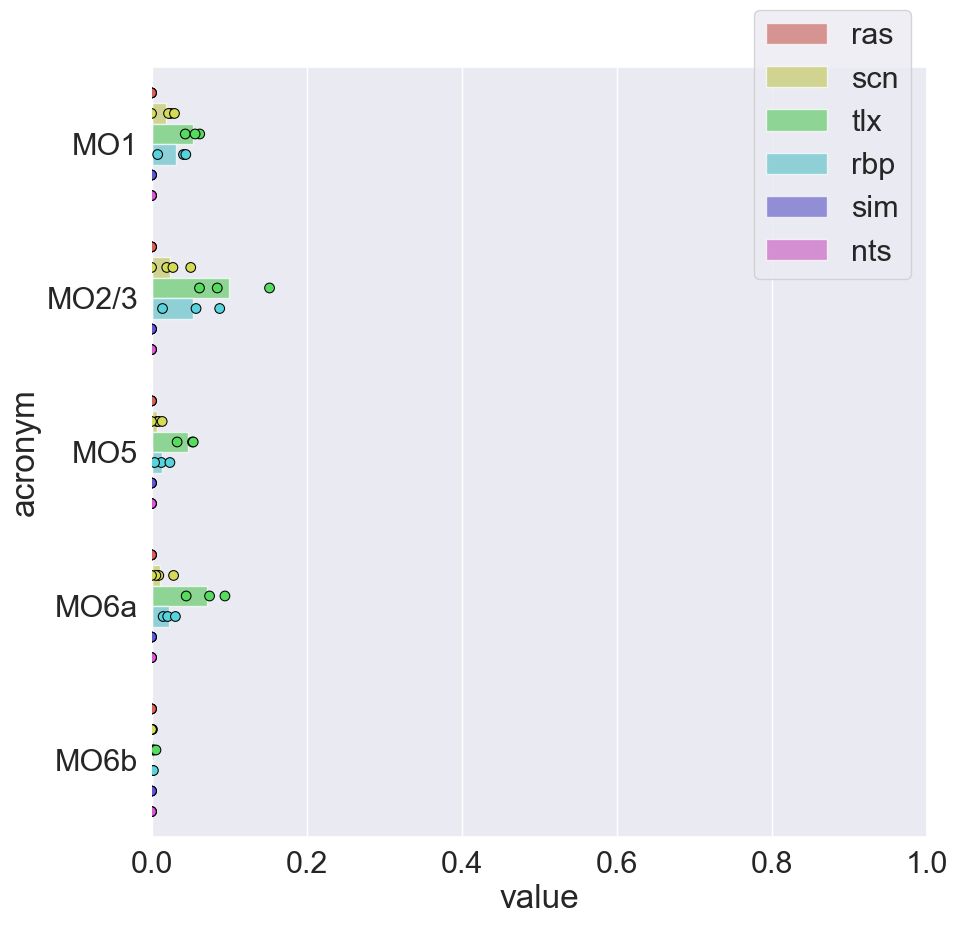

In [33]:
grouped_bar(expanded_r, order, region_id,region,'right')

### test region

[-0.17377256  1.56899161 -0.00825274  0.23547782]


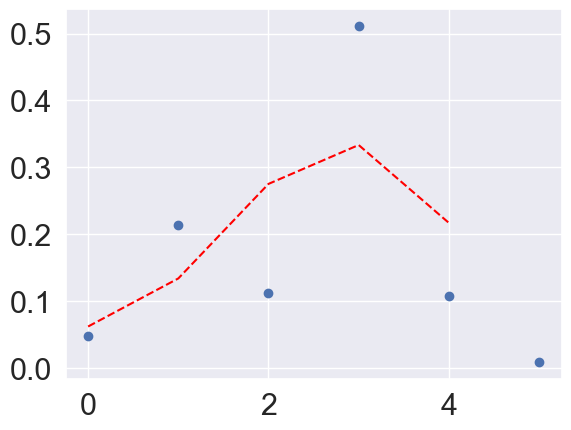

In [28]:
# curve fitting for layer distribution test

from numpy import sin
from numpy import sqrt
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

# define the true objective function
def objective(x, a, b, c, d):
 return a * sin(b - x) + c * x**2 + d
 
# load the dataset
x, y = cre1_norm.index, cre1_norm['AL254']

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d = popt
print(popt)
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

# OK not so good, since only have 6 data points (6 layers)

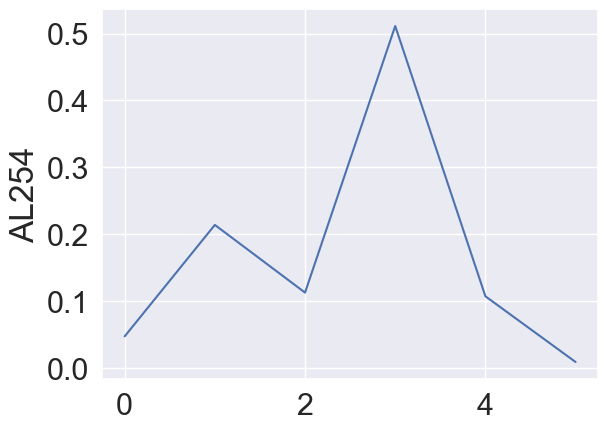

In [29]:
x, y = cre1_norm.index, cre1_norm['AL254']

sns.lineplot( x=x, y=y)   
plt.show()

### test section for hierarchical clustering

In [15]:
from scipy.cluster import hierarchy

C:\Users\liu\AppData\Local\Temp\ipykernel_16268\1812499085.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  matrix = pd.DataFrame(np.random.random_integers(0,1, size=(50,4)))
C:\Users\liu\AppData\Local\Temp\ipykernel_16268\1812499085.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 5 + 1) instead
  labels = np.random.random_integers(0,5, size=50)
C:\Users\liu\AppData\Local\Temp\ipykernel_16268\1812499085.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  labels2 = np.random.random_integers(0,1, size=50)


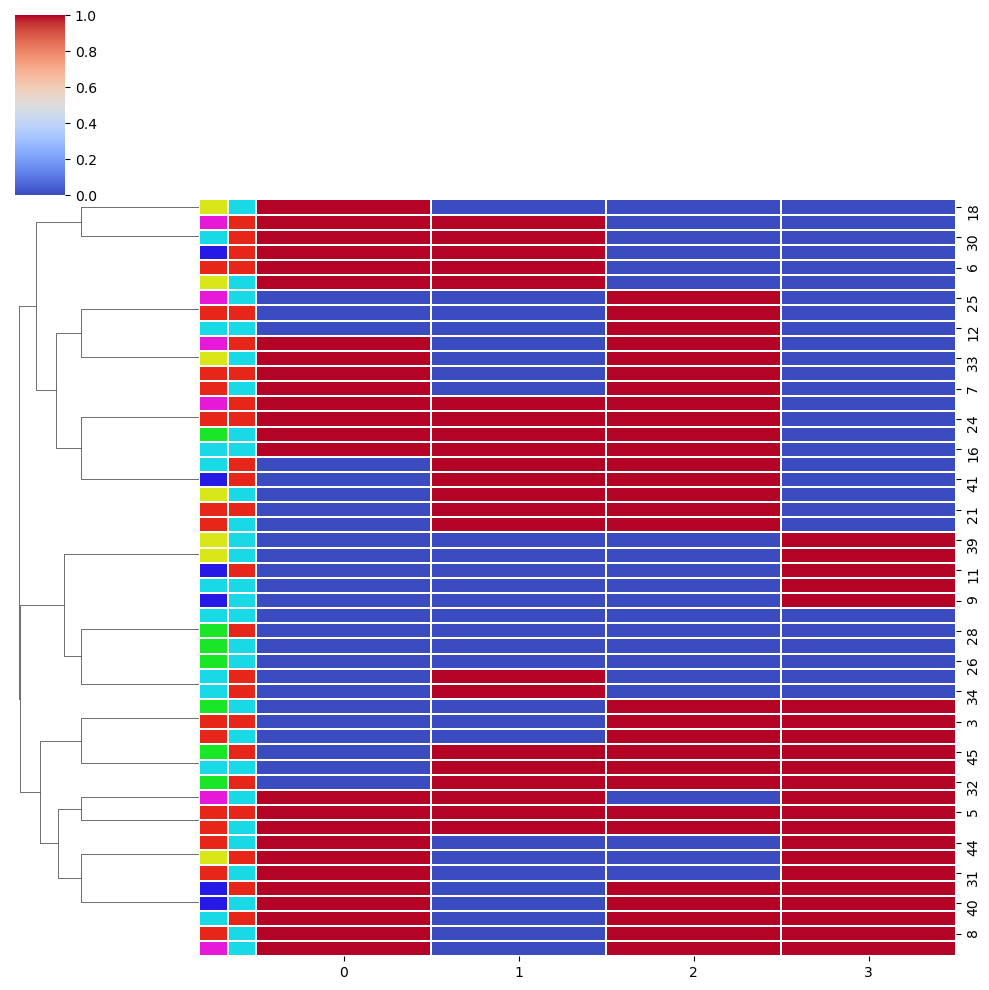

In [157]:
# test data from the internet
matrix = pd.DataFrame(np.random.random_integers(0,1, size=(50,4)))

labels = np.random.random_integers(0,5, size=50)
lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
row_colors = pd.DataFrame(labels)[0].map(lut)

#Create additional row_colors here
labels2 = np.random.random_integers(0,1, size=50)
lut2 = dict(zip(set(labels2), sns.hls_palette(len(set(labels2)), l=0.5, s=0.8)))
row_colors2 = pd.DataFrame(labels2)[0].map(lut2)

g=sns.clustermap(matrix, col_cluster=False, linewidths=0.1, cmap='coolwarm', row_colors=[row_colors, row_colors2])
plt.show()

In [16]:
# genereate a labels list by finding sample's genotype
label_list= []

for i in final_df.columns:
    if 's2' in i:
        sample_dictionary= {'sim': ['AL281','AL286','AL321','AL322'],
                        'rbp': ['AL288','AL326','AL327'],
                        'tlx': ['AL278','AL280','AL319'],
                        'ras': ['AL303','AL332','AL333'],
                        'scn': ['AL290','AL292','AL323'],
                        'nts': ['AL274','AL310','AL330']
                       }
        
        for key, value in sample_dictionary.items():
            if find_mousename(i) in value:
                label_list.append(key+'_s2')
        
        
    else: 
        sample_dictionary= {'sim': ['AL207','AL209','AL273'],
                        'rbp': ['AL211','AL318'],
                        'tlx': ['AL213','AL313','AL314'],
                        'ras': ['AL254','AL255','AL257'],
                        'scn': ['AL290','AL291','AL292','AL293'],
                        'nts': ['AL274','AL285','AL311']
                       }
        
        for key, value in sample_dictionary.items():
            if i in value:
                label_list.append(key)
    

In [19]:
label_list_series=pd.Series(label_list)

C:\Users\liu\AppData\Local\Continuum\anaconda3\envs\analysis\lib\site-packages\seaborn\matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


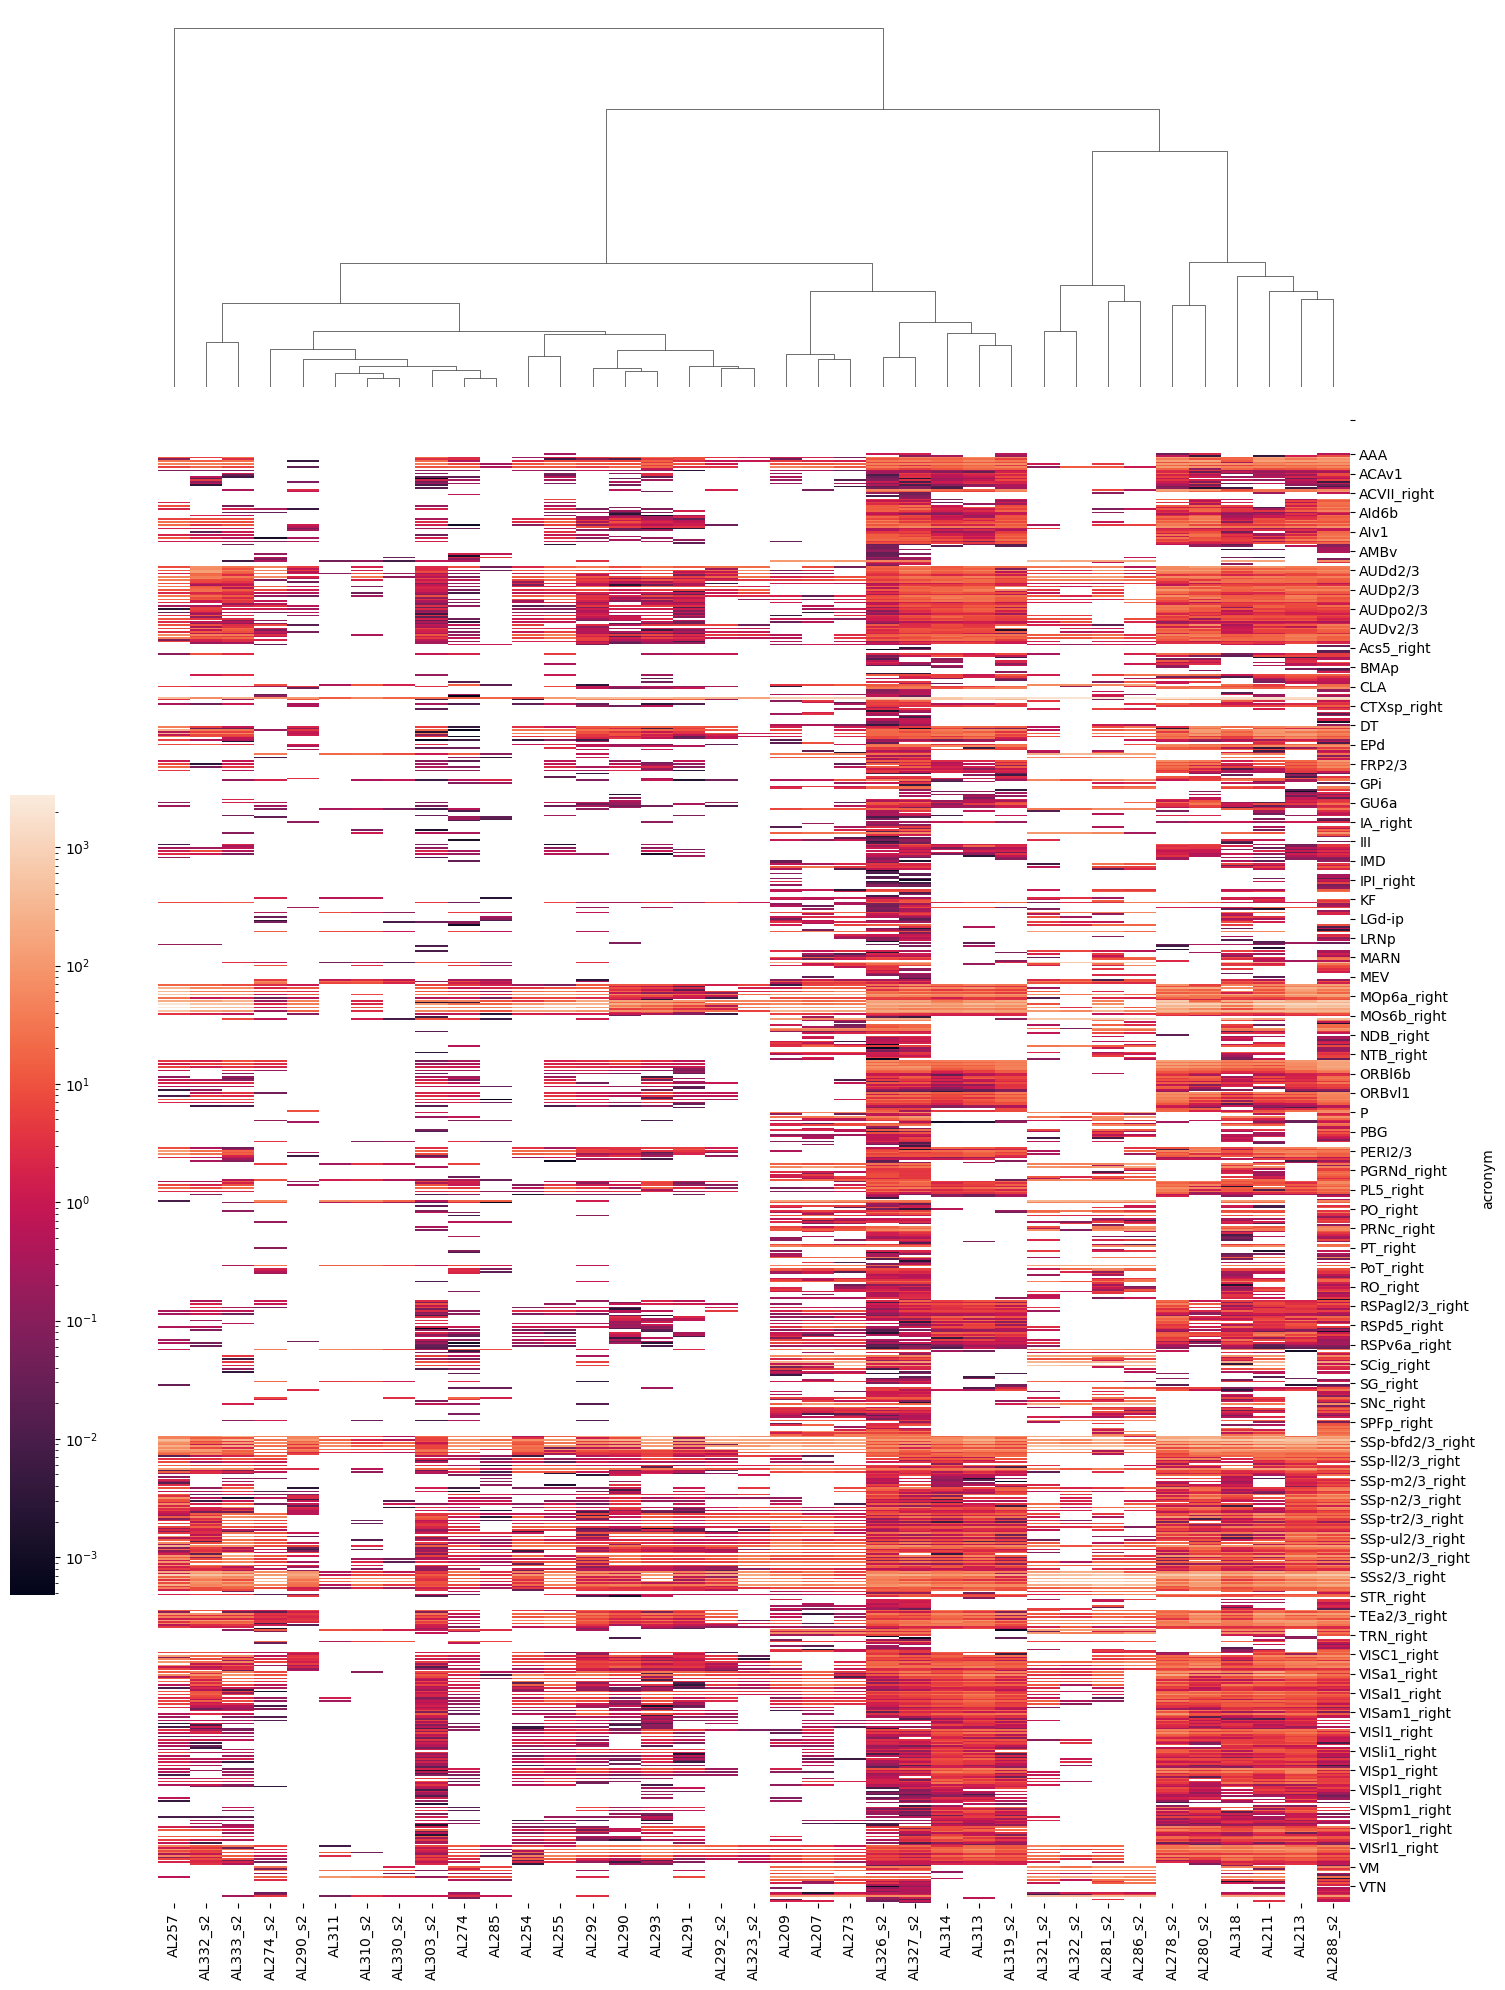

In [18]:
# Prepare a vector of color mapped to the label_list

my_palette = dict(zip(label_list_series.unique(), ["red","red","yellow","yellow","green","green","blue","blue","magenta","magenta","brown","brown"]))
col_colors =label_list_series.map(my_palette)
# somehow this color bar does not show up?!
# WORK IN PROGRESS

sns.clustermap(
    final_df,
    figsize=(15, 20),
    method='complete',
    norm=LogNorm(),
    row_cluster=False,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(0, .2, .03, .4),
    col_cluster=True,
    col_colors=col_colors
)

#plt.savefig("test.svg")
# somehow the column order is changed, probably this is what the linkage did..

In [20]:
test_array=final_df.to_numpy()
test_array.shape

(899, 37)

In [21]:
test_array=test_array.swapaxes(0,1)
test_array.shape

(37, 899)

In [22]:
label_list_series.unique()

array(['ras', 'ras_s2', 'scn', 'scn_s2', 'tlx', 'tlx_s2', 'rbp', 'rbp_s2',
       'sim', 'sim_s2', 'nts', 'nts_s2'], dtype=object)

In [23]:
label_colors = {
    'ras': 'r', 'ras_s2': 'r',
    'scn': 'y', 'scn_s2': 'y',
    'tlx': 'g', 'tlx_s2': 'g',
    'rbp': 'c', 'rbp_s2': 'c',
    'sim': 'b', 'sim_s2': 'b',
    'nts': 'm', 'nts_s2': 'm'
}

# define color dictionary to color leaves

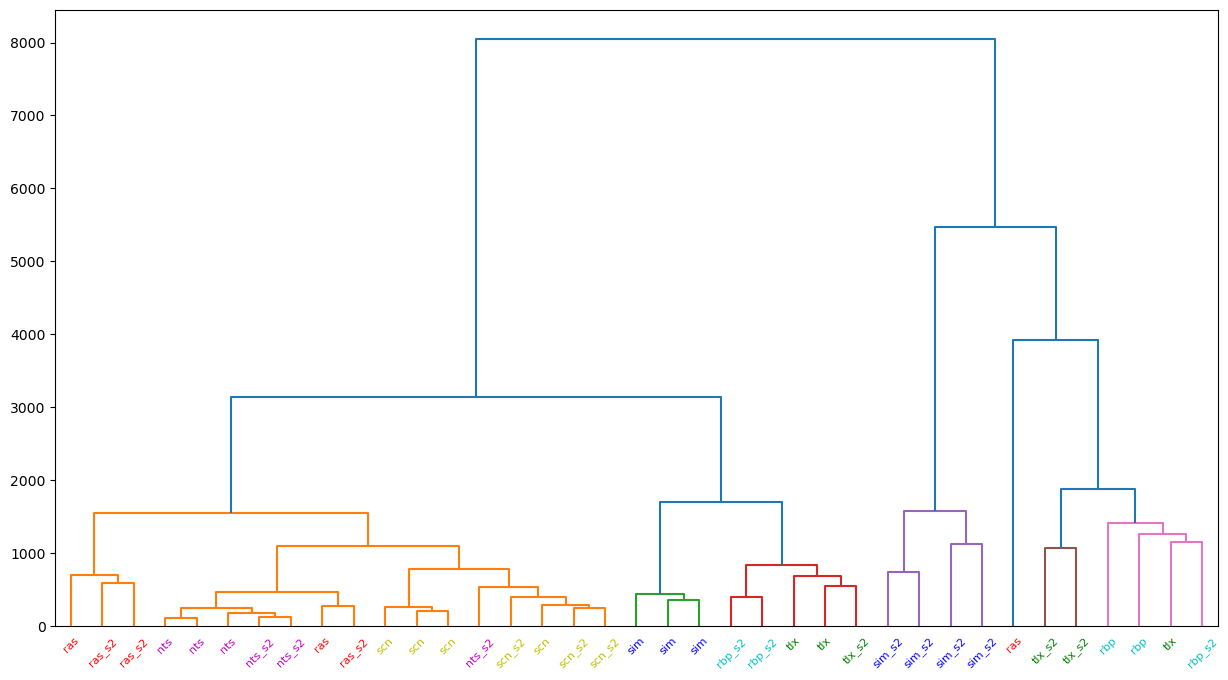

In [30]:
Z = hierarchy.linkage(test_array, 'ward',
                      optimal_ordering=False)

fig = plt.figure(figsize=(15, 8))

dn = hierarchy.dendrogram(Z, labels=label_list, color_threshold=1600)

ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()


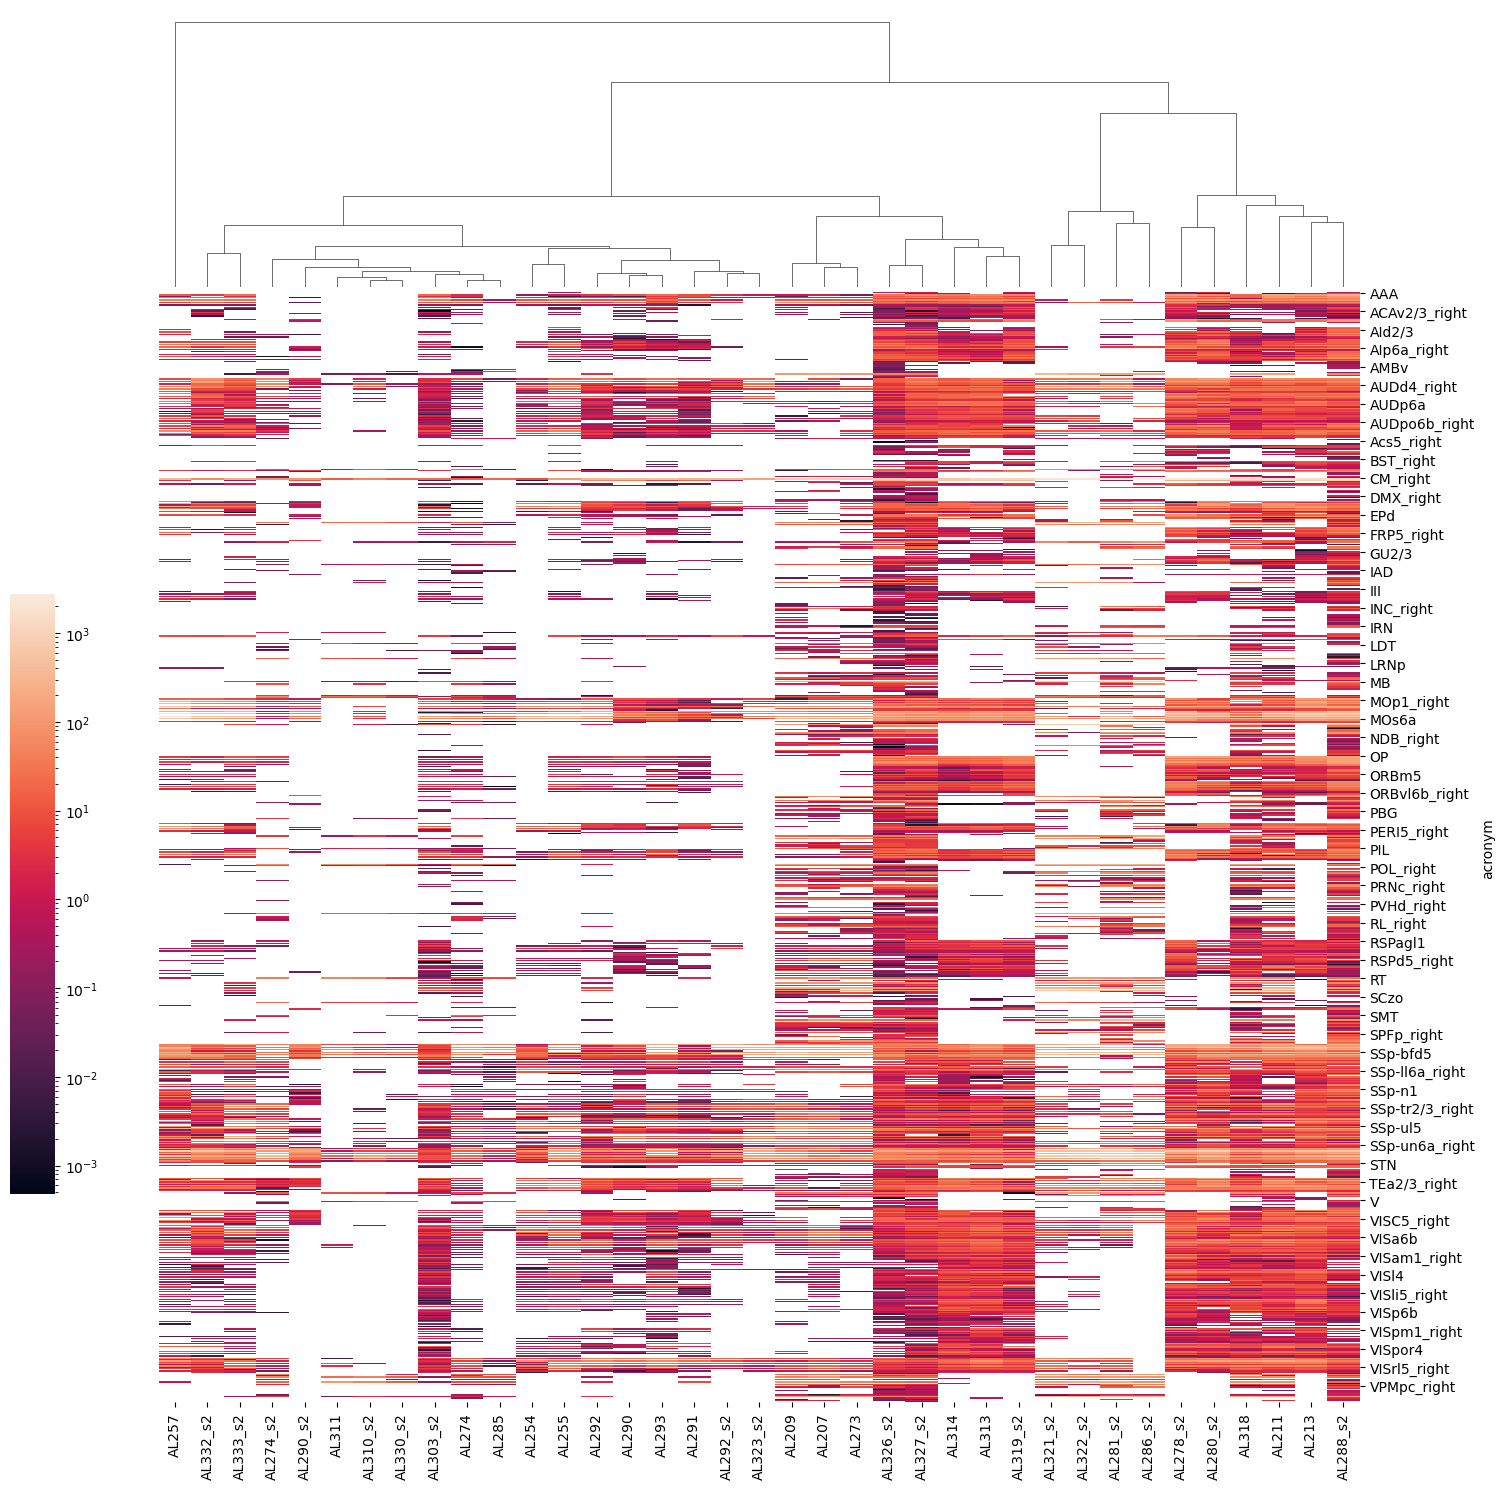

In [29]:
# this passes an already calculated linkage above
sns.clustermap(final_df,
               col_linkage=Z,
               row_cluster=False,
               figsize=(15, 15),
               norm=LogNorm(),
               dendrogram_ratio=(0.1, .2),
               cbar_pos=(0, .2, .03, .4)
              )
#plt.savefig("test.svg")


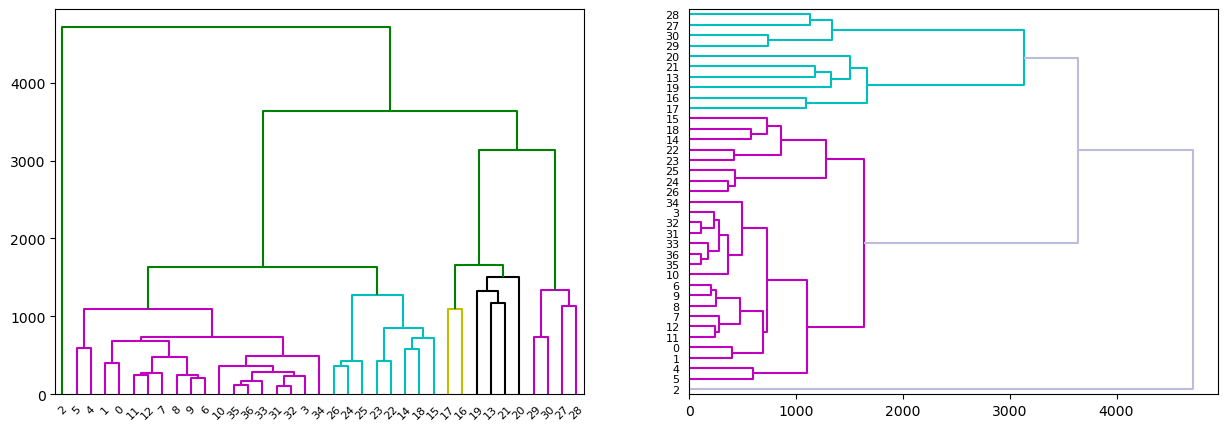

In [84]:
# testing how linkage color works

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='g',
                           color_threshold=1600,
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1],
                           above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

In [82]:
hierarchy.fcluster(Z, t=1650, criterion='distance')

array([1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 2, 1, 3, 3, 3,
       1, 1, 1, 1, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1], dtype=int32)